# MAMS-ABSA

The goal of this project is to complete the Aspect-based Sentiment Analysis (ABSA) task. ABSA task aims at identifying the sentiment polarity (e.g. positive, negative, neutral) of one specific aspect in its context sentence.

# 1.Dataset Processing

## 1.1 Loading and Imports

### 1.1.1 Importing required libraries

In [ ]:
%pip install torch
%pip install contractions
%pip install pyspellchecker 
%pip install sentencepiece 

import json
import re
from collections import Counter

import contractions
import gensim.downloader as api
from matplotlib import pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader, Dataset

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



The datasets are structured in a dictionary format, rather than being nested JSON objects. We will convert this dictionary to a DataFrame with using the dictionary keys 'columns' and 'data' to better analyse the data.

In [ ]:
from src.data_utils import load_data, set_seed, get_pathname
from src.preprocessing import expand_contractions, remove_punctuation
from src.eda import plot_distribution
from src.modeling import train_model

# set seed for reproducibility
set_seed(4012)

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# load data from drive
drive_path = '/content/drive/My Drive/CITS4012_NLP/'

# load datasets as dictionaries
# convert dictionary to DF structure
train = load_data('data/train.json')
val = load_data('data/val.json')
test = load_data('data/test.json')


columns = train['columns']

train_data = train['data']
train_df = pd.DataFrame(train_data, columns = columns)

val_data = val['data']
val_df = pd.DataFrame(val_data, columns = columns)

test_data = test['data']
test_df = pd.DataFrame(test_data, columns = columns)

train_df.head()

Mounted at /content/drive


sentence         aspect  polarity
0  It might be the best sit down food I've had in...           food  positive
1  It might be the best sit down food I've had in...          place   neutral
2  Hostess was extremely accommodating when we ar...          staff  positive
3  Hostess was extremely accommodating when we ar...  miscellaneous   neutral
4  We were a couple of minutes late for our reser...  miscellaneous   neutral

### 1.1.3 Utility Functions

#### Experiment Handling

In [ ]:
# init dict to store global results
global_results = {}

def update_global_results(global_results, experiment_name, metrics):
    '''
    Update the global results dictionary with the results of an experiment.
    '''
    accuracy, precision, recall, f1, precision_weighted, recall_weighted, f1_weighted, cm = metrics
    global_results[experiment_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm.tolist()
    }

def create_experiment_config(base_config, updates, experiment_name):
    '''
    Create a new configuration by merging the base config with the updates.

    Arguments:
        base_config (dict): The base configuration.
        updates (dict): The updates to be applied to the base configuration.
        experiment_name (str): The name of the experiment.

    Returns:
        dict: The updated configuration.
    '''
    new_config = base_config.copy()
    new_config.update(updates)
    new_config['experiment_name'] = experiment_name
    return new_config

def save_experiment_config(config, base_path, experiment_name):
    config_path = os.path.join(base_path, experiment_name, 'config.json')
    os.makedirs(os.path.dirname(config_path), exist_ok=True)
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)
    print(f"Configuration saved to {config_path}")

def save_experiment_results(results, base_model_path, experiment_name):
    results_path = os.path.join(base_model_path, experiment_name, 'results.json')
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Results saved to {results_path}")

#### Statistics and Visualisation

In [ ]:
def visualise_model_training(train_losses, val_losses, train_accs, val_accs):
    '''
    Input: lists of training and validation losses and accuracies
    '''
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def get_training_stats(y_true, y_pred, print_stats):
    """
    Get stats from model training.

    Returns: accuracy, precision, recall, f1, precision_weighted, recall_weighted, f1_weighted, cm
    """
    accuracy = accuracy_score(y_true, y_pred)

    print("Accuracy:", accuracy) if print_stats else None

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    if print_stats:
        print("Precision (Macro):", precision)
        print("Recall (Macro):", recall)
        print("F1-Score (Macro):", f1)

    # For weighted average
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    if print_stats:
        print("Precision (Weighted):", precision_weighted)
        print("Recall (Weighted):", recall_weighted)
        print("F1-Score (Weighted):", f1_weighted)

    # Plot Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    print("Confusion Matrix:") if print_stats else None
    plot_confusion_matrix(cm) if print_stats else None

    return accuracy, precision, recall, f1, precision_weighted, recall_weighted, f1_weighted, cm

def plot_confusion_matrix(cm):
    '''
    Plot a confusion matrix.
    '''
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

### 1.1.4 Initialise Preprocessing Configuration

In [ ]:
# init base config for preprocessing and data preparation
base_config = {
    # preprocessing
    'expand_contractions': True,
    'handle_numeric': True,
    'num_data_handling_method': 'convert', # ['convert' | 'tag']
    'remove_punctuation': True,
    'spell_check': False,
    'remove_stop_words': False,
    'lemmatize': False,
    'use_pos_tags': True,

    'max_seq_length': None, # TODO: remove?

    # data preparation
    'pos_attention_method': 'concat', # ['concat' | 'seperate']
    'word_emb_model': 'glove-twitter-',
    'word_emb_model_embedding_dim': 50,
    'pos_embedding_dim': 10,
    'concat_aspect': False,       # concat aspect with sentence
    'separator_token': '[SEP]',
    'padding_token': '[PAD]',
    'oov_token': '[UNK]',

    # paths
    'base_path': f'{drive_path}data/processed',
    'base_model_path' : f'{drive_path}results',
    'experiment_name': '',

    'save_model': True,

    'DEBUG': True
}

# init current config
config = base_config

# create the base path directory if it does not exist
os.makedirs(config['base_path'], exist_ok=True)

# save base config to disk
config_path = get_pathname(config, 'config', 'json')
with open(config_path, 'wb') as f:
    pickle.dump(config, f)
    print(f"Config saved to {config_path}")

Config saved to /content/drive/My Drive/CITS4012_NLP/data/processed/config.json


## 1.2 Describing the MAMS Dataset

Each sentence in the dataset is associated with various aspects and their respective sentiment polarities.

In [ ]:
print("Number of sentences in training dataset:", len(train_df))
print("Number of sentences in validation dataset:", len(val_df))
print("Number of sentences in test dataset:", len(test_df))

Number of sentences in training dataset: 7090
Number of sentences in validation dataset: 888
Number of sentences in test dataset: 901


In [ ]:
print("Number of reviews in training dataset:", len(train_df.groupby('sentence')))
print("Number of reviews in validation dataset:", len(val_df.groupby('sentence')))
print("Number of reviews in test dataset:", len(test_df.groupby('sentence')))

Number of reviews in training dataset: 3149
Number of reviews in validation dataset: 400
Number of reviews in test dataset: 400


In [ ]:
train_df.groupby('sentence').sum()

aspect  \
sentence                                                                        
$25 prix fixe sounds like a good deal, but dinn...     pricemiscellaneousfood   
$45 a head with tip for bad gnocchi, mediocre w...          foodmiscellaneous   
' When I called the waitress on it, she said th...                  stafffood   
' When I reasoned with them that my dining part...                  foodstaff   
(Note: Price variations were listed nowhere--an...                  pricefood   
...                                                                       ...   
yes Shrimp not lobster (those are 6 Lbs) try th...                   foodmenu   
yes as I sat at the table waiting just under 1 ...                servicefood   
yes this place has good pizza but HORRIFIC HORR...                foodservice   
you go all out with dress, tastes, and performa...  miscellaneousfoodambience   
you may have to wait a bit for service but you ...                servicefood   

                                                                   polarity  
sentence                                                                     
$25 prix fixe sounds like a good deal, but dinn...  neutralnegativenegative  
$45 a head with tip for bad gnocchi, mediocre w...          negativeneutral  
' When I called the waitress on it, she said th...          negativeneutral  
' When I reasoned with them that my dining part...          neutralnegative  
(Note: Price variations were listed nowhere--an...          negativeneutral  
...                                                                     ...  
yes Shrimp not lobster (those are 6 Lbs) try th...          positiveneutral  
yes as I sat at the table waiting just under 1 ...          neutralpositive  
yes this place has good pizza but HORRIFIC HORR...         positivenegative  
you go all out with dress, tastes, and performa...   neutralpositiveneutral  
you may have to wait a bit for service but you ...         negativepositive  

[3149 rows x 2 columns]

In [ ]:
# number of occurrences for each aspect
aspect_counts = train_df['aspect'].value_counts()
print("Aspect distribution:")
aspect_counts

Aspect distribution:


aspect
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322
Name: count, dtype: int64

In [ ]:
# number of occurrences for each sentiment
polarity_counts = train_df['polarity'].value_counts()
print("Sentiment distribution:")
polarity_counts

Sentiment distribution:


polarity
neutral     3077
negative    2084
positive    1929
Name: count, dtype: int64

In [ ]:
# number of aspects per sentence and their frequency
aspects_per_sent = train_df.groupby('sentence')['aspect'].nunique()
aspects_per_sent_df = aspects_per_sent.reset_index() # convert result to df
aspects_per_sent_df.columns = ['sentence', 'aspect_count']

print("Aspects per sentence distribution:")
aspects_per_sent_df['aspect_count'].value_counts()

Aspects per sentence distribution:


aspect_count
2    2452
3     609
4      81
5       7
Name: count, dtype: int64

### 1.2.1 Data quality

Checking for missing or null values in the data, and assess duplicate values. To assess potential duplicate values, we will check whether each sentence in a given review has a unique aspect. This assumes that duplicate reviews are the same sentence and the same aspect. There's a possibility that a specific sentence and aspect combination has been assigned more than one aspect.


In [ ]:
# check for missing values
print(train_df.isnull().sum())

sentence    0
aspect      0
polarity    0
dtype: int64


In [ ]:
# check whether duplicates (defined as the same sentence has the same aspect)
df_dict = {"training set": train_df, "validation set": val_df, "test set": test_df}

for name, df in df_dict.items():
  duplicates = df.duplicated(subset=['sentence', 'aspect'], keep=False)
  duplicate_rows = df[duplicates]
  print(f"Number of duplicates in {name}: {len(duplicate_rows)}")


Number of duplicates in training set: 0
Number of duplicates in validation set: 0
Number of duplicates in test set: 0


Since there are no sentences with the same aspect mentioned more than once, we can assume that there are also no exact duplicates across all columns (sentence, aspect, polarity).

### 1.2.2 Distribution of Aspect and Sentiment

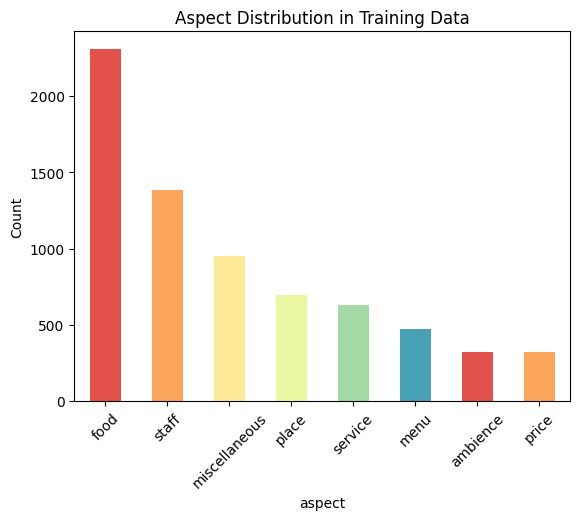

In [ ]:
def plot_distribution(data, title):
  data.plot(kind='bar', color=sns.color_palette("Spectral"))
  plt.title(title)
  plt.xticks(rotation=45)
  plt.ylabel('Count')
  plt.show()

plot_distribution(aspect_counts, 'Aspect Distribution in Training Data')

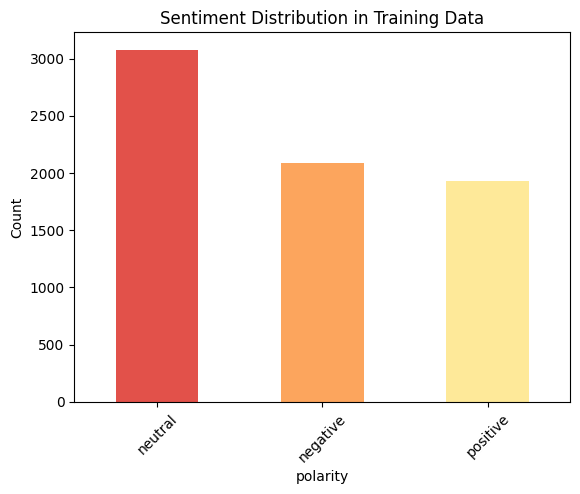

In [ ]:
plot_distribution(polarity_counts, 'Sentiment Distribution in Training Data')

### 1.2.3 Length of Reviews

The input layer or sequence padding will be affected by the length of each review, so we will assess its distribution. This will help us:

- Determine an appropriate maximum sequence length for models (above 95th percentile of review lengths?) - trying to reduce comp load without sacrificing info

- Determine padding strat for shorter reviews / whether to trim longer reviews

- how do we treat long / short reviews? do they contain enough contextual info for analysis?

- does the aspect/sentiment distribution vary with review length? longer reviews may be more nuanced and cover more aspects?

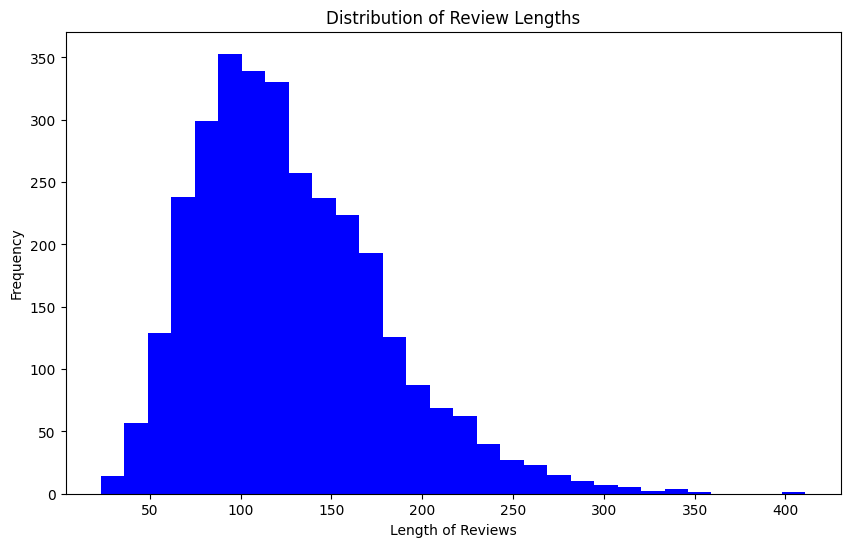

In [ ]:
# get length of each review
train_df['review_length'] = train_df['sentence'].apply(len)

# get unique reviews
train_df_uniq_reviews = train_df.groupby('sentence').first().reset_index()

# plot distribution of the length of each unique review
plt.figure(figsize=(10, 6))
plt.hist(train_df_uniq_reviews['review_length'], bins=30, color='blue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.show()

Most reviews appear to be between 50 to 250 characters long. The highest frequency of reviews are between 100 and 150 characters in length. There are a number long reviews, greater than 400 words.  

I believe the longest review may be >400 characters, but in terms of words, the longest sequence is 67 words. As such, there may not be any need to truncate the sequence.

In [ ]:
train_95_percentile = train_df_uniq_reviews['review_length'].quantile(0.95)

print("5% of reviews have a word count greater than", train_95_percentile)


5% of reviews have a word count greater than 226.0


In [ ]:
print(train_df[train_df['review_length'] == train_df['review_length'].min()]['sentence'])

2587    best chicken in queens.
2588    best chicken in queens.
Name: sentence, dtype: object


In [ ]:
# long sentence
train_df[train_df['review_length'] == train_df['review_length'].max()]

sentence aspect  polarity  \
3305  Evening started out nice w/ complimentary glas...   food  positive   
3306  Evening started out nice w/ complimentary glas...  staff  negative   
3307  Evening started out nice w/ complimentary glas...  price  negative   

      review_length  
3305            411  
3306            411  
3307            411

I find it strange that the polarity for the food aspect is positive here?

In this long review, the language describing each aspect's sentiment is interwoven in the narrative ('overcooked mussels' for food, 'kid size portion' for food, 'owner recommended' for staff, 'double the price' for price). This will require a model that can contextually understand language specific to each aspect.

What is the correlation between review length and the number of aspects?

In [ ]:
# get count of aspects
train_df = train_df.merge(aspects_per_sent_df, left_on='sentence', right_on='sentence', how='left')

<Axes: title={'center': 'Aspect Count by Review Length'}, xlabel='review_length'>

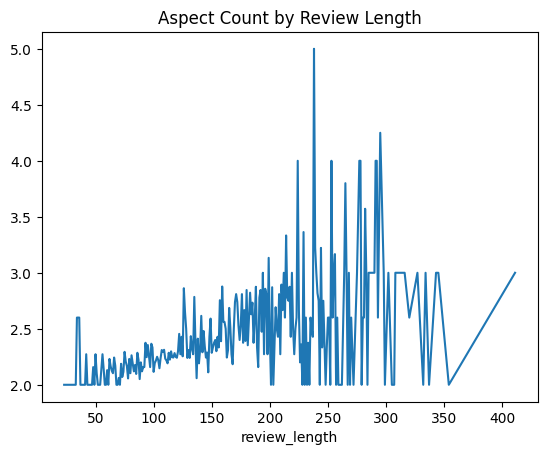

In [ ]:
train_df.groupby('review_length')['aspect_count'].mean().plot(title="Aspect Count by Review Length")

are there multiple aspects for the same sentiment?



In [ ]:
# summary statistics
summary_statistics = train_df['aspect_count'].describe()

# Print summary statistics
print(summary_statistics)

count    7090.000000
mean        2.363893
std         0.593751
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: aspect_count, dtype: float64


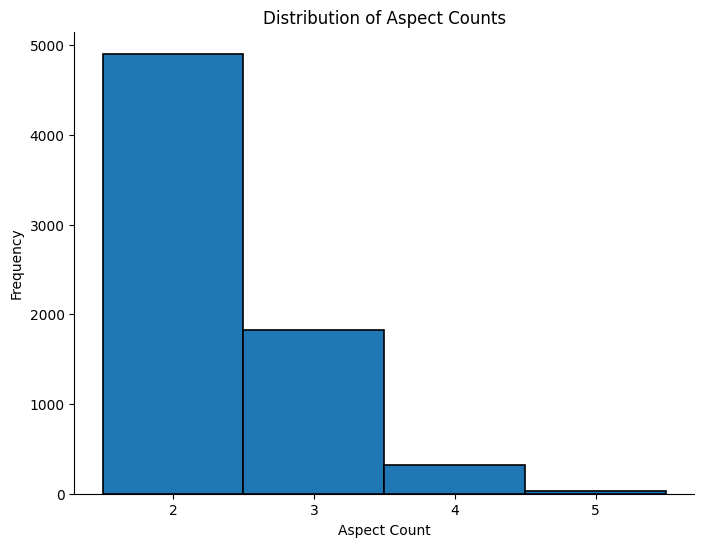

In [ ]:
train_df['aspect_count'] = train_df['aspect_count'].astype(int)

plt.figure(figsize=(8,6))
train_df['aspect_count'].plot(kind='hist', bins=[1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black', linewidth=1.2)
plt.title('Distribution of Aspect Counts')
plt.xlabel('Aspect Count')
plt.ylabel('Frequency')
plt.xticks([2, 3, 4, 5])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

### 1.2.4 Aspect-Polarity Analysis

Looking at how often each aspect is associated with each polarity to identify if cetain aspectss are more prone to pos/neg/neutral senitments.

polarity       negative  neutral  positive
aspect                                    
ambience             90       53       181
food                255     1298       754
menu                 39      372        64
miscellaneous       196      531       227
place               139      430       125
price               114      136        72
service             329      128       174
staff               922      129       332


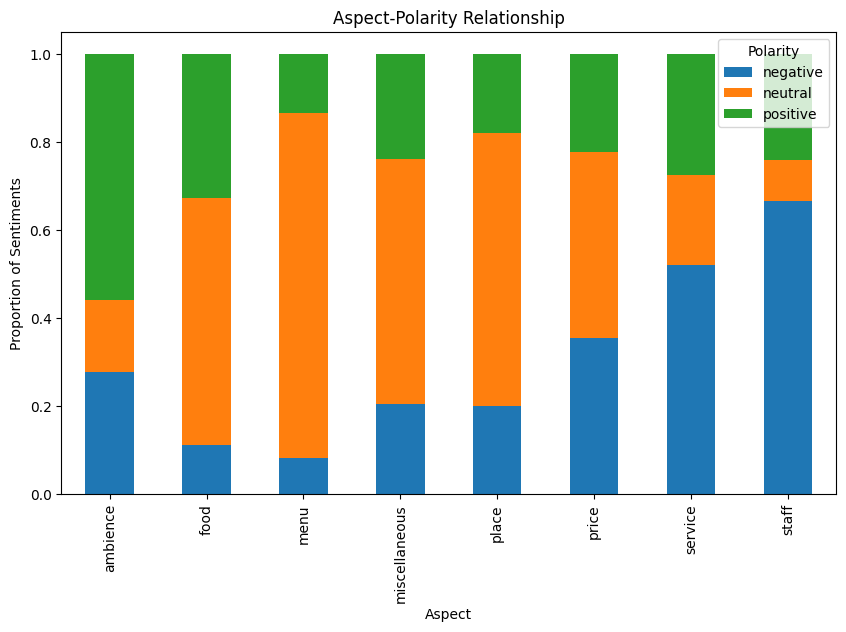

In [ ]:
# Create a contingency table of aspect vs polarity
aspect_polarity_crosstab = pd.crosstab(train_df['aspect'], train_df['polarity'])
print(aspect_polarity_crosstab)

# normalise to get proportions
aspect_polarity_crosstab_normalised = pd.crosstab(train_df['aspect'], train_df['polarity'], normalize='index')

# Plot
aspect_polarity_crosstab_normalised.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Aspect-Polarity Relationship')
plt.xlabel('Aspect')
plt.ylabel('Proportion of Sentiments')
plt.legend(title='Polarity')
plt.show()

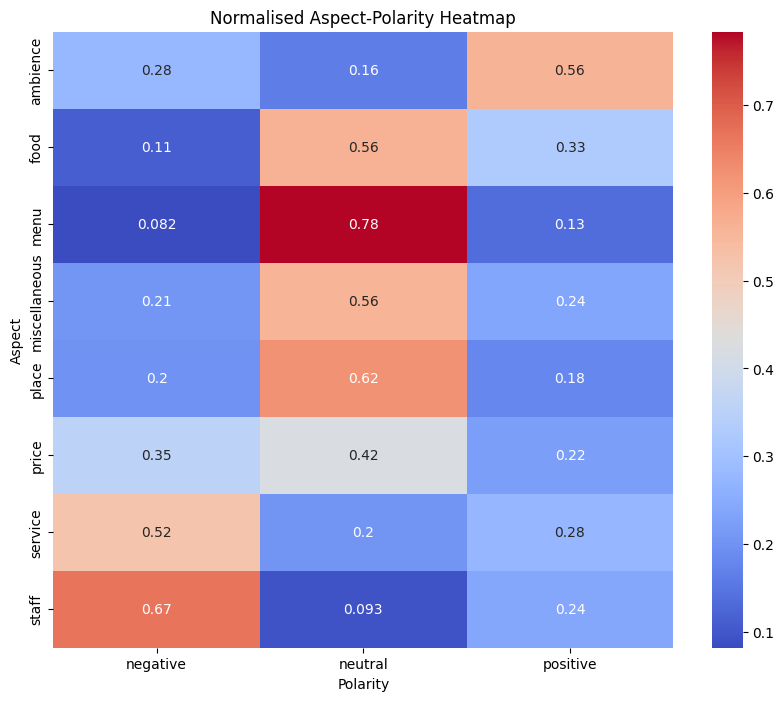

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(aspect_polarity_crosstab_normalised, annot=True, cmap='coolwarm')
plt.title('Normalised Aspect-Polarity Heatmap')
plt.xlabel('Polarity')
plt.ylabel('Aspect')
plt.show()

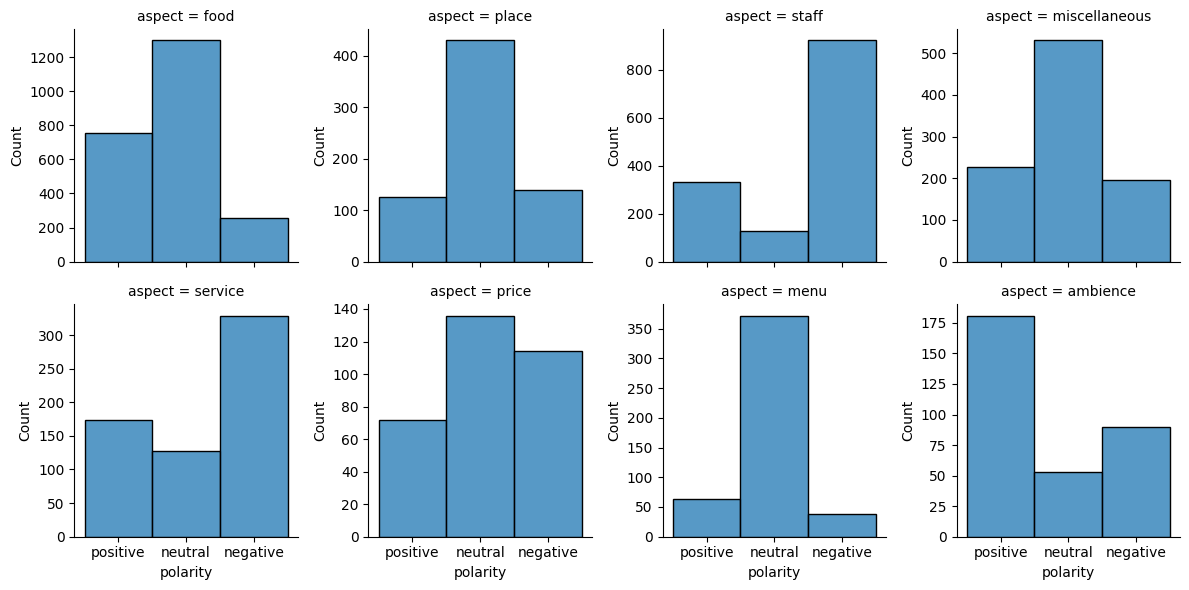

In [ ]:
g = sns.FacetGrid(train_df, col='aspect', col_wrap=4, sharey=False)
g.map(sns.histplot, 'polarity')
plt.show()

### 1.2.5 Word Frequency

Identifying the most common words will help us to understand common themes and/or biases.

We will also check the most common words for each aspect category, which may give us further insights into the content of each aspect.

We will compare this with and without stopwords.

In [ ]:
reviews = train_df['sentence'].drop_duplicates()

# most common tokens, without stopwords
sw = set(stopwords.words('english'))
tokens = [word.lower() for review in reviews for word in word_tokenize(review) if word.isalpha() and word.lower() not in sw]
word_count = Counter(tokens)
common_words_without_sw = word_count.most_common(30)

# most common tokens, with stopwords
common_words_with_sw = [word.lower() for review in reviews for word in word_tokenize(review) if word.isalpha()]
word_count_with_sw = Counter(common_words_with_sw)
common_words_with_sw = word_count_with_sw.most_common(30)

<ipython-input-31-0c38dcc5b9ea>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_without_sw, y=words_without_sw, ax=ax[0], palette=colors_without_sw)
<ipython-input-31-0c38dcc5b9ea>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_with_sw, y=words_with_sw, ax=ax[1], palette=colors_with_sw)


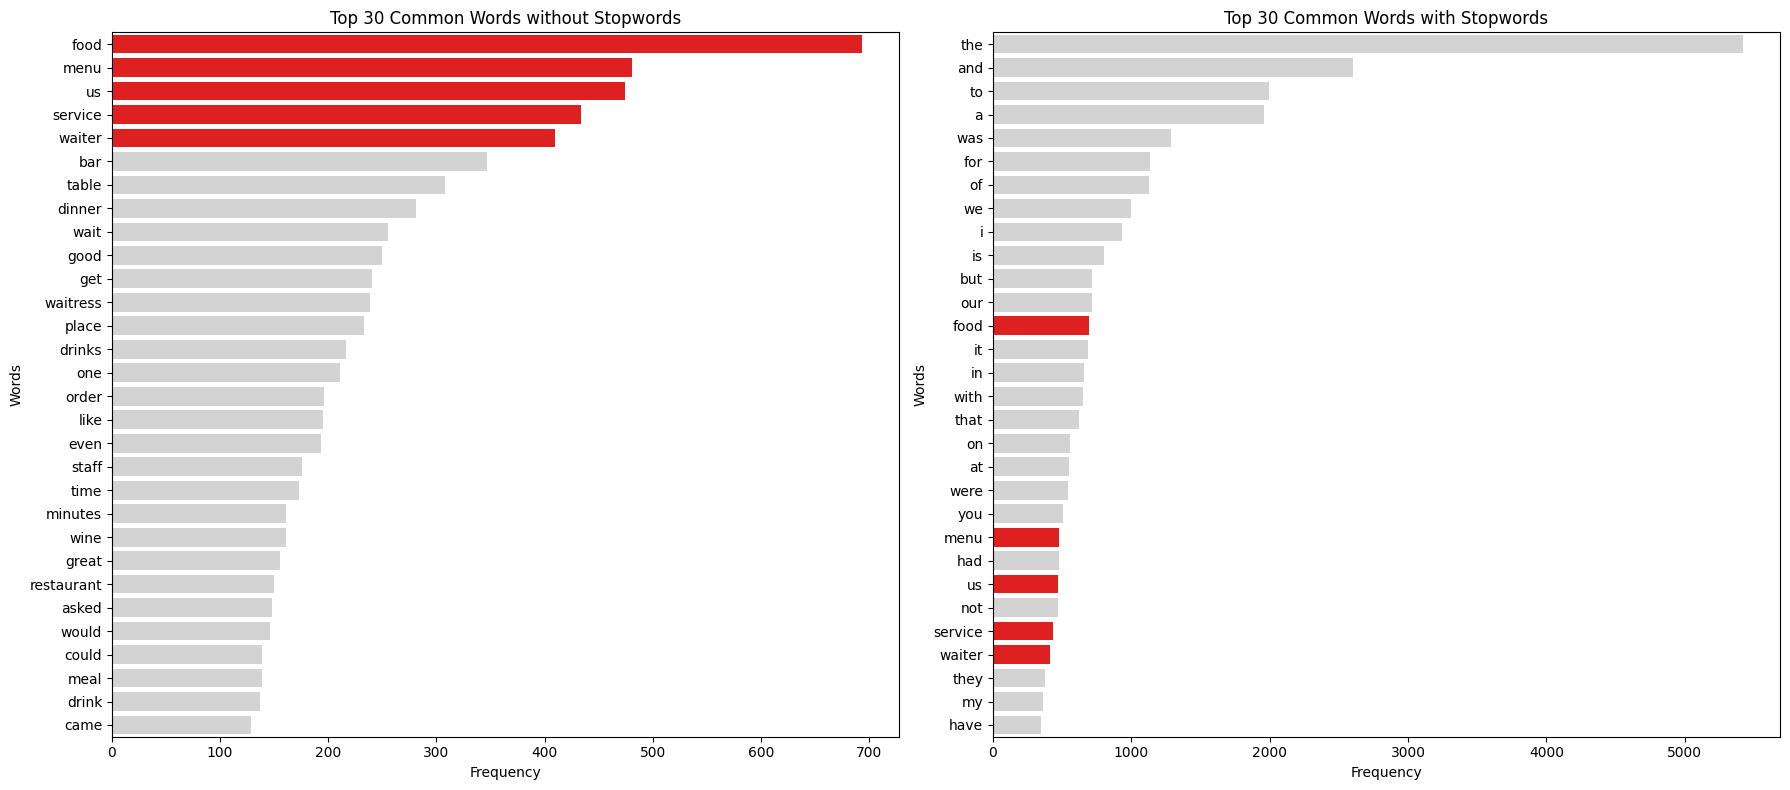

In [ ]:
# Highlight common words in both lists
common_words = set(w[0] for w in common_words_without_sw) & set(w[0] for w in common_words_with_sw)

words_without_sw = [w[0] for w in common_words_without_sw]
counts_without_sw = [w[1] for w in common_words_without_sw]
colors_without_sw = ['red' if word in common_words else 'lightgrey' for word in words_without_sw]

words_with_sw = [w[0] for w in common_words_with_sw]
counts_with_sw = [w[1] for w in common_words_with_sw]
colors_with_sw = ['red' if word in common_words else 'lightgrey' for word in words_with_sw]

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# plot words without stopwords
sns.barplot(x=counts_without_sw, y=words_without_sw, ax=ax[0], palette=colors_without_sw)
ax[0].set_title('Top 30 Common Words without Stopwords')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Words')

# plotting words with stopwords
sns.barplot(x=counts_with_sw, y=words_with_sw, ax=ax[1], palette=colors_with_sw)
ax[1].set_title('Top 30 Common Words with Stopwords')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Words')

plt.tight_layout()
plt.show()

### 1.2.6 POS Tags

[NLTK POS](https://www.nltk.org/book/ch05.html)



In [ ]:
reviews.reset_index(drop=True, inplace=True)
# review with proper nouns
reviews[1170]

'Music is a nice mix of everything from Aerosmith to James Brown to Metallica to disco to whatever else there is.'

In [ ]:
### todo: probably remove this.. was just testing, but it could be good for documenation?

import spacy

# load the English NLP model
nlp = spacy.load('en_core_web_sm')

# process a review
doc = nlp(reviews[1170])

# display tokens and their POS tags
for token in doc:
    print(token.text, token.pos_)

Music NOUN
is AUX
a DET
nice ADJ
mix NOUN
of ADP
everything PRON
from ADP
Aerosmith PROPN
to ADP
James PROPN
Brown PROPN
to ADP
Metallica PROPN
to PART
disco VERB
to ADP
whatever PRON
else ADV
there PRON
is VERB
. PUNCT


In [ ]:
t1 = word_tokenize(reviews[1170])
nltk.pos_tag(t1)

[('Music', 'NNP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('nice', 'JJ'),
 ('mix', 'NN'),
 ('of', 'IN'),
 ('everything', 'NN'),
 ('from', 'IN'),
 ('Aerosmith', 'NNP'),
 ('to', 'TO'),
 ('James', 'NNP'),
 ('Brown', 'NNP'),
 ('to', 'TO'),
 ('Metallica', 'NNP'),
 ('to', 'TO'),
 ('disco', 'VB'),
 ('to', 'TO'),
 ('whatever', 'VB'),
 ('else', 'RB'),
 ('there', 'EX'),
 ('is', 'VBZ'),
 ('.', '.')]

There are a lot of plurals, gendered terms and words that are mispelt, sometimes for emphasis.

In [ ]:
words_of_interest = ['sushiden', 'vallenciana', 'brusque', 'cornelia', 'po', 'par', 'ouor', 'sushiden', 'j', 'erk', 'mac', 'jack', 'faves']
plurals_gendered = ['host', 'hostess', 'waiter', 'waiters', 'customers']

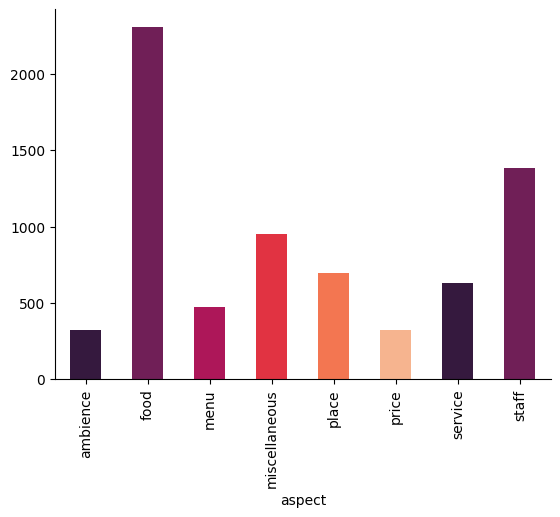

In [ ]:
train_df.groupby('aspect').size().plot(kind='bar', color=sns.color_palette("rocket"))
plt.gca().spines[['top', 'right',]].set_visible(False)

## 1.3 Text Preprocessing





### 1.3.1 Numeric Data Handling

The dataset contains numeric data which will require standardising to manage the vocabulary size. We experiment with two ways of handling this, using number-to-word conversion, and using tagging.

In [ ]:
test_sentences = [
    "Went here for a casual Sunday night dinner at 7:45pm; dinner was served at 10:15pm!",
    "We ordered 2 dishes, but only got 1 at 6:30 and waited for 25min",
    "In the 2020s and it costs 100pp?", # pp and plural
    "I woke up at 7:45 am and ran for 30min.",
    "The event starts at 5pm on the 21st of September.",
    "She was born in the 90s, and she feels like she's still in her 20s.",
    "The temperature is expected to be 80ish degrees tomorrow.",
    "John finished 3rd in the marathon and took home $1000.",
    "The building was constructed in the 1950s.",
    "Meet me at 12:30 or around 1ish.",
    "The project took 2hrs and was completed in the early 2000s.",
    "They moved here in the late 70s and celebrated their 50th anniversary.",
    "The store is open from 8am to 11pm daily.",
    "The match was intense, but he scored in the 57th minute.",
    "She practices piano 3times a week for 1hour each session.",
    "He lived through the 60s and remembers the moon landing vividly.",
    "Her appointment is scheduled for 9:00 and she'll be 1st."
]

In [ ]:
# numeric data cases not captured by a simple conversion method
num_data_cases = ['1940s', '8ish', '80s', '1950s', '5pm', '3am', '32nd', '35pp',
                     '11pm', '8pm', '3pm', '3times', '40times', '1pm', '57th', '1hour',
                     '2000ish', '4th', '70s', '125pp', '15th', '2nd', '9pm', '1st', '3rd',
                     '1hr', '10yrs', '100pp', '5x']

In [ ]:
# converted sentences structure
for sentence in test_sentences[0:3:]:
  print(handle_numeric_data(sentence, method='convert'))

Went here for a casual Sunday night dinner at seven forty-five pm; dinner was served at ten fifteen pm!
We ordered two dishes, but only got one at six thirty  and waited for twenty-five minutes
In the two thousand and twentys and it costs one hundred per person?


In [ ]:
# tagged sentences structure
for sentence in test_sentences[0:3:]:
  print(handle_numeric_data(sentence, method='tag'))

Went here for a casual Sunday night dinner at <TIME>; dinner was served at <TIME>!
We ordered <NUM> dishes, but only got <NUM> at <TIME> and waited for <NUM>
In the <NUM>s and it costs <NUM>?


### 1.3.1 Process Data

In [ ]:
# Preprocessing modularised components


## 1.4 Vocabulary, encoding and embedding functions

In [ ]:
def get_vocab(config, sentences, aspects, saving=False):
    '''
    Function to return a dictionary of unique words and their respective indices.
    sentences (list): expects a list of lists of tokens (i.e., each sentence is already tokenized into words).
    aspects (set): train_aspects
    '''
    vocab_path = os.path.join(config['base_path'], f"{config['experiment_name']}_vocab.pkl")
    # Load vocab from file if it exists
    if saving and os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            vocab = pickle.load(f)
        print(f"Vocab loaded from {vocab_path}")
        return vocab

    else:
        # Get unique words from sentences and aspects
        unique_words = {word for sent in sentences for word in sent}

        unique_words.update(aspects)
        vocab = {"[PAD]": 0, "[SEP]": 1, "[UNK]": 2}
        for idx, word in enumerate(unique_words, start=3):
            vocab[word] = idx

        # Save vocab to file
        if saving:
          print(f"Vocab saved to {vocab_path}")
          with open(vocab_path, 'wb') as f:
              pickle.dump(vocab, f)

        return vocab

def get_emb_matrix(config, vocab):
    '''
    Populate the embedding matrix by looking up each word in the vocabulary and getting its corresponding
    embedding vector from the pretrained model. As a result, each row in the matrix
    corresponds to a unique word in the vocab, indexed in the same order as the vocab,
    representing a pretrained embedding (e.g. GloVe vector) for that word.
    Can also choose higher dimension model (100-200) at the cost of performance

    Args:
    config (dict): Configuration containing settings and paths.
    vocab (dict): Vocabulary with words and their indices.

    Returns:
    tuple: A tuple containing the embedding matrix and a dict of OOV words amd their indices in vocab.
    '''
    word_emb_model_path = os.path.join(config['base_path'], f"word_emb_model_{config['word_emb_model_embedding_dim']}.pkl")

    try:
        # Attempt to load pre-trained embedding model
        if os.path.exists(word_emb_model_path):
            with open(word_emb_model_path, 'rb') as f:
                word_emb_model = pickle.load(f)
            print(f"Word embedding model loaded from {word_emb_model_path}")
        else:
            # Download pre-trained embedding model
            word_emb_model = api.load(f"glove-twitter-{config['word_emb_model_embedding_dim']}")
            with open(word_emb_model_path, 'wb') as f:
                pickle.dump(word_emb_model, f)
            print(f"Word embedding model saved to {word_emb_model_path}")
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

    # initialise matrix with zeros
    embedding_dim = word_emb_model.vector_size
    emb_matrix = np.zeros((len(vocab), embedding_dim))

    # dict to store OOV words and their indices
    oov_words = {}
    # populate matrix with pretrained embeddings
    for word, idx in vocab.items():
        if word == "[PAD]":
            emb_matrix[idx] = np.zeros(embedding_dim) # set to 0 vector so it does not carry semantic info
        elif word in word_emb_model:
            emb_matrix[idx] = word_emb_model[word]
        else:
            # Randomly initialise the embedding for words OOV and "[SEP]"
            # scale SD of OOV so that attention isn't affecting
            # todo: refer to published work?
            emb_matrix[idx] = np.random.normal(size=embedding_dim, scale= 0.1)
            oov_words[word] = idx  # Collect word and index if OOV

    return emb_matrix, oov_words

def encode_sentences(sentences, vocab):
    '''
    Convert each word in a sentence to its correspond index in the vocab.
    (e.g. "food" -> vocab["food"] -> 6030 )
    OOV wrods are mapped to vocab["[UNK]"] index.

    Args:
        sentences (list of list of str): A list of sentences, where each sentence
            is a list of word tokens.
        vocab (dict): A dictionary mapping words to unique indices.

    Returns:
        tuple: A tuple containing:
            - encoded_sents (list of list of int): A list of sentences with words
              encoded as integers according to the vocab dictionary.
            - oov_words (list of str): A list of words that were not found in the
              vocabulary.
    Note:
        This is an alternate to sparse one-hot encoded vectors for the vocab
    '''
    encoded_sents = []
    oov_words = set()
    for sent in sentences:
        # temp = [vocab.get(word, vocab["[UNK]"]) for word in sent]
        # this line of code is better, but the loop below is used to print OOV words in the validation and test set
        enc_sent = []
        # oov_words = []
        for word in sent:
            if word in vocab:
                enc_sent.append(vocab[word])
            else:
                enc_sent.append(vocab["[UNK]"])
                oov_words.add(word) # collect OOV words
        encoded_sents.append(enc_sent)
    return encoded_sents, list(oov_words)

def pad_sequences(seq_list, pad_token):
    '''
    padding length determined dynamically based on the longest sequence in `seq_list`.
    '''
    # Pad each sequence to the maximum length
    sequence_tensors = [torch.tensor(seq) for seq in seq_list]

    # Using PyTorch's pad_sequence function
    padded_sequences = pad_sequence(sequence_tensors, batch_first=True, padding_value=pad_token)
    return padded_sequences


def concat_aspect(sentences, aspects, vocab):
    '''
    Function to concatenate each sentence and its aspect with a separator token in between.
    '''
    aspect_indices = [vocab[aspect] for aspect in aspects]
    concat_sent_aspect = [sent + [vocab["[SEP]"]] + [asp_idx] for sent, asp_idx in zip(sentences, aspect_indices)]
    return concat_sent_aspect

def encode_all_labels(train_df, val_df, test_df):
    '''
    encode sentiment labels
    '''
    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    train_labels = [label_map[label] for label in train_df['polarity']]
    val_labels = [label_map[label] for label in val_df['polarity']]
    test_labels = [label_map[label] for label in test_df['polarity']]

    return train_labels, val_labels, test_labels

# 2.Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Model Training and Model Evaluation functions

In [ ]:
def load_checkpoint_if_exists(model_path, model, optimizer):
    latest_checkpoint_path = os.path.join(model_path, 'final_model_state.pth')
    if os.path.exists(latest_checkpoint_path):
        checkpoint = torch.load(latest_checkpoint_path, map_location=device)
        model_dict = model.state_dict()
        checkpoint_dict = checkpoint['model_state_dict']

        # Check if the embedding layer size matches before loading
        if model_dict['embedding.weight'].shape == checkpoint_dict['embedding.weight'].shape:
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Loaded model from {latest_checkpoint_path}")
            return True
        else:
            print(f"Size mismatch for embedding weights, not loading checkpoint. Expected {model_dict['embedding.weight'].shape}, found {checkpoint_dict['embedding.weight'].shape}")
            return False
    else:
        print("No checkpoint found, starting training from scratch.")
        return False


# Functions to train and evaluate models
def train(model, train_loader, val_loader, optimizer, loss_function, num_epochs, config, has_attention=True, validation=True):
    '''
    returns training and validation losses and accuracies for visualisation.
    has_attention flag to determine if model has attention layer for visualisng.
    '''
    # init training options
    config_str = f"{config['experiment_name']}"
    model_path = os.path.join(config['base_model_path'], config_str)
    saving = config.get('save_model', False)  # save to disk
    loading = config.get('load_model', False) # load from file
    visualise_training = config.get('visualise_training', True)
    return_output = config.get('return_output', False)

    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # Check if model has already been trained and load if exists
    if loading and load_checkpoint_if_exists(model_path, model, optimizer):
        print(f"Model loaded from {model_path} using load_checkpoint.")
        return  # Exit if model was loaded successfully

    # Lists to store metrics for visualization
    training_losses, validation_losses, training_accuracies, validation_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train() # set model to training mode
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for batch in train_loader:
            # Reset gradients
            optimizer.zero_grad()

            # For model 1's inputs (sentence+aspect, labels)
            if len(batch) == 2:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device) # ensure computations performed on GPU if available
                if has_attention:
                    outputs, attention_scores = model(inputs)
                else:
                    outputs = model(inputs) # make predictions

            # For model 2's inputs (sentence, aspect, labels)
            elif len(batch) == 3:
                sentences, aspects, labels = batch
                sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)
                if has_attention:
                    outputs, attention_scores = model(sentences, aspects) # make predictions
                else:
                    outputs = model(sentences, aspects) # make predictions

            # Calculate loss and perform backpropagation
            loss = loss_function(outputs, labels) # calculate loss
            loss.backward() # calculate gradients
            optimizer.step() # update model parameters

            # Add loss to total_loss
            total_loss += loss.item()
            # Add correct predictions to total_correct
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # training_accuracies.append(total_correct / total_samples * 100) FIXME: redundant? also appended to the list in the next block

        # scheduler.step() # update learning rate

        # Compute and print average training loss and accuracy
        train_loss = total_loss / len(train_loader)
        training_losses.append(train_loss)
        train_acc = total_correct / len(train_loader.dataset) * 100
        training_accuracies.append(train_acc)

        print(f"Epoch {epoch+1}:")
        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

        # Evaluate on validation set
        if validation:
            eval_loss, eval_acc, all_labels, all_predictions = evaluate(model, val_loader, loss_function, val=True, return_output=True, has_attention=has_attention)
            validation_losses.append(eval_loss)
            validation_accuracies.append(eval_acc)
        else:
            eval_loss, eval_acc, validation_losses, validation_accuracies = None, None, None, None

    if saving:
        # save model state, optimiser state and results at end of training
        final_model_save_path = os.path.join(model_path, "final_model_state.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'eval_loss': eval_loss,
            'eval_accuracy': eval_acc,
            'training_losses': training_losses,
            'validation_losses': validation_losses,
            'training_accuracies': training_accuracies,
            'validation_accuracies': validation_accuracies

        }, final_model_save_path)
        print(f"Final model saved to {final_model_save_path}")

        # save configuration file
        config_path = os.path.join(model_path, 'model_config.json')
        print(f"Model config saved to {config_path}")
        with open(config_path, 'w') as fp:
            json.dump(config, fp, indent=4)

    # visualise the training and validation results
    if visualise_training:
        visualise_model_training(training_losses, validation_losses, training_accuracies, validation_accuracies)

    if return_output:
        return training_losses, validation_losses, training_accuracies, validation_accuracies


def evaluate(model, test_loader, loss_function, val=False, return_output=False, has_attention=True):
    '''
    Returns evaluation loss, accuracy, and all labels and predictions.
    '''
    model.eval() # set model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    # Lists to store actual and predicted labels
    all_labels = []
    all_predictions = []

    with torch.no_grad(): # do not accumulate gradients
        for batch in test_loader:
            if len(batch) == 2:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                if has_attention:
                    outputs, attention_scores = model(inputs)
                else:
                    outputs = model(inputs) # make predictions
            elif len(batch) == 3:
                sentences, aspects, labels = batch
                sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)
                if has_attention:
                    outputs, attention_scores = model(sentences, aspects)
                else:
                    outputs = model(sentences, aspects) # make predictions

            # Calculate loss
            loss = loss_function(outputs, labels)
            # Add loss to total_loss
            total_loss += loss.item()
            # Add correct predictions to total_correct
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()

            # collect all labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute and print average evaluation loss and accuracy
    eval_loss = total_loss / len(test_loader)
    eval_acc = total_correct / len(test_loader.dataset) * 100

    dataset_name = "Validation" if val == True else "Test"
    print(f"{dataset_name} Loss: {eval_loss:.4f}, {dataset_name} Accuracy: {eval_acc:.2f}%")

    if return_output:
        return eval_loss, eval_acc, all_labels, all_predictions
    else:
        return eval_loss, eval_acc

## Baseline model (predicts the majority class)

This model will predict the majority class (in the training set) of each aspect.

The results from this model will be used to compare with the proposed neural network models.

Majority class in each aspect
aspect
ambience         positive
food              neutral
menu              neutral
miscellaneous     neutral
place             neutral
price             neutral
service          negative
staff            negative
dtype: object

Performance metrics for baseline model:
Accuracy: 0.5871254162042175
Precision (Macro): 0.5315464296097652
Recall (Macro): 0.5169759611388166
F1-Score (Macro): 0.46580900005962794
Precision (Weighted): 0.5429520748693469
Recall (Weighted): 0.5871254162042175
F1-Score (Weighted): 0.510938887734529
Confusion Matrix:


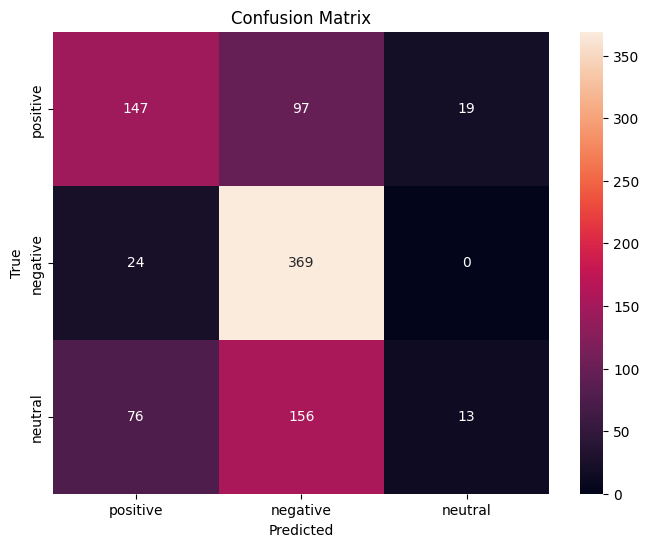

In [ ]:
# Get the majority class for each aspect
aspect_polarity_crosstab = pd.crosstab(train_df['aspect'], train_df['polarity'])
majority_class = aspect_polarity_crosstab.idxmax(axis=1)
print("Majority class in each aspect")
print(majority_class)

# Predict sentiment polarity in test set
baseline_model_pred = [majority_class[aspect] for aspect in test_df['aspect']]

# Encode sentiment labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

baseline_y_pred = [label_map[sentiment] for sentiment in baseline_model_pred]
test_y_true = [label_map[sentiment] for sentiment in test_df['polarity']]

# Calculate performance metrics
print("\nPerformance metrics for baseline model:")
baseline_metrics = get_training_stats(test_y_true, baseline_y_pred, print_stats=True)

## Model 1: (concatenate sentence and aspect, no attention)

Concatenates the sentence, a separator token and the aspect together. This is fed into a bidirectional LSTM network to predict the sentiment.

In [ ]:
# Prepare data

# set random seed for initialising OOV embeddings
set_seed(4012)

# Process training, validation and test sets
train_sents = text_pre_processing(config, train_df['sentence'], "train", saving=False)
val_sents = text_pre_processing(config, val_df['sentence'],   "val", saving=False)
test_sents = text_pre_processing(config, test_df['sentence'],  "test", saving=False)

# Encode labels
train_labels, val_labels, test_labels = encode_all_labels(train_df, val_df, test_df)

# load vocab
train_aspects = set(train_df['aspect'])
vocab = get_vocab(config, sentences=train_sents, aspects=train_aspects, saving=True)
vocab_size = len(vocab)
print(f"The vocab size is {vocab_size}")

# Convert words to their corresponding index in the vocabulary
train_sents_enc, train_oov_words = encode_sentences(train_sents, vocab)
val_sents_enc, val_oov_words = encode_sentences(val_sents, vocab)
test_sents_enc, test_oov_words = encode_sentences(test_sents, vocab)

# Concatenate the sentence and aspect
train_concat = concat_aspect(train_sents_enc, list(train_df['aspect']), vocab)
val_concat = concat_aspect(val_sents_enc, list(val_df['aspect']), vocab)
test_concat = concat_aspect(test_sents_enc, list(test_df['aspect']), vocab)

# Pad the sequences up to the maximum sequence length
train_padded = pad_sequences(train_concat, vocab["[PAD]"])
val_padded = pad_sequences(val_concat, vocab["[PAD]"])
test_padded = pad_sequences(test_concat, vocab["[PAD]"])

# Get the embedding matrix
emb_matrix, emb_oov_words = get_emb_matrix(config, vocab)
embedding_dim = emb_matrix.shape[-1]
print(f"{len(emb_oov_words)} words are OOV in the {config['word_emb_model']}{config['word_emb_model_embedding_dim']} pretrained model.")

Vocab loaded from /content/drive/My Drive/CITS4012_NLP/data/processed/_vocab.pkl
The vocab size is 6479
Word embedding model loaded from /content/drive/My Drive/CITS4012_NLP/data/processed/word_emb_model_50.pkl
505 words are OOV in the glove-twitter-50 pretrained model.


In [ ]:
# initialise model hyperparams
base_model_config = {
    'model_type': 'BiLSTM_concat',
    'vocab_size': len(vocab),
    'embedding_dim': emb_matrix.shape[-1],
    'hidden_dim': 256,              # hidden dimension of Bi-LSTM layer
    'output_dim': 3,                # 3 sentiment classes
    'batch_size': 128,              # batch size for training
    'learning_rate': 0.007,
    'num_epochs': 20,
    'experiment_log_details': '',   # experiment context (informal)
    'visualise_training': False,
}

# init config for models
config = create_experiment_config(config, base_model_config, base_model_config['model_type'])

In [ ]:
# Prepare DataLoader
  # Allows model to be trained in batches, which is more efficient than feeding all
  # data at once. DataLoader handles automatic batching and shuffling of data.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

set_seed(4012) # ensure random seed is set

m1_train_data = TensorDataset(train_padded, torch.tensor(train_labels, dtype=torch.long))
m1_train_loader = DataLoader(dataset=m1_train_data, batch_size=config['batch_size'], shuffle=True)

m1_val_data = TensorDataset(val_padded, torch.tensor(val_labels, dtype=torch.long))
m1_val_loader = DataLoader(dataset=m1_val_data, batch_size=config['batch_size'], shuffle=False)

m1_test_data = TensorDataset(test_padded, torch.tensor(test_labels, dtype=torch.long))
m1_test_loader = DataLoader(dataset=m1_test_data, batch_size=config['batch_size'], shuffle=False)

In [ ]:
# Model definition
class BiLSTMConcatAspect(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, emb_weights):
        super(BiLSTMConcatAspect, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # create embedding layer
        self.embedding.weight.data.copy_(torch.from_numpy(emb_weights)) # initialise embedding layer with pretrained weights
        self.embedding.weight.requires_grad = False # freeze embeddings so they cannot be updated during training
        # Bi-LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        # Output layer (linear)
        self.linear = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_output, h_n = self.lstm(embedded)
        last_output = lstm_output[:, -1, :] # the last hidden state of the LSTM cell
        # This is the same as:
        # last_forward = h_n[0, :, :]
        # last_backward = h_n[1, :, :]
        # last_output = torch.cat((last_forward, last_backward), dim=1)

        output = self.linear(last_output)
        return output

# Initialise model
model_1 = BiLSTMConcatAspect(config['vocab_size'], config['embedding_dim'], config['hidden_dim'], config['output_dim'], emb_matrix).to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=config['learning_rate'])

In [ ]:
# Training
train(model_1, m1_train_loader, m1_val_loader, optimizer, loss_function, config['num_epochs'], config, has_attention=False)

Epoch 1:
Training Loss: 1.0793, Training Accuracy: 43.39%
Validation Loss: 1.0789, Validation Accuracy: 43.69%
Epoch 2:
Training Loss: 1.0778, Training Accuracy: 43.43%
Validation Loss: 1.0814, Validation Accuracy: 43.58%
Epoch 3:
Training Loss: 1.0779, Training Accuracy: 43.43%
Validation Loss: 1.0827, Validation Accuracy: 43.58%
Epoch 4:
Training Loss: 1.0772, Training Accuracy: 43.44%
Validation Loss: 1.0779, Validation Accuracy: 43.69%
Epoch 5:
Training Loss: 1.0769, Training Accuracy: 43.44%
Validation Loss: 1.0770, Validation Accuracy: 43.69%
Epoch 6:
Training Loss: 1.0776, Training Accuracy: 43.22%
Validation Loss: 1.0746, Validation Accuracy: 43.69%
Epoch 7:
Training Loss: 1.0767, Training Accuracy: 43.44%
Validation Loss: 1.0800, Validation Accuracy: 43.69%
Epoch 8:
Training Loss: 1.0757, Training Accuracy: 43.48%
Validation Loss: 1.0743, Validation Accuracy: 43.69%
Epoch 9:
Training Loss: 1.0843, Training Accuracy: 42.37%
Validation Loss: 1.0753, Validation Accuracy: 43.69%
E

In [ ]:
# Evaluate model
test_loss, test_acc, y_true, y_pred = evaluate(model_1, m1_test_loader, loss_function, val=False, return_output=True, has_attention=False)

Test Loss: 0.8462, Test Accuracy: 64.15%


In [ ]:
# get model metrics
model_1_metrics = get_training_stats(y_true, y_pred, print_stats=False)
model_1_metrics

(0.6415094339622641,
 0.6229363125377433,
 0.6067455134415921,
 0.6097909718646557,
 0.633360389840557,
 0.6415094339622641,
 0.6321145107416937,
 array([[141,  63,  59],
        [ 33, 325,  35],
        [ 46,  87, 112]]))

### M1 Ablation studies

#### Learning rate and number of epochs
* LR = 0.01 does not converge after 30 epochs. Training and validation accuracy stays consistent around 40%
* LR = 0.001 does not converge after 30 epochs, but training and validation accuracy increases to ~ 50%.
* LR = 0.005 appears to converges after 20 epochs, traning and validation accuracy increases to ~ 60%
* **LR = 0.007** converges after 15 epochs, training and validation accuracy 63%


#### Self-attention

Test different ways to incorporate and pass attention to the output layer.

1. Using last output of attention
  * Compared to model without attention, converges much quicker after 6 epochs.
2. Concat attention output and LSTM's last hidden state (same as lectures for encoder/decoder task)
  * Converges quickly as well after 6 epochs.
3. Averaging attention output
  * Does not converge.
4. Max pooling attention output
  * Converges after 7 epochs.




In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        # Linear transformations to map the input embeddings into queries, keys and values.
          # Queries and keys are used to calculate similarity of each word to every other word.
          # Values are used to get the weighted output.
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        # Softmax applied to normalise attention scores into probabilities
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        # Apply transformations to x to get queries, keys and values
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        # Compute the dot products of queries and keys to get raw attention scores
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        # Apply softmax to get attention distribution
        attention = self.softmax(scores)
        # Multiply attention weights by values to get context vectors
        weighted = torch.bmm(attention, values)

        # return weighted
        return weighted, attention

class BiLSTMConcatAspectAtt(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, emb_weights, attn_option):
        super(BiLSTMConcatAspectAtt, self).__init__()
         # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(emb_weights))
        self.embedding.weight.requires_grad = False
        # Bi-LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        # Self-attention layer
        self.attention = SelfAttention(hidden_dim * 2)
        self.attn_option = attn_option
        # Output layer
        if self.attn_option == "concat":
            # if concat attn output and LSTM last hidden state
            self.linear = nn.Linear(hidden_dim * 4, output_dim)
        else:
            self.linear = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_output, _ = self.lstm(embedded)
        attn_output, attention = self.attention(lstm_output)

        # Different options for how to incorporate attention:
        if self.attn_option == "last":
            # using last output of attention
            final_hidden = attn_output[:, -1, :]
        elif self.attn_option == "concat":
            # concat attention output and LSTM's last hidden state (same as lectures)
            final_hidden = torch.cat((attn_output[:, -1, :], lstm_output[:, -1, :]), dim=1)
        elif self.attn_option == "averaging":
            # using averaging
            final_hidden = torch.mean(attn_output, dim=1)
        elif self.attn_option == "maxpool":
            # using max pooling
            final_hidden = torch.max(attn_output, dim=1)[0]

        output = self.linear(final_hidden)

        # return output
        return output, attention

# Define hyperparameters
embedding_dim = emb_matrix.shape[-1]
hidden_dim = 256 # hidden dimension of Bi-LSTM layer
output_dim = 3 # 3 sentiment classes
vocab_size = len(vocab)
learning_rate = 0.007
num_epochs = 10

##### 1a. Using last output of attention

In [ ]:

model_1a = BiLSTMConcatAspectAtt(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "last").to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1a.parameters(), lr=learning_rate)

train(model_1a, m1_train_loader, m1_val_loader, optimizer, loss_function, config['num_epochs'], config)
print()
test_loss, test_acc, y_true_1a, y_pred_1a = evaluate(model_1a, m1_test_loader, loss_function, val=False, return_output=True)
model_1a_metrics = get_training_stats(y_true_1a, y_pred_1a, print_stats=False)

Epoch 1:
Training Loss: 1.0578, Training Accuracy: 46.25%
Validation Loss: 1.0147, Validation Accuracy: 56.87%
Epoch 2:
Training Loss: 0.9420, Training Accuracy: 56.09%
Validation Loss: 0.8823, Validation Accuracy: 58.22%
Epoch 3:
Training Loss: 0.8629, Training Accuracy: 60.04%
Validation Loss: 0.8981, Validation Accuracy: 61.49%
Epoch 4:
Training Loss: 0.8307, Training Accuracy: 62.91%
Validation Loss: 0.8110, Validation Accuracy: 62.50%
Epoch 5:
Training Loss: 0.7914, Training Accuracy: 64.67%
Validation Loss: 0.7964, Validation Accuracy: 64.19%
Epoch 6:
Training Loss: 0.7726, Training Accuracy: 64.92%
Validation Loss: 0.7719, Validation Accuracy: 64.64%
Epoch 7:
Training Loss: 0.7196, Training Accuracy: 67.09%
Validation Loss: 0.8029, Validation Accuracy: 65.88%
Epoch 8:
Training Loss: 0.6871, Training Accuracy: 69.82%
Validation Loss: 0.8088, Validation Accuracy: 64.86%
Epoch 9:
Training Loss: 0.6404, Training Accuracy: 71.65%
Validation Loss: 0.7804, Validation Accuracy: 64.86%
E

##### 1b. Concat attention output and LSTM's last hidden state
(same as lectures for encoder/decoder task)

In [ ]:
model_1b = BiLSTMConcatAspectAtt(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "concat").to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1b.parameters(), lr=learning_rate)

train(model_1b, m1_train_loader, m1_val_loader, optimizer, loss_function, num_epochs, config)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_1b, m1_test_loader, loss_function, val=False, return_output=True)
model_1b_metrics = get_training_stats(y_true, y_pred, print_stats=False)

Epoch 1:
Training Loss: 1.0645, Training Accuracy: 44.71%
Validation Loss: 1.0092, Validation Accuracy: 52.36%
Epoch 2:
Training Loss: 0.9032, Training Accuracy: 60.30%
Validation Loss: 0.8765, Validation Accuracy: 59.35%
Epoch 3:
Training Loss: 0.8605, Training Accuracy: 62.07%
Validation Loss: 0.8368, Validation Accuracy: 62.50%
Epoch 4:
Training Loss: 0.8243, Training Accuracy: 63.48%
Validation Loss: 0.8031, Validation Accuracy: 64.41%
Epoch 5:
Training Loss: 0.7851, Training Accuracy: 64.88%
Validation Loss: 0.7964, Validation Accuracy: 63.96%
Epoch 6:
Training Loss: 0.7641, Training Accuracy: 66.74%
Validation Loss: 0.7739, Validation Accuracy: 64.19%
Epoch 7:
Training Loss: 0.7210, Training Accuracy: 67.80%
Validation Loss: 0.7871, Validation Accuracy: 66.67%
Epoch 8:
Training Loss: 0.6845, Training Accuracy: 70.41%
Validation Loss: 0.8096, Validation Accuracy: 64.41%
Epoch 9:
Training Loss: 0.6565, Training Accuracy: 71.62%
Validation Loss: 0.7736, Validation Accuracy: 65.32%
E

##### 1c. Averaging attention

In [ ]:
model_1c = BiLSTMConcatAspectAtt(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "averaging").to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1a.parameters(), lr=learning_rate)

train(model_1c, m1_train_loader, m1_val_loader, optimizer, loss_function, num_epochs, config)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_1c, m1_test_loader, loss_function, val=False, return_output=True)
model_1c_metrics = get_training_stats(y_true, y_pred, print_stats=False)

Epoch 1:
Training Loss: 1.0971, Training Accuracy: 43.47%
Validation Loss: 1.0968, Validation Accuracy: 43.69%
Epoch 2:
Training Loss: 1.0971, Training Accuracy: 43.47%
Validation Loss: 1.0968, Validation Accuracy: 43.69%
Epoch 3:
Training Loss: 1.0970, Training Accuracy: 43.47%
Validation Loss: 1.0968, Validation Accuracy: 43.69%
Epoch 4:
Training Loss: 1.0970, Training Accuracy: 43.47%
Validation Loss: 1.0968, Validation Accuracy: 43.69%
Epoch 5:
Training Loss: 1.0971, Training Accuracy: 43.47%
Validation Loss: 1.0968, Validation Accuracy: 43.69%
Epoch 6:
Training Loss: 1.0970, Training Accuracy: 43.47%
Validation Loss: 1.0968, Validation Accuracy: 43.69%
Epoch 7:
Training Loss: 1.0971, Training Accuracy: 43.47%
Validation Loss: 1.0968, Validation Accuracy: 43.69%
Epoch 8:
Training Loss: 1.0970, Training Accuracy: 43.47%
Validation Loss: 1.0968, Validation Accuracy: 43.69%
Epoch 9:
Training Loss: 1.0970, Training Accuracy: 43.47%
Validation Loss: 1.0968, Validation Accuracy: 43.69%
E

##### 1d. Max pooling attention

In [ ]:

model_1d = BiLSTMConcatAspectAtt(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "maxpool").to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1d.parameters(), lr=learning_rate)

train(model_1d, m1_train_loader, m1_val_loader, optimizer, loss_function, num_epochs, config)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_1d, m1_test_loader, loss_function, val=False, return_output=True)
model_1d_metrics = get_training_stats(y_true, y_pred, print_stats=False)

Epoch 1:
Training Loss: 0.9801, Training Accuracy: 53.98%
Validation Loss: 0.8744, Validation Accuracy: 60.25%
Epoch 2:
Training Loss: 0.8644, Training Accuracy: 61.11%
Validation Loss: 0.8150, Validation Accuracy: 62.39%
Epoch 3:
Training Loss: 0.8258, Training Accuracy: 63.33%
Validation Loss: 0.8190, Validation Accuracy: 61.15%
Epoch 4:
Training Loss: 0.8119, Training Accuracy: 63.53%
Validation Loss: 0.7821, Validation Accuracy: 63.29%
Epoch 5:
Training Loss: 0.8710, Training Accuracy: 60.85%
Validation Loss: 0.9472, Validation Accuracy: 54.84%
Epoch 6:
Training Loss: 0.7695, Training Accuracy: 65.74%
Validation Loss: 0.7579, Validation Accuracy: 67.91%
Epoch 7:
Training Loss: 0.7022, Training Accuracy: 69.11%
Validation Loss: 0.7180, Validation Accuracy: 68.58%
Epoch 8:
Training Loss: 0.6594, Training Accuracy: 71.06%
Validation Loss: 0.7488, Validation Accuracy: 67.00%
Epoch 9:
Training Loss: 0.6161, Training Accuracy: 73.20%
Validation Loss: 0.7179, Validation Accuracy: 68.24%
E

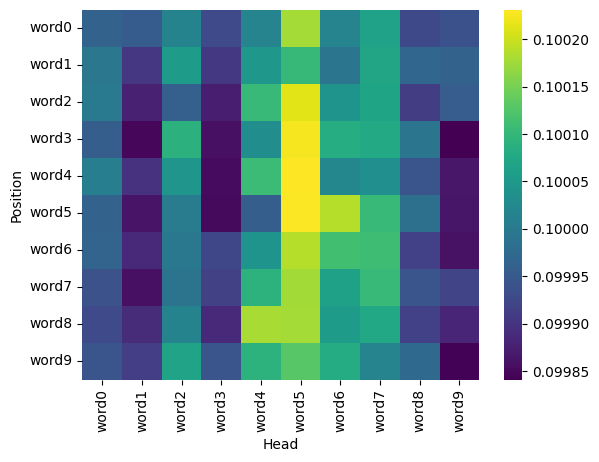

In [ ]:
### Preliminary experiments for attention visualisation TODO: move?
def visualize_attention(sentence, attention_weights):
    attention_weights = attention_weights.squeeze(0).detach().cpu().numpy()
    sns.heatmap(attention_weights, xticklabels=sentence, yticklabels=sentence, cmap='viridis')
    plt.xlabel('Head')
    plt.ylabel('Position')
    plt.show()

def get_dummy_results(model, batch_size, seq_length):
    '''
    args:
        model with attention

    returns: a dummy sentence and attention weights
    '''
    dummy_input = torch.randint(0, vocab_size, (batch_size, seq_length))  # batch size of 1, sequence length of 10
    output, attention_weights = model(dummy_input)
    dummy_sentence = ["word" + str(i) for i in range(seq_length)]
    return dummy_sentence, attention_weights


model_1a_dummy = BiLSTMConcatAspectAtt(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, 'concat')
dummy_sentence, dummy_attention_weights = get_dummy_results(model_1a_dummy, seq_length=10, batch_size=1)

visualize_attention(dummy_sentence, dummy_attention_weights[0])

## Model 2: Separate sentence and aspect, BiLSTM for sentence, aspect-to-sentence attention

In [ ]:
# Prepare data

# encoded labels - renamed for clarity
train_labels_enc = train_labels
val_labels_enc = val_labels
test_labels_enc = test_labels

# Tokenize and convert to indices
def tokenize_and_index(sentences, vocab):
    tokenized_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        token_indices = [vocab.get(token, 0) for token in tokens]  # 0 for unknown words
        tokenized_sentences.append(torch.tensor(token_indices, dtype=torch.long))
    return tokenized_sentences

def tokens_to_indices(tokenized_sentences, vocab):
    indices = []
    for sentence in tokenized_sentences:
        token_indices = [vocab.get(token, 0) for token in sentence]  # 0 for unknown words
        indices.append(torch.tensor(token_indices, dtype=torch.long))
    return indices

# sents encoded
train_sents_indices = tokens_to_indices(train_sents, vocab)
val_sents_indices = tokens_to_indices(val_sents, vocab)
test_sents_indices = tokens_to_indices(test_sents, vocab)

# Pad sequences
train_sents_padded = pad_sequence(train_sents_indices, batch_first=True, padding_value=0)
val_sents_padded = pad_sequence(val_sents_indices, batch_first=True, padding_value=0)
test_sents_padded = pad_sequence(test_sents_indices, batch_first=True, padding_value=0)

# Encode aspects using the same vocab (word_to_ix)
train_aspects_enc = [vocab.get(asp, vocab["[UNK]"]) for asp in list(train_df['aspect'])]
val_aspects_enc = [vocab.get(asp, vocab["[UNK]"]) for asp in list(val_df['aspect'])]
test_aspects_enc = [vocab.get(asp, vocab["[UNK]"]) for asp in list(test_df['aspect'])]

# Encoded labels
# train_labels, val_labels, test_labels

# Custom dataset class to handle loading of sentences, aspects and labels
class SentimentDataset(Dataset):
    def __init__(self, sentences, aspects, labels):
        self.sentences = sentences # sentences are in tensor during padding
        self.aspects = torch.tensor(aspects, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.aspects[idx], self.labels[idx]

batch_size = 128 # Adjust based on GPU capacity

# Batch and shuffle data using DataLoader
m2_train_dataset = SentimentDataset(train_sents_padded, train_aspects_enc, train_labels_enc)
m2_train_loader = DataLoader(m2_train_dataset, batch_size=batch_size, shuffle=True)

m2_val_dataset = SentimentDataset(val_sents_padded, val_aspects_enc, val_labels_enc)
m2_val_loader = DataLoader(m2_val_dataset, batch_size=batch_size, shuffle=False)

m2_test_dataset = SentimentDataset(test_sents_padded, test_aspects_enc, test_labels_enc)
m2_test_loader = DataLoader(m2_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define model

# If we talk about the vectors in terms of an encoder/decoder structure instead of a question answering structure,
# The encoder would serve as "keys" and "values", and the decoder would serve as the "query" in the attention mechanism
class Attention(nn.Module):
    def __init__(self, method, hidden_dim=None, self_attn=False, input_dim=None):
        super(Attention, self).__init__()
        self.method = method
        self.self_attn = self_attn
        if self_attn:
            if input_dim is None:
                raise ValueError("input_dim must be provided for self-attention")
            self.query = nn.Linear(input_dim, input_dim)
            self.key = nn.Linear(input_dim, input_dim)
            self.value = nn.Linear(input_dim, input_dim)

        if method in ["additive", "general", "location_based"] and hidden_dim is None:
            raise ValueError(f"hidden_dim must be provided for {method} attention")

        if method == "general":
            # set up a trainable weight matrix which align with the dimensions of queries and keys
            # ensure the transformed queries remain in the same dimension (hidden_dim * 2)
            self.W_a = nn.Linear(hidden_dim * 2, hidden_dim * 2)

        if method == "location_based":
            # set up a learnable location weights with shape [1, hidden_dim * 2]
            self.location_weights = nn.Parameter(torch.randn(1, hidden_dim * 2))

        if method == "additive":
            self.W1 = nn.Linear(hidden_dim * 2, hidden_dim) # trainable weight matrix for queries
            self.W2 = nn.Linear(hidden_dim * 2, hidden_dim) # trainable weight matrix for keys
            self.v_a = nn.Linear(hidden_dim, 1) # reduce the combined transformed queries and keys to a scalar score for each key-query pair

    def forward(self, queries, keys, values):
        if self.self_attn:
            # Apply linear transformations to input for self-attention
            queries = self.query(queries)
            keys = self.key(keys)
            values = self.value(values)

        # Compute attention scores
        if self.method == "dot_product":
            '''
            torch.bmm is a batch matrix-matrix product.
            torch.bmm performs batch matrix multiplication on two tensors of shape [batch_size, n, m] and
            [batch_size, m, p], resulting in a tensor of shape [batch_size, n, p]

            in this case,
            - queries: [batch_size, seq_length_q, hidden_dim * 2]
            - keys: [batch_size, seq_length_k, hidden_dim * 2]
            - keys.transpose(1, 2): [batch_size, hidden_dim * 2, seq_length_k]
            - torch.bmm(queries, keys.transpose(1, 2)): aligns hidden_dim * 2 of queries with
              hidden_dim * 2 of the transposed keys.

            thus, the attention_scores is [batch_size, seq_length_q, seq_length_k]
            '''
            attention_scores = torch.bmm(queries, keys.transpose(1,2)) # [batch_size, 1, seq_length]

        elif self.method == "scaled_dot_product":
            '''
            Similar to dot_product, but we scale the scores by the square root of the hidden dimension * 2
            to mitigate the issue of large dot products leading to small gradients.
            '''
            scale = np.sqrt(queries.size(-1)) #  Use the aspect embedding dimension after matching (hidden_dim * 2)
            attention_scores = torch.bmm(queries, keys.transpose(1,2))/ scale # [batch_size, seq_length_q, seq_length_k]

        elif self.method == "cos_sim":
            '''
            Compute cosine similarity scores between queries and keys.
            Cosine similarity measures the cosine of the angle between two vectors.
            Normalise queries and keys to unit vectors and then compute their dot product.
            To normalize a vector to a unit vector, we divide each component of the vector by its magnitude (norm).
            '''
            # Normalise keys and queries to unit vectors
            norm_keys = F.normalize(keys, p=2, dim=-1) # [batch_size, seq_length_k, hidden_dim * 2]
            norm_queries = F.normalize(queries, p=2, dim=-1) # [batch_size, seq_length_q, hidden_dim * 2]
            # Matrix multiplication (dot product on unit vector of transposed key and query)
            attention_scores = torch.bmm(norm_queries, norm_keys.transpose(1,2)) # [batch_size, seq_length_q, seq_length_k]

        elif self.method == "general":
            '''
            We apply a learnable weight matrix (W_a) that transforms the query vector before computing the dot product.
            This transformation allows the model to learn a more flexible alignment between queries and keys,
            which can enhance the ability to capture relevant information from the sequence.
            Although the formula proposed by Luong was using the W_a to transpose key in theory,
            we will apply the W_a to transpose query for efficiency in batch operations.
            (We only need to apply the linear transformation once to the query instead of multiple times to each key.)
            '''
            # Transform the queries with the learnable weight matrix
            transformed_queries = self.W_a(queries) # [batch_size, seq_length_q, hidden_dim * 2]
            # Matrix multiplication (dot product on transformed queries and key)
            attention_scores = torch.bmm(transformed_queries, keys.transpose(1,2)) # [batch_size, seq_length_q, seq_length_k]

        elif self.method == "location_based":
            '''
            The location-based attention method does not directly use the query for calculating the attention score.
            Instead, "attention_scores" is computed by applying the location weights to the keys. It determines the
            importance of each position in the sequence based on fixed, learnable weights.
            '''
            attention_scores = torch.matmul(keys, self.location_weights.transpose(0, 1))  # [batch_size, seq_length_k, 1]
            attention_scores = attention_scores.permute(0, 2, 1) # [batch_size, 1, seq_length_k]

        elif self.method == "additive":
            '''
            The additive attention method combines the queries and keys through a feed-forward neural network
            and uses a single-layer perceptron to compute the attention scores.
            '''
            # For A2S attention, expand queries to match the sequence length of keys
            if keys.size(1) > queries.size(1):
                queries = queries.expand(-1, keys.size(1), -1) # [batch_size, seq_length_k, hidden_dim * 2]
            # For S2A attention, expand keys to match the sequence length of queries
            else:
                keys_exp = keys.expand(-1, queries.size(1), -1) # [batch_size, seq_length_k, hidden_dim * 2]
            # Combine key and queries, and apply non-linear activation (tanh)
            combined = torch.tanh(self.W1(queries) + self.W2(keys)) # [batch_size, seq_length_k, hidden_dim * 2]
            # Compute attention scores for the combined result with another trainable matrix (v_a)
            attention_scores = self.v_a(combined).squeeze(2) # [batch_size, seq_length_k]
            attention_scores = attention_scores.unsqueeze(1) # [batch_size, 1, seq_length_k]

        else:
            raise ValueError(f"Unknown attention method: {self.method}")

        # Normalise the attention scores to probabilities
        attention_weights = F.softmax(attention_scores, dim=-1) # [batch_size, seq_length_q, seq_length_k]

        # Compute attention output
        attention_output = torch.bmm(attention_weights, values) # [batch_size, seq_length_q, hidden_dim * 2]

        return attention_output, attention_weights


class BiLSTMSeparateAspect(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, attn_method, num_layers=1, dropout=0.2):
        super(BiLSTMSeparateAspect, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # freeze the embeddings
        # Bi-LSTM layer for sentences
        self.bi_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=dropout) # (hidden_dim * 2, embedding_dim)
        # Match dimension of aspect embedding to output of bi-LSTM layer
        self.dim_match = nn.Linear(embedding_dim, hidden_dim * 2)
        # Attention
        self.attention = Attention(attn_method, hidden_dim)
        # Output layer
        self.linear = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, sentence, aspect):
        # Embed sentences and aspects
        sent_embedding = self.embedding(sentence) # [batch_size, seq_length, embedding_dim]
        asp_embedding = self.embedding(aspect) # [batch_size, embedding_dim]
        # Increase aspect size to match sentence
        asp_matched = self.dim_match(asp_embedding) # [batch size, hidden *2]
        asp_matched = asp_matched.unsqueeze(1) # [batch size, 1, hidden *2]
        # Pass embedded sentences through bi-LSTM
        lstm_output, h_n = self.bi_lstm(sent_embedding)  # [batch_size, seq_length, hidden_dim * 2] (returns h_n)
        # lstm_output is the ith forward and ith backward at each timestep_i

        # Attention - calculate attention based on aspect to lstm
        attn_output, attn_weights = self.attention(asp_matched, lstm_output, lstm_output) # attn_output [batch_size, 1, hidden_dim * 2]
        # Remove the seq_length dimension
        '''
        "attention_output" represents the overall weighted sum of each token in a sequence, where the weights
        are determined by the attention scores (relevance of each key (token) in the sequence (sentence) to the
        given query (aspect)). So no more seq_length dimension needed.
        '''
        attn_output = attn_output.squeeze(1) # [batch_size, hidden_dim * 2]
        # Pass through output layer
        output = self.linear(attn_output)
        return output, attn_weights

In [ ]:
# Training model 2
# Define hyperparameters
embedding_dim = emb_matrix.shape[-1]
hidden_dim = 256 # hidden dimension of Bi-LSTM layer
output_dim = 3 # 3 sentiment classes
vocab_size = len(vocab)
learning_rate = 0.001
num_layers = 1
dropout = 0.2
num_epochs = 10

# Update config with experiment changes
model2_config = {
    'model_type': 'BiLSTM_separate',
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'vocab_size': len(vocab),
    'embedding_dim': emb_matrix.shape[-1],
    'hidden_dim': hidden_dim,
    'output_dim': output_dim,
    'save_model': True
}

# Create experiment config
experiment_name = "BiLSTM_separate"
config = create_experiment_config(base_config, model2_config, experiment_name)

# Initialise device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1:
Training Loss: 0.9650, Training Accuracy: 53.68%
Validation Loss: 0.8886, Validation Accuracy: 62.05%
Epoch 2:
Training Loss: 0.8625, Training Accuracy: 61.58%
Validation Loss: 0.8198, Validation Accuracy: 64.30%
Epoch 3:
Training Loss: 0.7954, Training Accuracy: 65.80%
Validation Loss: 0.7649, Validation Accuracy: 67.45%
Epoch 4:
Training Loss: 0.7508, Training Accuracy: 68.14%
Validation Loss: 0.7325, Validation Accuracy: 67.79%
Epoch 5:
Training Loss: 0.7115, Training Accuracy: 70.41%
Validation Loss: 0.7259, Validation Accuracy: 69.26%
Epoch 6:
Training Loss: 0.6818, Training Accuracy: 70.96%
Validation Loss: 0.7183, Validation Accuracy: 70.16%
Epoch 7:
Training Loss: 0.6516, Training Accuracy: 72.79%
Validation Loss: 0.7096, Validation Accuracy: 69.71%
Epoch 8:
Training Loss: 0.6223, Training Accuracy: 74.60%
Validation Loss: 0.7180, Validation Accuracy: 70.50%
Epoch 9:
Training Loss: 0.5971, Training Accuracy: 75.59%
Validation Loss: 0.7127, Validation Accuracy: 70.95%
E

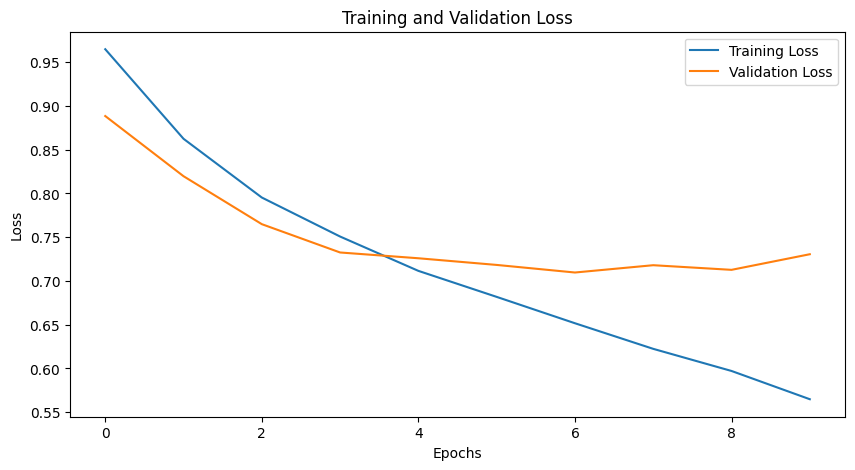

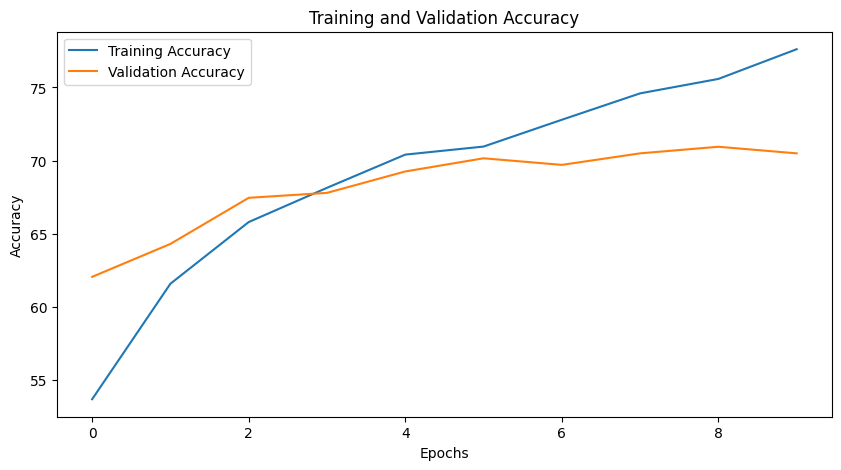


Test Loss: 0.7237, Test Accuracy: 68.26%


In [ ]:
# Initialise model
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
model_2 = BiLSTMSeparateAspect(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product", num_layers, dropout).to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

# Training
train(model_2, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
# Evaluate
test_loss, test_acc, y_true, y_pred = evaluate(model_2, m2_test_loader, loss_function, val=False, return_output=True, has_attention=True)
model_2_metrics = get_training_stats(y_true, y_pred, print_stats=False)

### M2 Ablation studies

#### Learning rate and number of epochs

* LR = 0.01 does not converge after 10 epochs, validation accuracy = 64.82%
* LR = 0.005 converges after ~4 epochs, validation accuracy = 70.26% 71.59% 66.26%
* **LR = 0.001** converges after ~5 epochs, validation accuracy = 69.81% 68.04% 70.70%
* LR = 0.0001 converges after ~5 epochs, validation accuracy = 70.59 63.15% 64.26%
* LR = 0.00001 does not converge after 10 epochs, validation accuracy = 63.82%



#### Attention computation methods

Testing different attention computation methods, apart from dot product from the above

1. Scaled dot product
2. Cosine similarity
3. General
4. Location-based
5. Additive

##### 2a. Scaled dot product


- Seems overfitting issue is noted from scaled dot product.
- May try higher dropout?

In [ ]:
# Initialise model
model_2a = BiLSTMSeparateAspect(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "scaled_dot_product", num_layers, dropout).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2a.parameters(), lr=learning_rate)

model2a_config = {
    'model_type': 'BiLSTM_separate_scaled_dp',
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'vocab_size': len(vocab),
    'embedding_dim': emb_matrix.shape[-1],
    'hidden_dim': hidden_dim,
    'output_dim': output_dim,
    'preprocessing_config': config # save preprocessing config with trained model
}

experiment_name = "BiLSTM_separate_scaled_dp"
config = create_experiment_config(config, model2a_config, experiment_name)

Epoch 1:
Training Loss: 0.9987, Training Accuracy: 50.08%
Validation Loss: 0.9074, Validation Accuracy: 59.23%
Epoch 2:
Training Loss: 0.8747, Training Accuracy: 59.01%
Validation Loss: 0.8094, Validation Accuracy: 63.18%
Epoch 3:
Training Loss: 0.8372, Training Accuracy: 62.02%
Validation Loss: 0.8055, Validation Accuracy: 62.84%
Epoch 4:
Training Loss: 0.8230, Training Accuracy: 63.05%
Validation Loss: 0.7933, Validation Accuracy: 64.30%
Epoch 5:
Training Loss: 0.8008, Training Accuracy: 64.33%
Validation Loss: 0.7697, Validation Accuracy: 63.63%
Epoch 6:
Training Loss: 0.7801, Training Accuracy: 65.68%
Validation Loss: 0.7528, Validation Accuracy: 65.77%
Epoch 7:
Training Loss: 0.7574, Training Accuracy: 66.69%
Validation Loss: 0.7486, Validation Accuracy: 66.44%
Epoch 8:
Training Loss: 0.7385, Training Accuracy: 67.97%
Validation Loss: 0.7329, Validation Accuracy: 67.57%
Epoch 9:
Training Loss: 0.7176, Training Accuracy: 69.15%
Validation Loss: 0.7233, Validation Accuracy: 68.47%
E

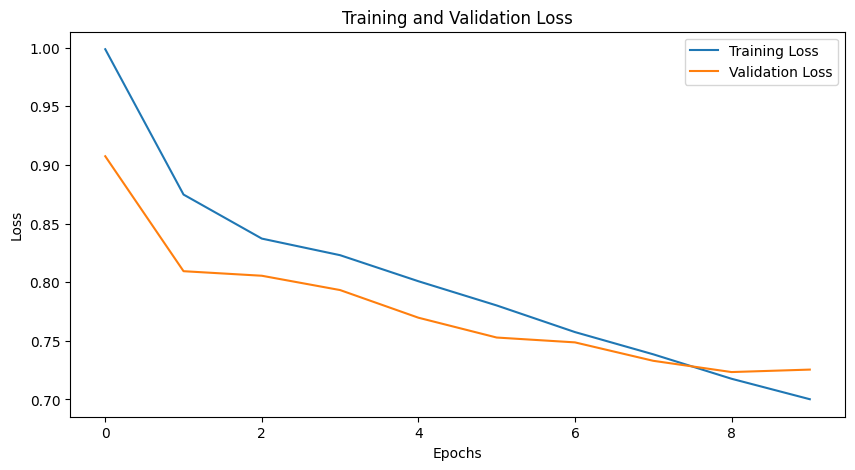

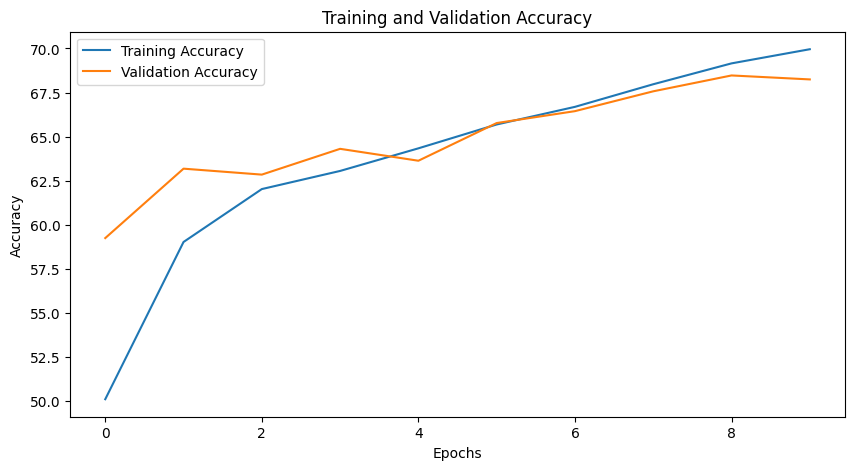


Test Loss: 0.7504, Test Accuracy: 65.70%


In [ ]:
# Training
train(model_2a, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config)
print()
# Evaluate on test
test_loss, test_acc, y_true, y_pred = evaluate(model_2a, m2_test_loader, loss_function, val=False, return_output=True, has_attention=True)
model_2a_metrics = get_training_stats(y_true, y_pred, print_stats=False)

##### 2b. Cosine similarity

Epoch 1:
Training Loss: 0.9883, Training Accuracy: 50.66%
Validation Loss: 0.8777, Validation Accuracy: 60.70%
Epoch 2:
Training Loss: 0.8804, Training Accuracy: 59.65%
Validation Loss: 0.8528, Validation Accuracy: 59.91%
Epoch 3:
Training Loss: 0.8547, Training Accuracy: 60.62%
Validation Loss: 0.8282, Validation Accuracy: 63.06%
Epoch 4:
Training Loss: 0.8459, Training Accuracy: 60.85%
Validation Loss: 0.8075, Validation Accuracy: 61.37%
Epoch 5:
Training Loss: 0.8305, Training Accuracy: 61.78%
Validation Loss: 0.8242, Validation Accuracy: 62.61%
Epoch 6:
Training Loss: 0.8193, Training Accuracy: 62.47%
Validation Loss: 0.8142, Validation Accuracy: 64.19%
Epoch 7:
Training Loss: 0.8120, Training Accuracy: 63.12%
Validation Loss: 0.7903, Validation Accuracy: 62.16%
Epoch 8:
Training Loss: 0.8067, Training Accuracy: 63.27%
Validation Loss: 0.8220, Validation Accuracy: 63.40%
Epoch 9:
Training Loss: 0.7977, Training Accuracy: 63.43%
Validation Loss: 0.8270, Validation Accuracy: 62.73%
E

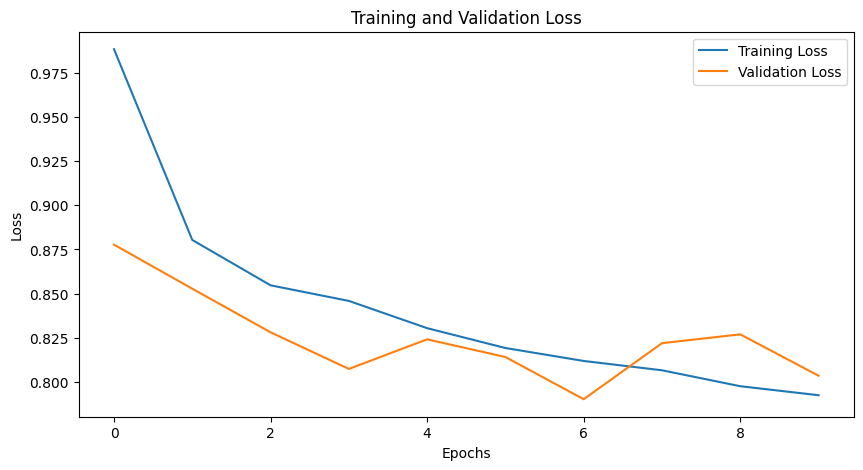

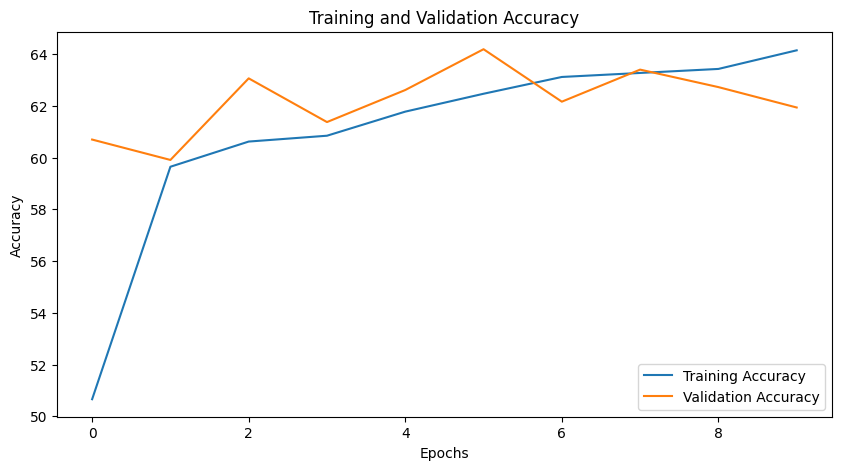


Test Loss: 0.7953, Test Accuracy: 61.82%


In [ ]:
# Initialise experiment hyperparameters
model2b_config = {
    'model_type': 'BiLSTM_separate_cos_sim',
}
experiment_name = "BiLSTM_separate_cos_sim"
config = create_experiment_config(config, model2b_config, experiment_name)

# Initialise model
model_2b = BiLSTMSeparateAspect(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "cos_sim", num_layers, dropout).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2b.parameters(), lr=learning_rate)


train(model_2b, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_2b, m2_test_loader, loss_function, val=False, return_output=True)
model_2b_metrics = get_training_stats(y_true, y_pred, print_stats=False)

##### 2c. General

Why so poor?

Epoch 1:
Training Loss: 1.0197, Training Accuracy: 48.18%
Validation Loss: 0.9881, Validation Accuracy: 53.04%
Epoch 2:
Training Loss: 0.9574, Training Accuracy: 55.30%
Validation Loss: 0.8822, Validation Accuracy: 60.47%
Epoch 3:
Training Loss: 0.8621, Training Accuracy: 61.90%
Validation Loss: 0.8213, Validation Accuracy: 64.08%
Epoch 4:
Training Loss: 0.8238, Training Accuracy: 64.15%
Validation Loss: 0.8153, Validation Accuracy: 63.85%
Epoch 5:
Training Loss: 0.8034, Training Accuracy: 64.85%
Validation Loss: 0.7824, Validation Accuracy: 64.98%
Epoch 6:
Training Loss: 0.7649, Training Accuracy: 67.50%
Validation Loss: 0.7647, Validation Accuracy: 67.12%
Epoch 7:
Training Loss: 0.7492, Training Accuracy: 68.01%
Validation Loss: 0.7600, Validation Accuracy: 68.47%
Epoch 8:
Training Loss: 0.7320, Training Accuracy: 68.83%
Validation Loss: 0.7709, Validation Accuracy: 66.55%
Epoch 9:
Training Loss: 0.7120, Training Accuracy: 69.70%
Validation Loss: 0.7395, Validation Accuracy: 67.68%
E

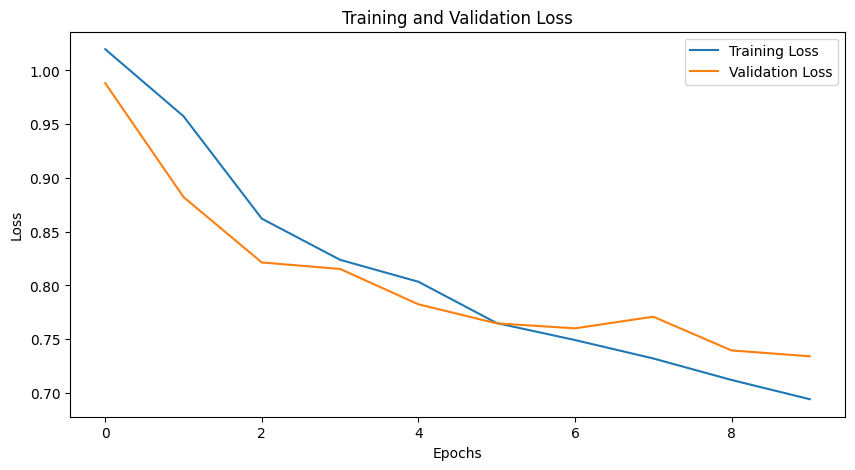

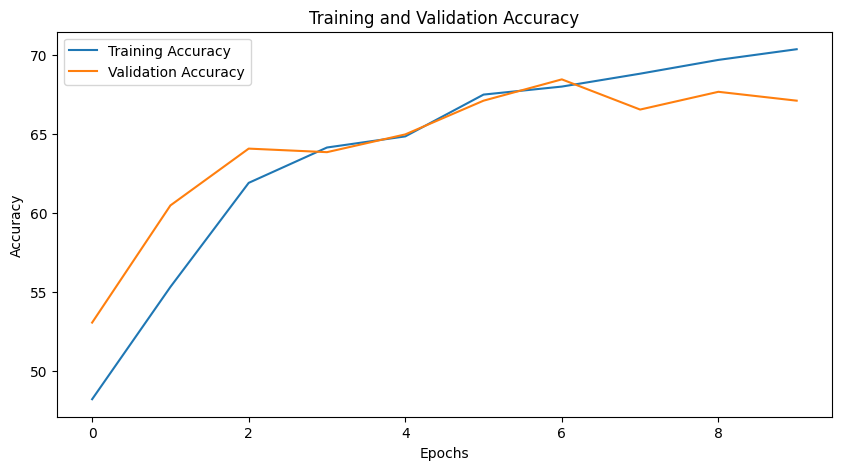


Test Loss: 0.7631, Test Accuracy: 66.93%


In [ ]:
# Initialise experiment hyperparameters
model2c_config = {
    'model_type': 'BiLSTM_separate_general',
}
experiment_name = "BiLSTM_separate_general"
config = create_experiment_config(base_config, model2c_config, experiment_name)

# Initialise model
model_2c = BiLSTMSeparateAspect(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "general", num_layers, dropout).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2c.parameters(), lr=learning_rate)

train(model_2c, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_2c, m2_test_loader, loss_function, val=False, return_output=True)
model_2c_metrics = get_training_stats(y_true, y_pred, print_stats=False)

##### 2d. Location-based

This location-based attention method does not perform as good as the above methods which took into consideration of the aspect. This may indicate the positions of tokens in the sequence may not provide us sufficient information towards the polarity.

Epoch 1:
Training Loss: 1.0722, Training Accuracy: 42.72%
Validation Loss: 1.0381, Validation Accuracy: 43.69%
Epoch 2:
Training Loss: 1.0212, Training Accuracy: 44.53%
Validation Loss: 1.0051, Validation Accuracy: 46.85%
Epoch 3:
Training Loss: 1.0025, Training Accuracy: 46.19%
Validation Loss: 1.0640, Validation Accuracy: 41.10%
Epoch 4:
Training Loss: 1.0031, Training Accuracy: 45.83%
Validation Loss: 0.9640, Validation Accuracy: 47.97%
Epoch 5:
Training Loss: 0.9747, Training Accuracy: 47.01%
Validation Loss: 0.9784, Validation Accuracy: 47.41%
Epoch 6:
Training Loss: 0.9788, Training Accuracy: 46.16%
Validation Loss: 0.9998, Validation Accuracy: 44.26%
Epoch 7:
Training Loss: 0.9617, Training Accuracy: 47.50%
Validation Loss: 0.9582, Validation Accuracy: 47.18%
Epoch 8:
Training Loss: 0.9568, Training Accuracy: 47.63%
Validation Loss: 0.9484, Validation Accuracy: 47.75%
Epoch 9:
Training Loss: 0.9457, Training Accuracy: 47.88%
Validation Loss: 0.9634, Validation Accuracy: 47.64%
E

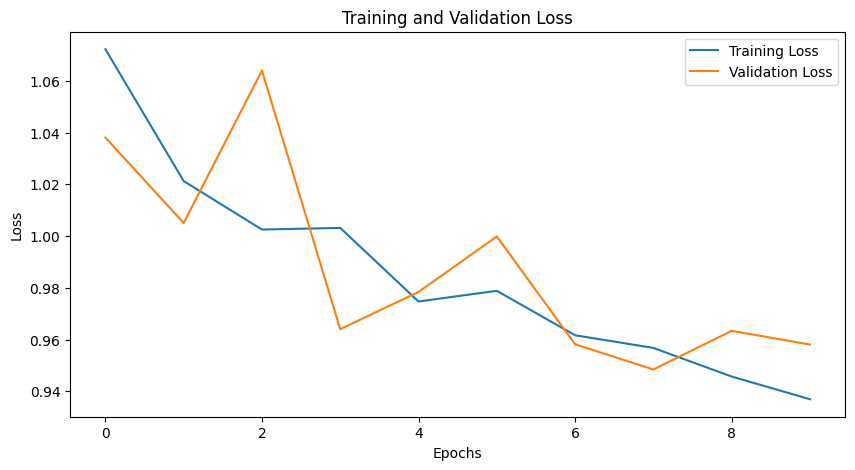

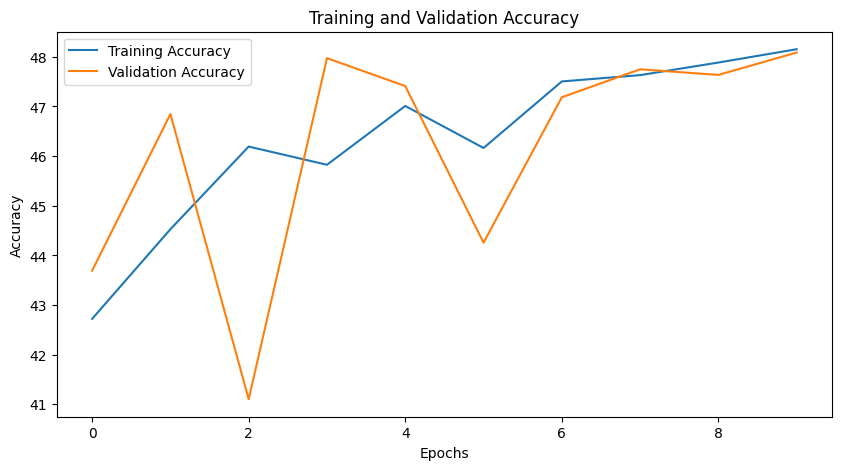


Test Loss: 0.9711, Test Accuracy: 46.50%


In [ ]:
# Initialise experiment hyperparameters
model2d_config = {
    'model_type': 'BiLSTM_separate_loc',
}

experiment_name = "BiLSTM_separate_loc"
config = create_experiment_config(config, model2d_config, experiment_name)

# Initialise model
model_2d = BiLSTMSeparateAspect(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "location_based", num_layers, dropout).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2d.parameters(), lr=learning_rate)

# Train model and evaluate on test set
train(model_2d, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_2d, m2_test_loader, loss_function, val=False, return_output=True)
model_2d_metrics = get_training_stats(y_true, y_pred, print_stats=False)

##### 2e. Additive

Epoch 1:
Training Loss: 1.0409, Training Accuracy: 44.96%
Validation Loss: 0.9412, Validation Accuracy: 58.78%
Epoch 2:
Training Loss: 0.9006, Training Accuracy: 59.35%
Validation Loss: 0.8651, Validation Accuracy: 60.59%
Epoch 3:
Training Loss: 0.8533, Training Accuracy: 61.44%
Validation Loss: 0.8171, Validation Accuracy: 62.50%
Epoch 4:
Training Loss: 0.8237, Training Accuracy: 62.82%
Validation Loss: 0.8051, Validation Accuracy: 61.49%
Epoch 5:
Training Loss: 0.8117, Training Accuracy: 64.23%
Validation Loss: 0.8078, Validation Accuracy: 63.51%
Epoch 6:
Training Loss: 0.7931, Training Accuracy: 64.78%
Validation Loss: 0.7880, Validation Accuracy: 63.18%
Epoch 7:
Training Loss: 0.7795, Training Accuracy: 65.84%
Validation Loss: 0.7748, Validation Accuracy: 64.64%
Epoch 8:
Training Loss: 0.7544, Training Accuracy: 67.93%
Validation Loss: 0.7877, Validation Accuracy: 64.30%
Epoch 9:
Training Loss: 0.7342, Training Accuracy: 68.84%
Validation Loss: 0.7571, Validation Accuracy: 66.33%
E

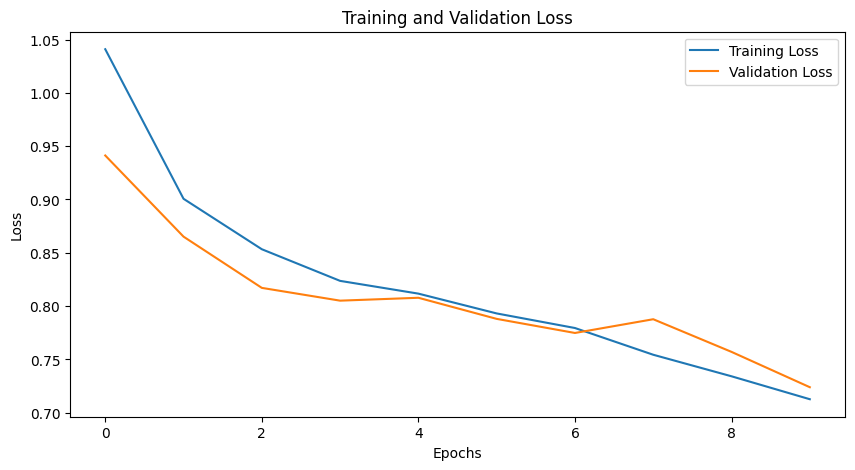

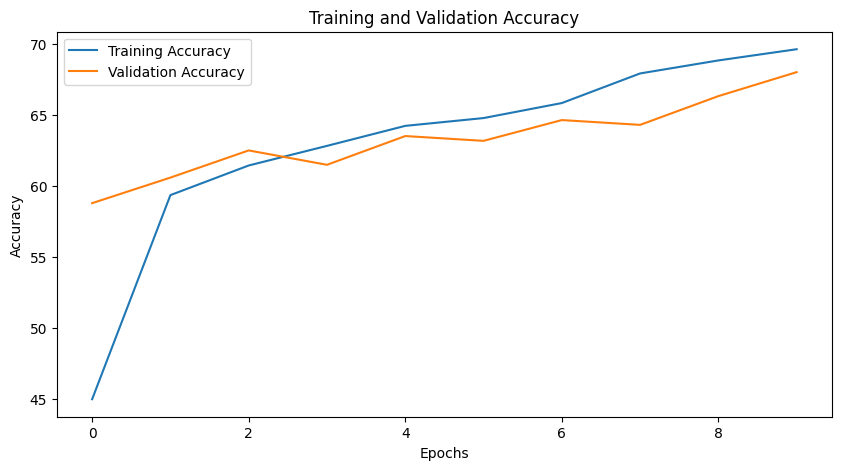


Test Loss: 0.6942, Test Accuracy: 67.70%


In [ ]:
# Initialise experiment hyperparameters
model2e_config = {
    'model_type': 'BiLSTM_separate_additive',
}
experiment_name = "BiLSTM_separate_additive"
config = create_experiment_config(config, model2e_config, experiment_name)

# Initialise model
model_2e = BiLSTMSeparateAspect(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "additive", num_layers, dropout).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2e.parameters(), lr=learning_rate)

# Train model and evaluate on test set
train(model_2e, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_2e, m2_test_loader, loss_function, return_output=True)
model_2e_metrics = get_training_stats(y_true, y_pred, print_stats=False)

#### Attention mechanism

##### 2f. Self-attention on sentences

To further improve model performance, we experimented with adding self-attention on sentences before performing cross-attention between sentences and aspects.

From the previous experiments with different cross-attention methods, we observed that the dot product and scaled dot product methods achieved the highest testing accuracy. However, there was a potential overfitting issue noted with the scaled dot product method. Therefore, in this experiment, we decided to use the dot product method for both self-attention on sentences and cross-attention with aspects.

In [ ]:
class BiLSTMSeparateAspectSelfAttn(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, attn_method, num_layers=1, dropout=0.2):
        super(BiLSTMSeparateAspectSelfAttn, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # freeze the embeddings
        # Bi-LSTM layer for sentences
        self.bi_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=dropout) # (hidden_dim * 2, embedding_dim)
        # Match dimension of aspect embedding to output of bi-LSTM layer
        self.dim_match = nn.Linear(embedding_dim, hidden_dim * 2)
        # Self-Attention
        self.self_attention = Attention(attn_method, hidden_dim, self_attn=True, input_dim=hidden_dim * 2)
        # Cross-Attention
        self.cross_attention = Attention(attn_method, hidden_dim)
        # Output layer
        self.linear = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, sentence, aspect):
        # Embed sentences and aspects
        sent_embedding = self.embedding(sentence) # [batch_size, seq_length, embedding_dim]
        asp_embedding = self.embedding(aspect) # [batch_size, embedding_dim]
        # Increase aspect size to match sentence
        asp_matched = self.dim_match(asp_embedding) # [batch size, hidden *2]
        asp_matched = asp_matched.unsqueeze(1) # [batch size, 1, hidden *2]
        # Pass embedded sentences through bi-LSTM
        lstm_output, h_n = self.bi_lstm(sent_embedding)  # [batch_size, seq_length, hidden_dim * 2] (returns h_n)
        # lstm_output is the ith forward and ith backward at each timestep_i

        # Self-Attention on sentences
        self_attn_output, _ = self.self_attention(lstm_output, lstm_output, lstm_output)  # [batch_size, seq_length, hidden_dim * 2]
        # Cross-Attention - calculate attention based on aspect to lstm after self-attention
        attn_output, attn_weights = self.cross_attention(asp_matched, self_attn_output, self_attn_output) # attn_output [batch_size, 1, hidden_dim * 2]
        # Remove the seq_length dimension
        '''
        "attention_output" represents the overall weighted sum of each token in a sequence, where the weights
        are determined by the attention scores (relevance of each key (token) in the sequence (sentence) to the
        given query (aspect)). So no more seq_length dimension needed.
        '''
        attn_output = attn_output.squeeze(1) # [batch_size, hidden_dim * 2]
        # Pass through output layer
        output = self.linear(attn_output)
        return output, attn_weights

In [ ]:
# Define hyperparameters
embedding_dim = emb_matrix.shape[-1]
hidden_dim = 256 # hidden dimension of Bi-LSTM layer
output_dim = 3 # 3 sentiment classes
learning_rate = 0.001

model2f_config = {
    'model_type': 'BiLSTM_separate_selfAttn',
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'vocab_size': len(vocab),
    'embedding_dim': emb_matrix.shape[-1],
    'output_dim': output_dim,
}

experiment_name = "BiLSTM_separate_selfAttn"
config = create_experiment_config(config, model2f_config, experiment_name)

Epoch 1:
Training Loss: 0.9949, Training Accuracy: 52.72%
Validation Loss: 0.9192, Validation Accuracy: 58.78%
Epoch 2:
Training Loss: 0.9037, Training Accuracy: 60.24%
Validation Loss: 0.8855, Validation Accuracy: 60.70%
Epoch 3:
Training Loss: 0.8563, Training Accuracy: 63.20%
Validation Loss: 0.8299, Validation Accuracy: 65.32%
Epoch 4:
Training Loss: 0.8297, Training Accuracy: 64.82%
Validation Loss: 0.8305, Validation Accuracy: 65.09%
Epoch 5:
Training Loss: 0.7828, Training Accuracy: 66.60%
Validation Loss: 0.7875, Validation Accuracy: 66.33%
Epoch 6:
Training Loss: 0.7666, Training Accuracy: 67.15%
Validation Loss: 0.7698, Validation Accuracy: 68.13%
Epoch 7:
Training Loss: 0.7510, Training Accuracy: 68.93%
Validation Loss: 0.7610, Validation Accuracy: 67.12%
Epoch 8:
Training Loss: 0.7283, Training Accuracy: 68.98%
Validation Loss: 0.7801, Validation Accuracy: 67.00%
Epoch 9:
Training Loss: 0.7074, Training Accuracy: 70.00%
Validation Loss: 0.7226, Validation Accuracy: 69.03%
E

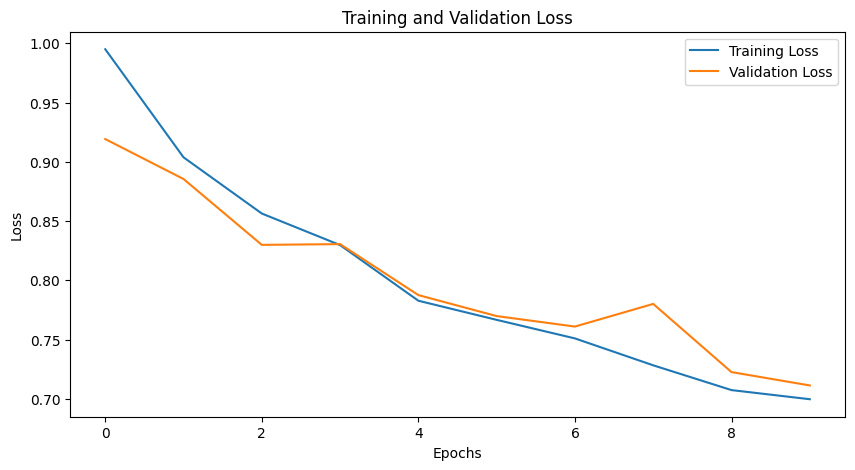

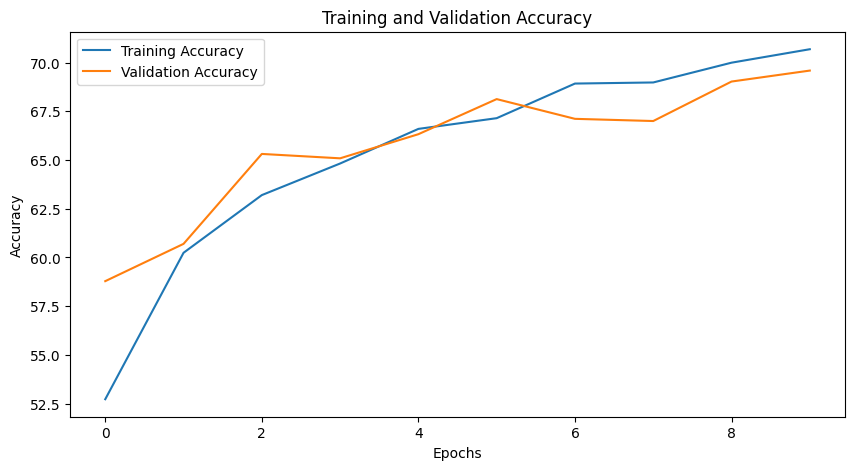


Test Loss: 0.7323, Test Accuracy: 68.26%


In [ ]:
# Initialise model
model_2f = BiLSTMSeparateAspectSelfAttn(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product", num_layers, dropout).to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2f.parameters(), lr=learning_rate)

# Train model and evaluate on test set
train(model_2f, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_2f, m2_test_loader, loss_function, return_output=True)
model_2f_metrics = get_training_stats(y_true, y_pred, print_stats=False)

The accuracy of model with self attention is worse than that without self attention.

The poor result may be due to the damage / data loss on the input word embedding after self-attention.

That's why in transformer, it does the residual connection and layer normalisation.

Thus, we will add residual connection and layer normalisation into the model 2f and see any accuracy improvement.

##### 2g. Residual connection and layer normalisation
Add residual connection and layer normalisation to 2f

In [ ]:
class BiLSTMSeparateAspectSelfAttnAddNor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, attn_method, num_layers=1, dropout=0.2):
        super(BiLSTMSeparateAspectSelfAttnAddNor, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # freeze the embeddings
        # Bi-LSTM layer for sentences
        self.bi_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=dropout) # (hidden_dim * 2, embedding_dim)
        # Match dimension of aspect embedding to output of bi-LSTM layer
        self.dim_match = nn.Linear(embedding_dim, hidden_dim * 2)
        # Self-Attention
        self.self_attention = Attention(attn_method, hidden_dim, self_attn=True, input_dim=hidden_dim * 2)
        # Residual Connection & Layer Normalisation
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        # Cross-Attention
        self.cross_attention = Attention(attn_method, hidden_dim)
        # Output layer
        self.linear = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, sentence, aspect):
        # Embed sentences and aspects
        sent_embedding = self.embedding(sentence) # [batch_size, seq_length, embedding_dim]
        asp_embedding = self.embedding(aspect) # [batch_size, embedding_dim]
        # Increase aspect size to match sentence
        asp_matched = self.dim_match(asp_embedding) # [batch size, hidden *2]
        asp_matched = asp_matched.unsqueeze(1) # [batch size, 1, hidden *2]
        # Pass embedded sentences through bi-LSTM
        lstm_output, h_n = self.bi_lstm(sent_embedding)  # [batch_size, seq_length, hidden_dim * 2] (returns h_n)
        # lstm_output is the ith forward and ith backward at each timestep_i

        # Self-Attention on sentences
        self_attn_output, _ = self.self_attention(lstm_output, lstm_output, lstm_output)  # [batch_size, seq_length, hidden_dim * 2]
        # Residual connection and layer normalisation after Self-Attention
        self_attn_output = self.layer_norm(self_attn_output + lstm_output)
        # Cross-Attention - calculate attention based on aspect to lstm after self-attention
        attn_output, attn_weights = self.cross_attention(asp_matched, self_attn_output, self_attn_output) # attn_output [batch_size, 1, hidden_dim * 2]
        # Remove the seq_length dimension
        '''
        "attention_output" represents the overall weighted sum of each token in a sequence, where the weights
        are determined by the attention scores (relevance of each key (token) in the sequence (sentence) to the
        given query (aspect)). So no more seq_length dimension needed.
        '''
        attn_output = attn_output.squeeze(1) # [batch_size, hidden_dim * 2]
        # Pass through output layer
        output = self.linear(attn_output)
        return output, attn_weights

Epoch 1:
Training Loss: 1.0706, Training Accuracy: 50.66%
Validation Loss: 0.9158, Validation Accuracy: 58.56%
Epoch 2:
Training Loss: 0.8864, Training Accuracy: 59.73%
Validation Loss: 0.8664, Validation Accuracy: 60.92%
Epoch 3:
Training Loss: 0.8505, Training Accuracy: 62.02%
Validation Loss: 0.8578, Validation Accuracy: 61.82%
Epoch 4:
Training Loss: 0.8195, Training Accuracy: 63.81%
Validation Loss: 0.8285, Validation Accuracy: 62.16%
Epoch 5:
Training Loss: 0.7952, Training Accuracy: 65.13%
Validation Loss: 0.8222, Validation Accuracy: 63.96%
Epoch 6:
Training Loss: 0.7704, Training Accuracy: 67.29%
Validation Loss: 0.8011, Validation Accuracy: 65.32%
Epoch 7:
Training Loss: 0.7484, Training Accuracy: 67.76%
Validation Loss: 0.8395, Validation Accuracy: 64.53%
Epoch 8:
Training Loss: 0.7534, Training Accuracy: 66.88%
Validation Loss: 0.7897, Validation Accuracy: 65.77%
Epoch 9:
Training Loss: 0.7198, Training Accuracy: 68.97%
Validation Loss: 0.7983, Validation Accuracy: 64.41%
E

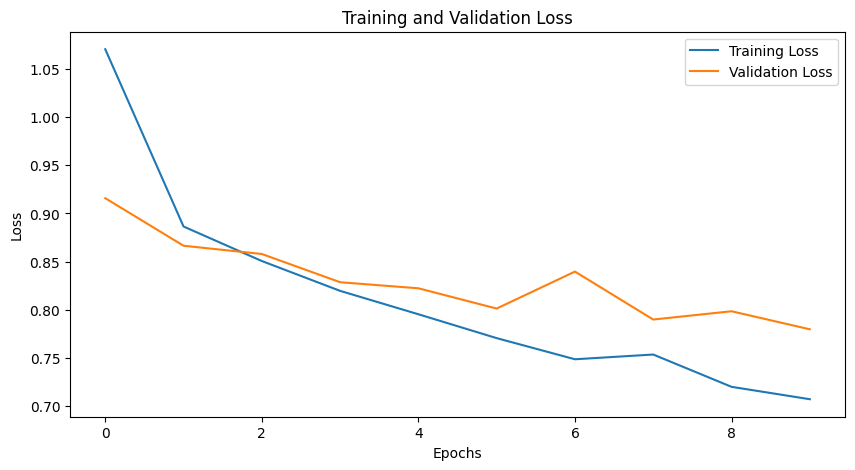

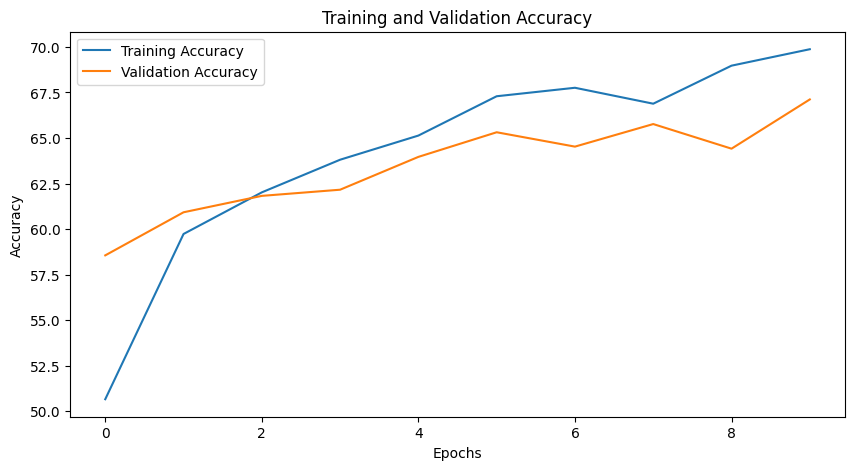


Test Loss: 0.7814, Test Accuracy: 65.04%


In [ ]:
# Define hyperparameters
model2g_config = {
    'model_type': 'BiLSTM_separate_selfAttn_AddNor',
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'vocab_size': len(vocab),
    'embedding_dim': emb_matrix.shape[-1],
    'hidden_dim': hidden_dim,
    'output_dim': output_dim,
}
experiment_name = model2g_config['model_type']
config = create_experiment_config(base_config, model2g_config, experiment_name)

# Initialise model
model_2g = BiLSTMSeparateAspectSelfAttnAddNor(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product", num_layers, dropout, ).to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2g.parameters(), lr=learning_rate)

# Train model, eval, and get performance on test
train(model_2g, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_2g, m2_test_loader, loss_function, return_output=True)
model_2g_metrics = get_training_stats(y_true, y_pred, print_stats=False)

The accuracy is still worse than the model without self attention. However, as compared to model 2f, the accuracy of the model with residual connection and layer normalisation (model 2g) has improved 13% pt.

## Model 3: Separate sentence and aspect BiLSTM, Integrated through Concatenation

* Created two LSTM layers - one for sentences and one for aspects. Otherwise, do they share weights?
* Use the Attention class defined in model 2 to calculate attention
* Applied mean pooling to the attention outputs - 1 for sentence and 1 for aspect - so that their dimensions match, before concatenating them.

In [ ]:
# Define model 3
# Uses Attention class defined above

class BiLSTMInteractiveAttn(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, attn_method, num_layers=1):
        super(BiLSTMInteractiveAttn, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        # Bi-LSTM layers
        self.sent_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=0.2)
        self.asp_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True,num_layers=num_layers, dropout=0.2)
        # Attention
        self.attn = Attention(attn_method, hidden_dim)
        # Output layer
        self.linear = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, sentence, aspect):
        # Embed sentences and aspects
        sent_embedding = self.embedding(sentence)
        asp_embedding = self.embedding(aspect)
        asp_embedding = asp_embedding.unsqueeze(1) # Add sequence dimension -> [batch_size, 1, embedding_dim]

        # Pass sentences and aspects through different Bi-LSTM networks
        sent_lstm_output, _ = self.sent_lstm(sent_embedding)
        asp_lstm_output, _ = self.asp_lstm(asp_embedding)

        # Aspect to Sentence Attention
        a2s_attn_output, a2s_attn_weights = self.attn(asp_lstm_output, sent_lstm_output, sent_lstm_output)
        # Sentence to Aspect Attention
        s2a_attn_output, s2a_attn_weights = self.attn(sent_lstm_output, asp_lstm_output, asp_lstm_output)

        # Apply mean pooling to match dimensions of attention outputs  -> [batch_size, hidden_dim * 2]
        a2s_attn_output = a2s_attn_output.mean(dim=1)
        s2a_attn_output = s2a_attn_output.mean(dim=1)

        # Combine attention outputs of sentence and aspect -> [batch_size, hidden_dim * 4]
        combined_output = torch.cat((a2s_attn_output, s2a_attn_output), dim=1)

        # Apply linear transformation to output layer
        output = self.linear(combined_output)

        return output, a2s_attn_weights

In [ ]:
# Training model 3
  # Using the same data from model 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
embedding_dim = emb_matrix.shape[-1]
hidden_dim = 256 # hidden dimension of Bi-LSTM layer
output_dim = 3 # 3 sentiment classes
vocab_size = len(vocab)
learning_rate = 0.005
num_epochs = 10  # To adjust

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# save hyperparameters to config
model3_config = {
    'model_type': 'BiLSTMInteractiveAttn',
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'vocab_size': len(vocab),
    'embedding_dim': embedding_dim,
    'hidden_dim': hidden_dim,
    'output_dim': output_dim,
    'preprocessing_config': config # save preprocessing config with trained model
}
experiment_name = 'BiLSTMInteractiveAttn',
config = create_experiment_config(base_config, model3_config, experiment_name)

# Initialise model
model_3 = BiLSTMInteractiveAttn(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product").to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

Epoch 1:
Training Loss: 0.9238, Training Accuracy: 58.72%
Validation Loss: 0.8330, Validation Accuracy: 63.51%
Epoch 2:
Training Loss: 0.8144, Training Accuracy: 64.40%
Validation Loss: 0.7486, Validation Accuracy: 67.45%
Epoch 3:
Training Loss: 0.7271, Training Accuracy: 68.93%
Validation Loss: 0.6741, Validation Accuracy: 71.62%
Epoch 4:
Training Loss: 0.6447, Training Accuracy: 72.88%
Validation Loss: 0.6700, Validation Accuracy: 71.40%
Epoch 5:
Training Loss: 0.5648, Training Accuracy: 76.66%
Validation Loss: 0.6731, Validation Accuracy: 71.51%
Epoch 6:
Training Loss: 0.4624, Training Accuracy: 81.58%
Validation Loss: 0.7298, Validation Accuracy: 71.17%
Epoch 7:
Training Loss: 0.3516, Training Accuracy: 86.49%
Validation Loss: 0.8265, Validation Accuracy: 71.40%
Epoch 8:
Training Loss: 0.2499, Training Accuracy: 90.89%
Validation Loss: 0.8963, Validation Accuracy: 70.50%
Epoch 9:
Training Loss: 0.1688, Training Accuracy: 94.30%
Validation Loss: 1.0780, Validation Accuracy: 68.36%
E

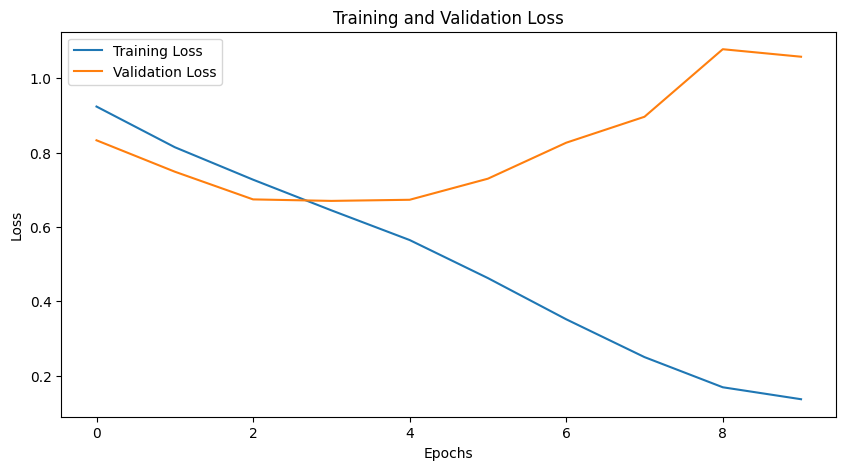

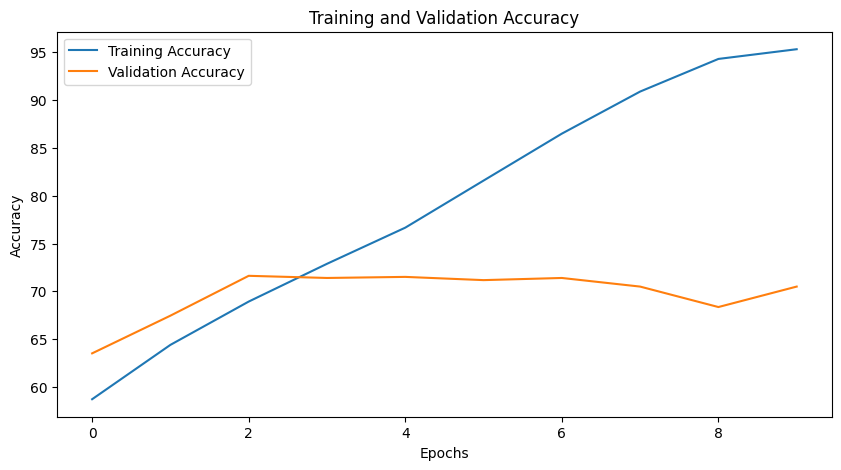


Test Loss: 1.0415, Test Accuracy: 72.14%


In [ ]:
# Train model
train(model_3, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
# Evaluate model 3
  # Using the same data from model 2
test_loss, test_acc, y_true, y_pred = evaluate(model_3, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3_metrics = get_training_stats(y_true, y_pred, print_stats=False)

### M3 Ablation studies

#### Learning rate and number of epochs

* LR = 0.01 converges after 9 epochs, validation accuracy 72.75% 71.40%
* LR = 0.0075 converges after 4 epochs, validation accuracy 73.65% 73.54%
* **LR = 0.005** converges after 3-4 epochs, validation accuracy 74.44% 72.52%
* LR = 0.0025 converges after 5 epochs, validation accuracy 73.31% 73.65%
* LR = 0.001 converges after 7-8 epochs, validation accuracy 72.07% 71.06%
* LR = 0.0001 does not converge, validation accuracy 63.48%

#### Number of layers in Bi-LSTM

Increasing the number of layers in the LSTM may capture more complex relationships, but is more sensitive to higher learning rates and may take longer to converge (ref?)

More layers do not give better results. Also takes more resources to train.

##### 2 layers

Epoch 1:
Training Loss: 1.0624, Training Accuracy: 43.05%
Validation Loss: 1.0223, Validation Accuracy: 43.69%
Epoch 2:
Training Loss: 0.9638, Training Accuracy: 54.72%
Validation Loss: 0.8775, Validation Accuracy: 58.78%
Epoch 3:
Training Loss: 0.8833, Training Accuracy: 60.01%
Validation Loss: 0.8483, Validation Accuracy: 61.37%
Epoch 4:
Training Loss: 0.8603, Training Accuracy: 61.66%
Validation Loss: 0.8311, Validation Accuracy: 61.94%
Epoch 5:
Training Loss: 0.8428, Training Accuracy: 62.52%
Validation Loss: 0.8130, Validation Accuracy: 62.16%
Epoch 6:
Training Loss: 0.8329, Training Accuracy: 63.12%
Validation Loss: 0.8285, Validation Accuracy: 63.18%
Epoch 7:
Training Loss: 0.8232, Training Accuracy: 63.44%
Validation Loss: 0.7948, Validation Accuracy: 64.08%
Epoch 8:
Training Loss: 0.8072, Training Accuracy: 64.36%
Validation Loss: 0.7870, Validation Accuracy: 63.51%
Epoch 9:
Training Loss: 0.7989, Training Accuracy: 64.67%
Validation Loss: 0.7771, Validation Accuracy: 64.19%
E

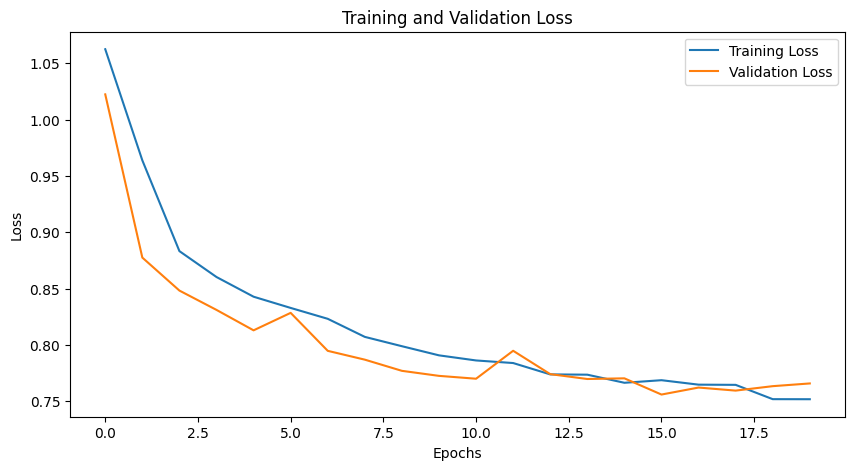

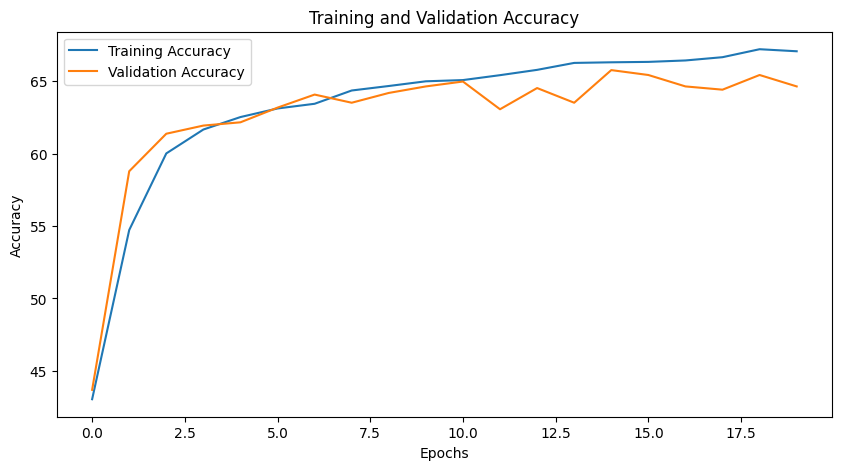


Test Loss: 0.7791, Test Accuracy: 65.04%


In [ ]:
# save hyperparameters to config
learning_rate = 0.0001
num_epochs = 20

model3_2lyr_config = {
    'model_type': 'BiLSTMInteractiveAttn_2layers',
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
}
experiment_name = 'BiLSTMInteractiveAttn_2layers',
config = create_experiment_config(base_config, model3_2lyr_config, experiment_name)

# Initialise model
model_3_2lyr = BiLSTMInteractiveAttn(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product", num_layers=2).to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3_2lyr.parameters(), lr=learning_rate)

# Train model
train(model_3_2lyr, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
# Evaluate model 3
  # Using the same data from model 2
test_loss, test_acc, y_true, y_pred = evaluate(model_3_2lyr, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3_2lyr_metrics = get_training_stats(y_true, y_pred, print_stats=False)

##### 3 layers

Epoch 1:
Training Loss: 1.0609, Training Accuracy: 43.39%
Validation Loss: 1.0271, Validation Accuracy: 43.69%
Epoch 2:
Training Loss: 0.9939, Training Accuracy: 52.38%
Validation Loss: 0.9379, Validation Accuracy: 57.55%
Epoch 3:
Training Loss: 0.9226, Training Accuracy: 58.27%
Validation Loss: 0.8825, Validation Accuracy: 59.23%
Epoch 4:
Training Loss: 0.8793, Training Accuracy: 61.04%
Validation Loss: 0.8499, Validation Accuracy: 61.26%
Epoch 5:
Training Loss: 0.8580, Training Accuracy: 62.26%
Validation Loss: 0.8410, Validation Accuracy: 61.94%
Epoch 6:
Training Loss: 0.8481, Training Accuracy: 62.47%
Validation Loss: 0.8272, Validation Accuracy: 62.27%
Epoch 7:
Training Loss: 0.8381, Training Accuracy: 62.86%
Validation Loss: 0.8210, Validation Accuracy: 62.73%
Epoch 8:
Training Loss: 0.8334, Training Accuracy: 62.50%
Validation Loss: 0.8145, Validation Accuracy: 61.71%
Epoch 9:
Training Loss: 0.8266, Training Accuracy: 63.20%
Validation Loss: 0.8082, Validation Accuracy: 63.40%
E

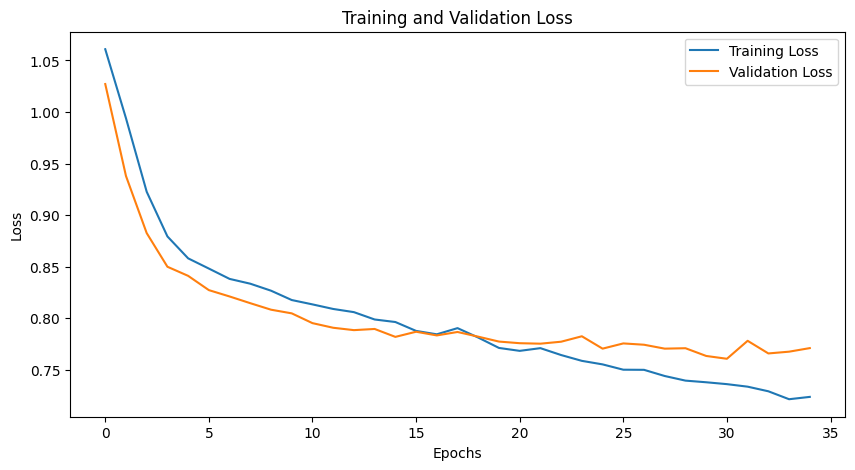

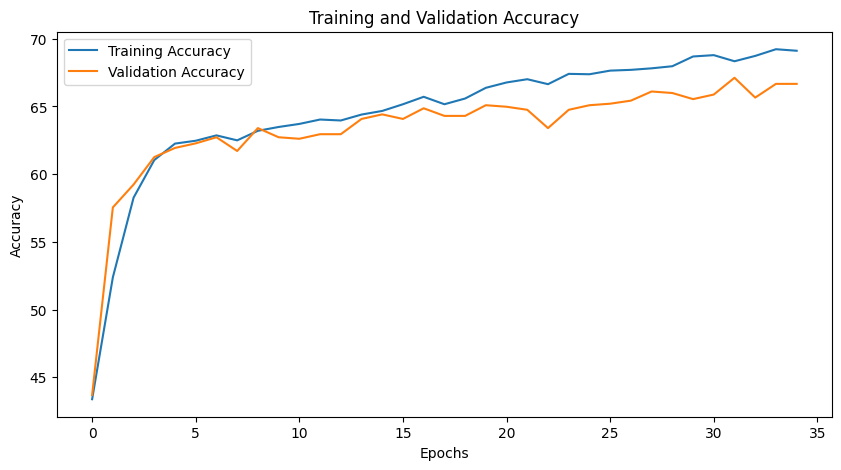


Test Loss: 0.7706, Test Accuracy: 65.37%


In [ ]:
learning_rate = 0.00009
num_epochs = 35

# save hyperparameters to config
model3_3lyr_config = {
    'model_type': 'BiLSTMInteractiveAttn_3layers',
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
}
experiment_name = 'BiLSTMInteractiveAttn_3layers',
config = create_experiment_config(base_config, model3_3lyr_config, experiment_name)

# Initialise model
model_3_3lyr = BiLSTMInteractiveAttn(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product").to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3_3lyr.parameters(), lr=learning_rate)

# Train model
train(model_3_3lyr, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
# Evaluate model 3
  # Using the same data from model 2
test_loss, test_acc, y_true, y_pred = evaluate(model_3_3lyr, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3_3lyr_metrics = get_training_stats(y_true, y_pred, print_stats=False)

#### Attention computation methods

##### 3a. Scaled dot product

Epoch 1:
Training Loss: 0.9248, Training Accuracy: 58.49%
Validation Loss: 0.8608, Validation Accuracy: 61.15%
Epoch 2:
Training Loss: 0.8552, Training Accuracy: 62.40%
Validation Loss: 0.8351, Validation Accuracy: 63.18%
Epoch 3:
Training Loss: 0.8308, Training Accuracy: 63.99%
Validation Loss: 0.8081, Validation Accuracy: 63.18%
Epoch 4:
Training Loss: 0.8080, Training Accuracy: 64.87%
Validation Loss: 0.7828, Validation Accuracy: 64.75%
Epoch 5:
Training Loss: 0.7877, Training Accuracy: 66.22%
Validation Loss: 0.7841, Validation Accuracy: 63.74%
Epoch 6:
Training Loss: 0.7768, Training Accuracy: 66.06%
Validation Loss: 0.7708, Validation Accuracy: 64.86%
Epoch 7:
Training Loss: 0.7615, Training Accuracy: 67.25%
Validation Loss: 0.7938, Validation Accuracy: 63.74%
Epoch 8:
Training Loss: 0.7402, Training Accuracy: 67.87%
Validation Loss: 0.7697, Validation Accuracy: 64.53%
Epoch 9:
Training Loss: 0.7266, Training Accuracy: 67.81%
Validation Loss: 0.7703, Validation Accuracy: 66.33%
E

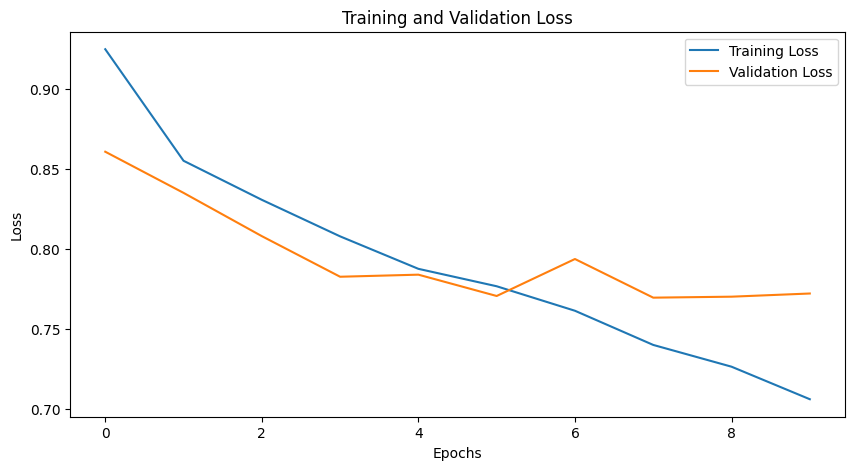

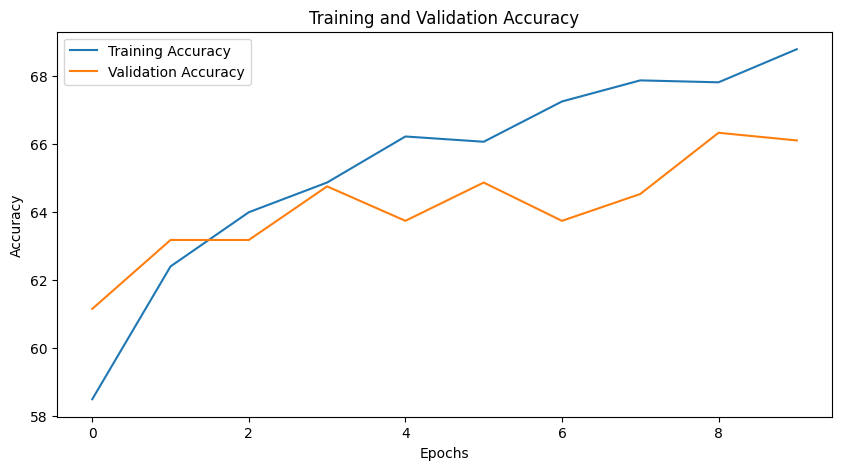


Test Loss: 0.7349, Test Accuracy: 65.82%


In [ ]:
# Define hyperparameters
embedding_dim = emb_matrix.shape[-1]
hidden_dim = 256 # hidden dimension of Bi-LSTM layer
output_dim = 3 # 3 sentiment classes
vocab_size = len(vocab)
learning_rate = 0.005
num_epochs = 10  # To adjust

# save hyperparameters to config
model3a_config = {
    'model_type': 'BiLSTMInteractiveAttn_scaled_dot_prod',
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'vocab_size': len(vocab),
    'embedding_dim': embedding_dim,
    'hidden_dim': hidden_dim,
    'output_dim': output_dim,
    'preprocessing_config': config # save preprocessing config with trained model
}
experiment_name = 'BiLSTMInteractiveAttn_scaled_dot_prod'
config = create_experiment_config(base_config, model3a_config, experiment_name)

# Initialise model
model_3a = BiLSTMInteractiveAttn(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "scaled_dot_product").to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3a.parameters(), lr=learning_rate)

# Train model
train(model_3a, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
# Evaluate model
test_loss, test_acc, y_true, y_pred = evaluate(model_3a, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3a_metrics = get_training_stats(y_true, y_pred, print_stats=False)

##### 3b. Cosine similarity

Epoch 1:
Training Loss: 0.9218, Training Accuracy: 58.45%
Validation Loss: 0.8863, Validation Accuracy: 58.11%
Epoch 2:
Training Loss: 0.8456, Training Accuracy: 63.02%
Validation Loss: 0.8052, Validation Accuracy: 63.96%
Epoch 3:
Training Loss: 0.8153, Training Accuracy: 64.22%
Validation Loss: 0.8214, Validation Accuracy: 63.96%
Epoch 4:
Training Loss: 0.7931, Training Accuracy: 65.75%
Validation Loss: 0.7721, Validation Accuracy: 66.33%
Epoch 5:
Training Loss: 0.7658, Training Accuracy: 67.15%
Validation Loss: 0.7493, Validation Accuracy: 67.57%
Epoch 6:
Training Loss: 0.7448, Training Accuracy: 67.80%
Validation Loss: 0.7435, Validation Accuracy: 67.91%
Epoch 7:
Training Loss: 0.7233, Training Accuracy: 69.17%
Validation Loss: 0.7348, Validation Accuracy: 68.47%
Epoch 8:
Training Loss: 0.6887, Training Accuracy: 70.24%
Validation Loss: 0.7131, Validation Accuracy: 69.48%
Epoch 9:
Training Loss: 0.6604, Training Accuracy: 72.40%
Validation Loss: 0.7320, Validation Accuracy: 67.68%
E

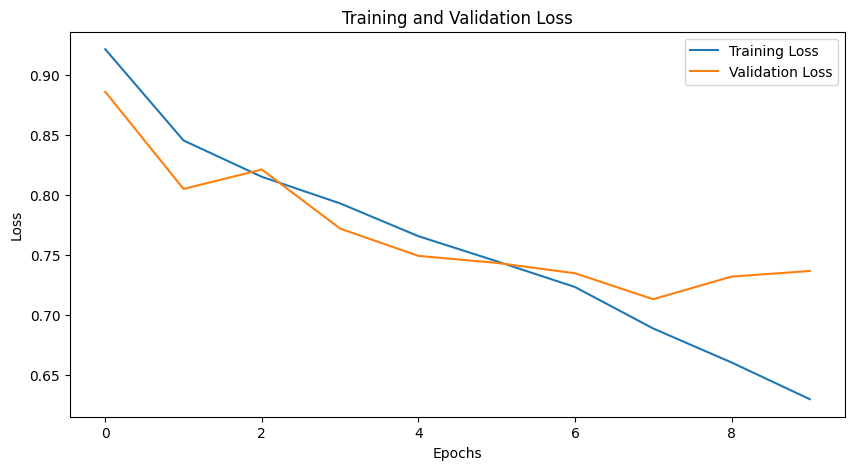

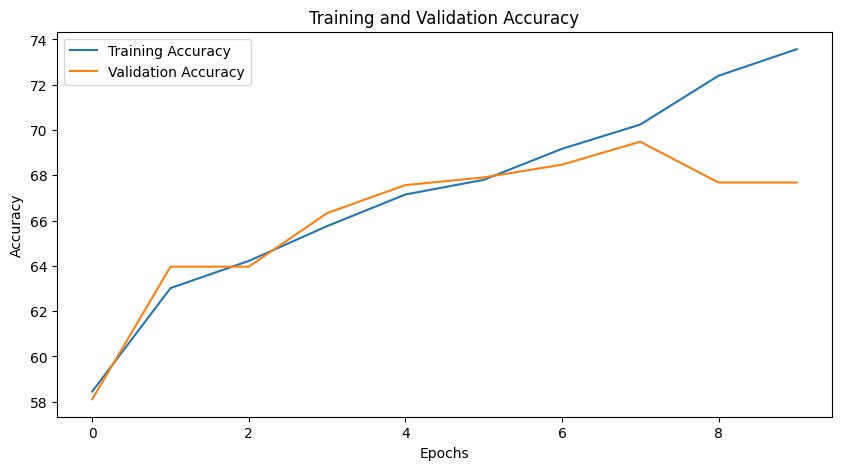


Test Loss: 0.7451, Test Accuracy: 66.48%


In [ ]:
model3b_config = {
    'model_type': 'BiLSTMInteractiveAttn_cos_sim',
}

experiment_name = 'BiLSTMInteractiveAttn_cos_sim'
config = create_experiment_config(base_config, model3b_config, experiment_name)

# Initialise model
model_3b = BiLSTMInteractiveAttn(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "cos_sim").to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3b.parameters(), lr=learning_rate)

# Train model
train(model_3b, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
# Evaluate model
test_loss, test_acc, y_true, y_pred = evaluate(model_3b, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3b_metrics = get_training_stats(y_true, y_pred, print_stats=False)

##### 3c. General

Epoch 1:
Training Loss: 0.9099, Training Accuracy: 58.93%
Validation Loss: 0.8353, Validation Accuracy: 64.30%
Epoch 2:
Training Loss: 0.8441, Training Accuracy: 62.72%
Validation Loss: 0.8058, Validation Accuracy: 63.74%
Epoch 3:
Training Loss: 0.7999, Training Accuracy: 65.40%
Validation Loss: 0.7577, Validation Accuracy: 67.12%
Epoch 4:
Training Loss: 0.7523, Training Accuracy: 68.21%
Validation Loss: 0.7252, Validation Accuracy: 69.59%
Epoch 5:
Training Loss: 0.7030, Training Accuracy: 70.18%
Validation Loss: 0.6938, Validation Accuracy: 70.72%
Epoch 6:
Training Loss: 0.6637, Training Accuracy: 72.03%
Validation Loss: 0.7165, Validation Accuracy: 69.26%
Epoch 7:
Training Loss: 0.6241, Training Accuracy: 73.84%
Validation Loss: 0.6638, Validation Accuracy: 71.85%
Epoch 8:
Training Loss: 0.5870, Training Accuracy: 75.56%
Validation Loss: 0.6846, Validation Accuracy: 70.72%
Epoch 9:
Training Loss: 0.5329, Training Accuracy: 78.39%
Validation Loss: 0.6826, Validation Accuracy: 71.96%
E

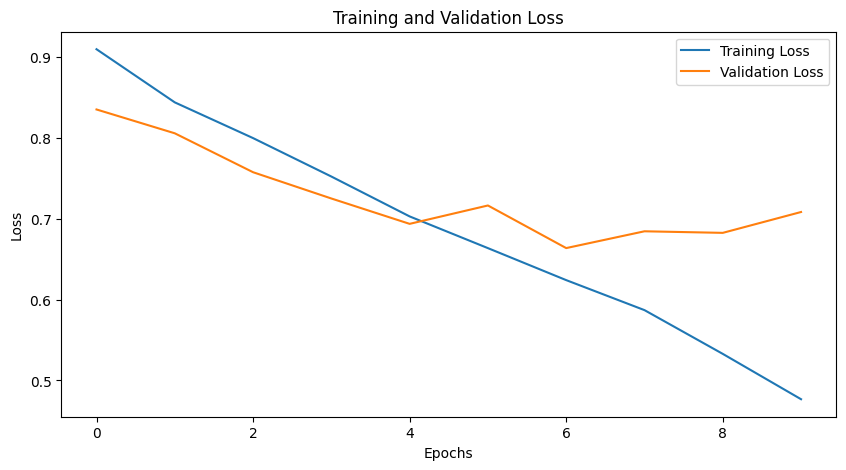

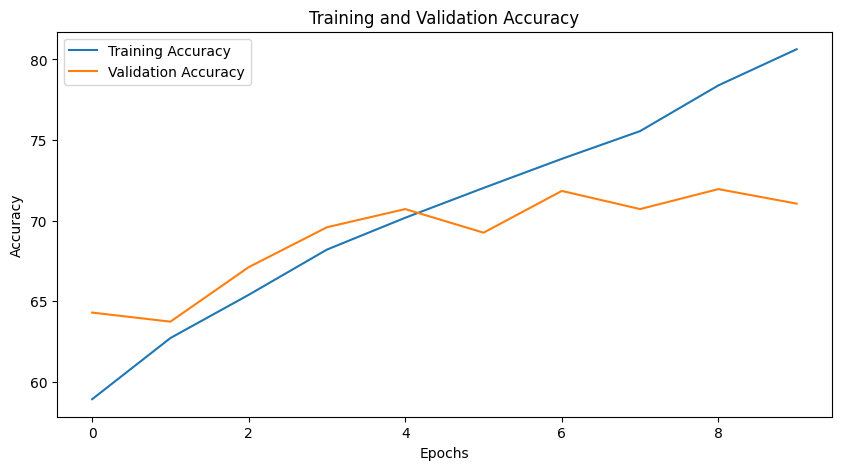


Test Loss: 0.7357, Test Accuracy: 70.70%


In [ ]:
model3c_config = {
    'model_type': 'BiLSTMInteractiveAttn_general',
}

experiment_name = 'BiLSTMInteractiveAttn_general'
config = create_experiment_config(base_config, model3c_config, experiment_name)

# Initialise model
model_3c = BiLSTMInteractiveAttn(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "general").to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3c.parameters(), lr=learning_rate)

# Train model
train(model_3c, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
# Evaluate model
test_loss, test_acc, y_true, y_pred = evaluate(model_3c, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3c_metrics = get_training_stats(y_true, y_pred, print_stats=False)

##### 3d. Location-based

Epoch 1:
Training Loss: 0.9506, Training Accuracy: 57.50%
Validation Loss: 0.9029, Validation Accuracy: 59.91%
Epoch 2:
Training Loss: 0.9240, Training Accuracy: 59.10%
Validation Loss: 0.9024, Validation Accuracy: 59.91%
Epoch 3:
Training Loss: 0.9234, Training Accuracy: 59.06%
Validation Loss: 0.9013, Validation Accuracy: 59.91%
Epoch 4:
Training Loss: 0.9276, Training Accuracy: 59.24%
Validation Loss: 0.9043, Validation Accuracy: 59.91%
Epoch 5:
Training Loss: 0.9222, Training Accuracy: 59.29%
Validation Loss: 0.9040, Validation Accuracy: 59.91%
Epoch 6:
Training Loss: 0.9240, Training Accuracy: 59.24%
Validation Loss: 0.9021, Validation Accuracy: 59.91%
Epoch 7:
Training Loss: 0.9238, Training Accuracy: 59.24%
Validation Loss: 0.9124, Validation Accuracy: 59.91%
Epoch 8:
Training Loss: 0.9251, Training Accuracy: 59.10%
Validation Loss: 0.9085, Validation Accuracy: 59.91%
Epoch 9:
Training Loss: 0.9240, Training Accuracy: 59.24%
Validation Loss: 0.9048, Validation Accuracy: 59.91%
E

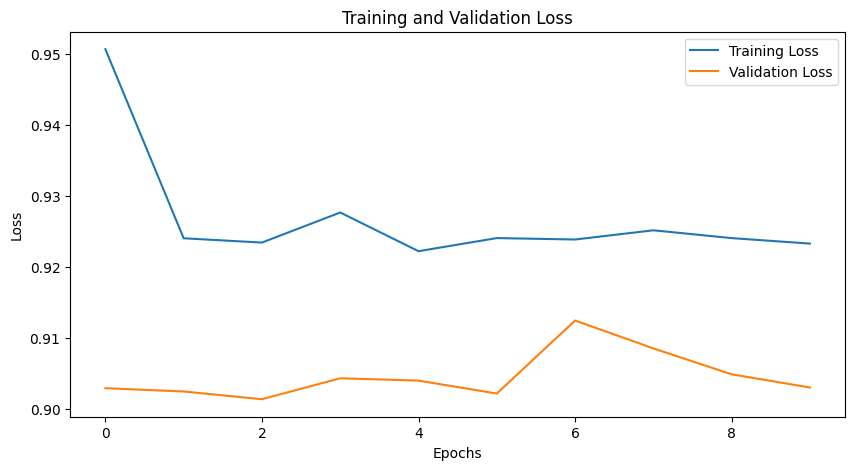

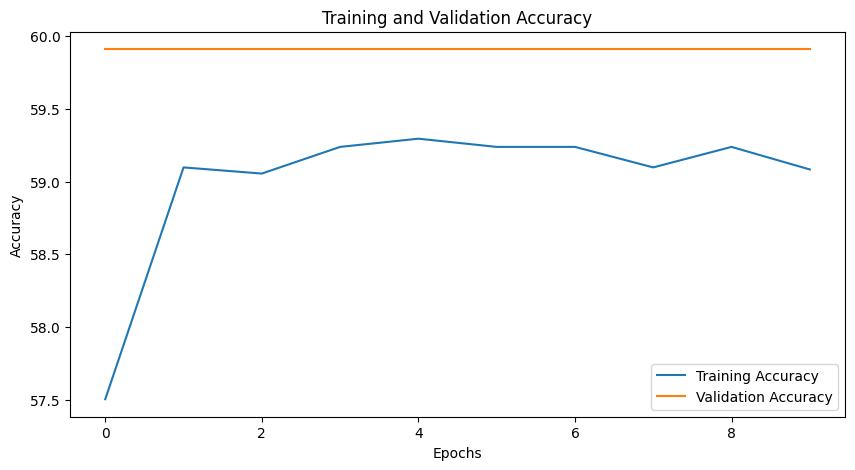


Test Loss: 0.9156, Test Accuracy: 58.71%


In [ ]:
model3d_config = {
    'model_type': 'BiLSTMInteractiveAttn_location_based',
}

experiment_name = 'BiLSTMInteractiveAttn_location_based'
config = create_experiment_config(base_config, model3d_config, experiment_name)

# Initialise model
model_3d = BiLSTMInteractiveAttn(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "location_based").to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3d.parameters(), lr=learning_rate)

# Train model
train(model_3d, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
# Evaluate model
test_loss, test_acc, y_true, y_pred = evaluate(model_3d, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3d_metrics = get_training_stats(y_true, y_pred, print_stats=False)

##### 3e. Additive

Current function does not work due to different dimensions in A2S attention and S2A attention

#### Attention mechanism

##### 3f. Self-attention, residual connection, then cross-attention

Less stable compared to model with normalisation. Reduced learning rate to aid convergence.

In [ ]:
class BiLSTMInteractiveAttn_ResidConn(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, attn_method, num_layers=1):
        super(BiLSTMInteractiveAttn_ResidConn, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        # Bi-LSTM layers
        self.sent_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=0.2)
        self.asp_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True,num_layers=num_layers, dropout=0.2)
        # Self Attention
        self.self_attention = Attention(attn_method, hidden_dim, self_attn=True, input_dim=hidden_dim * 2)
        # Attention
        self.attn = Attention(attn_method, hidden_dim)
        # Output layer
        self.linear = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, sentence, aspect):
        # Embed sentences and aspects
        sent_embedding = self.embedding(sentence)
        asp_embedding = self.embedding(aspect)
        asp_embedding = asp_embedding.unsqueeze(1) # Add sequence dimension -> [batch_size, 1, embedding_dim]

        # Pass sentences and aspects through different Bi-LSTM networks
        sent_lstm_output, _ = self.sent_lstm(sent_embedding)
        asp_lstm_output, _ = self.asp_lstm(asp_embedding)

        # Apply self-attention on sentence
        sent_self_attn_output, _ = self.self_attention(sent_lstm_output, sent_lstm_output, sent_lstm_output)

        # Add residual connections
        sent_lstm_output = sent_lstm_output + sent_self_attn_output

        # Aspect to Sentence Attention
        a2s_attn_output, a2s_attn_weights = self.attn(asp_lstm_output, sent_lstm_output, sent_lstm_output)
        # Sentence to Aspect Attention
        s2a_attn_output, s2a_attn_weights = self.attn(sent_lstm_output, asp_lstm_output, asp_lstm_output)

        # Apply mean pooling to match dimensions of attention outputs  -> [batch_size, hidden_dim * 2]
        a2s_attn_output = a2s_attn_output.mean(dim=1)
        s2a_attn_output = s2a_attn_output.mean(dim=1)

        # Combine attention outputs of sentence and aspect -> [batch_size, hidden_dim * 4]
        combined_output = torch.cat((a2s_attn_output, s2a_attn_output), dim=1)

        # Apply linear transformation to output layer
        output = self.linear(combined_output)

        return output, a2s_attn_weights

Epoch 1:
Training Loss: 0.9341, Training Accuracy: 56.28%
Validation Loss: 0.8390, Validation Accuracy: 61.60%
Epoch 2:
Training Loss: 0.8340, Training Accuracy: 63.46%
Validation Loss: 0.7907, Validation Accuracy: 63.51%
Epoch 3:
Training Loss: 0.8000, Training Accuracy: 65.85%
Validation Loss: 0.7734, Validation Accuracy: 65.88%
Epoch 4:
Training Loss: 0.7847, Training Accuracy: 65.59%
Validation Loss: 0.7954, Validation Accuracy: 65.77%
Epoch 5:
Training Loss: 0.7507, Training Accuracy: 67.55%
Validation Loss: 0.7526, Validation Accuracy: 67.45%
Epoch 6:
Training Loss: 0.7210, Training Accuracy: 69.17%
Validation Loss: 0.7290, Validation Accuracy: 69.48%
Epoch 7:
Training Loss: 0.7009, Training Accuracy: 69.96%
Validation Loss: 0.7378, Validation Accuracy: 66.55%
Epoch 8:
Training Loss: 0.6720, Training Accuracy: 71.79%
Validation Loss: 0.7423, Validation Accuracy: 69.93%
Epoch 9:
Training Loss: 0.6641, Training Accuracy: 71.71%
Validation Loss: 0.7250, Validation Accuracy: 70.72%
E

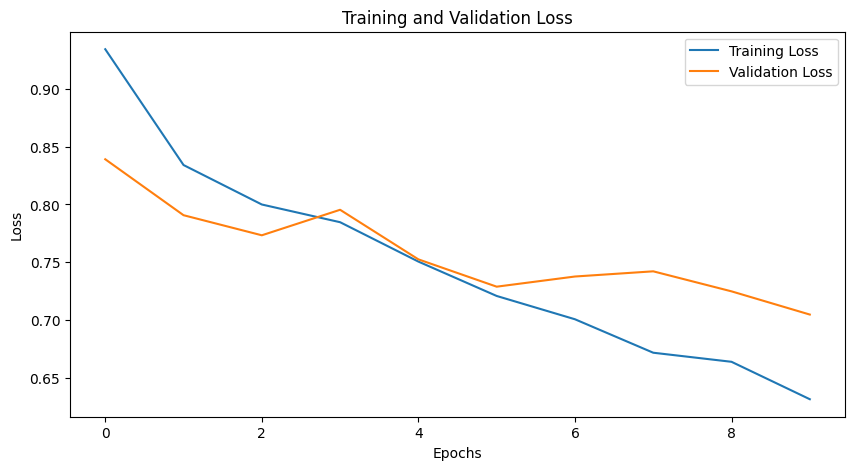

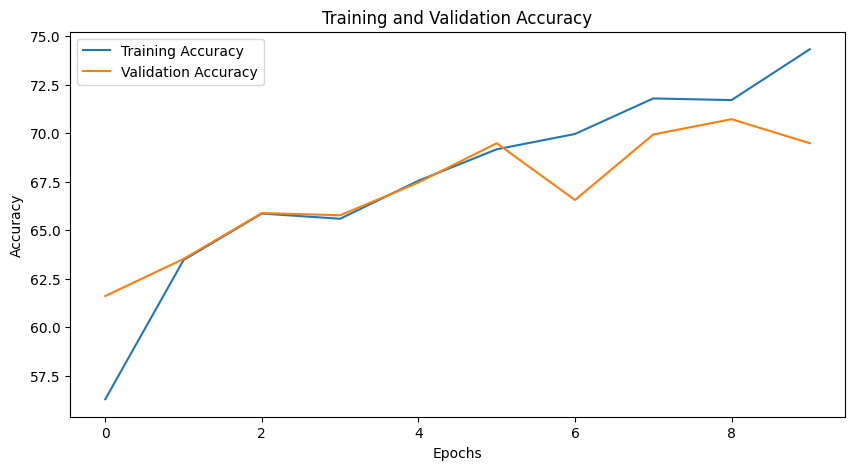


Test Loss: 0.7352, Test Accuracy: 71.48%


In [ ]:
learning_rate = 0.001
model3f_config = {
    'model_type': 'BiLSTMInteractiveAttn_ResidualConnection',
    'learning_rate': learning_rate,
}

experiment_name = 'BiLSTMInteractive_ResidualConnection'
config = create_experiment_config(base_config, model3f_config, experiment_name)

model_3f = BiLSTMInteractiveAttn_ResidConn(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product").to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3f.parameters(), lr=learning_rate)

# Train model and evaluate
train(model_3f, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_3f, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3f_metrics = get_training_stats(y_true, y_pred, print_stats=False)


##### 3g. Self attention, residual connection, layer normalisation, then cross-attention

In [ ]:
class BiLSTMInteractiveAttn_AddNor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, attn_method):
        super(BiLSTMInteractiveAttn_AddNor, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        # Bi-LSTM layers
        self.sent_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=0.2)
        self.asp_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=0.2)
        # Self Attention
        self.self_attention = Attention(attn_method, hidden_dim, self_attn=True, input_dim=hidden_dim * 2)
        # Residual Connection and Layer Normalisation
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        # Cross Attention
        self.attn = Attention(attn_method)
        # Output layer
        self.linear = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, sentence, aspect):
        # Embed sentences and aspects
        sent_embedding = self.embedding(sentence)
        asp_embedding = self.embedding(aspect)
        asp_embedding = asp_embedding.unsqueeze(1) # Add sequence dimension -> [batch_size, 1, embedding_dim]

        # Pass sentences and aspects through different Bi-LSTM networks
        sent_lstm_output, _ = self.sent_lstm(sent_embedding)
        asp_lstm_output, _ = self.asp_lstm(asp_embedding)

        # Self Attention on Sentence
        sent_self_attn_output, _ = self.self_attention(sent_lstm_output, sent_lstm_output, sent_lstm_output)  # [batch_size, seq_length, hidden_dim * 2]
        # Residual connection and layer normalisation after Self-Attention
        sent_self_attn_output = self.layer_norm(sent_self_attn_output + sent_lstm_output)

        # Aspect to Sentence Attention
        attn_output1, attn_weights1 = self.attn(asp_lstm_output, sent_self_attn_output, sent_self_attn_output)
        # Sentence to Aspect Attention
        attn_output2, attn_weights2 = self.attn(sent_self_attn_output, asp_lstm_output, asp_lstm_output)

        # Apply mean pooling to match dimensions of attention outputs  -> [batch_size, hidden_dim * 2]
        attn_output1 = attn_output1.mean(dim=1)
        attn_output2 = attn_output2.mean(dim=1)

        # Combine attention outputs of sentence and aspect -> [batch_size, hidden_dim * 4]
        combined_output = torch.cat((attn_output1, attn_output2), dim=1)

        # Apply linear transformation to output layer
        output = self.linear(combined_output)

        return output, attn_weights1

Epoch 1:
Training Loss: 0.9918, Training Accuracy: 55.61%
Validation Loss: 0.8180, Validation Accuracy: 63.63%
Epoch 2:
Training Loss: 0.7931, Training Accuracy: 65.84%
Validation Loss: 0.7560, Validation Accuracy: 68.47%
Epoch 3:
Training Loss: 0.7399, Training Accuracy: 68.60%
Validation Loss: 0.7315, Validation Accuracy: 70.38%
Epoch 4:
Training Loss: 0.6922, Training Accuracy: 70.72%
Validation Loss: 0.7470, Validation Accuracy: 69.37%
Epoch 5:
Training Loss: 0.6629, Training Accuracy: 72.69%
Validation Loss: 0.7015, Validation Accuracy: 71.28%
Epoch 6:
Training Loss: 0.6338, Training Accuracy: 74.06%
Validation Loss: 0.6893, Validation Accuracy: 72.52%
Epoch 7:
Training Loss: 0.5876, Training Accuracy: 76.16%
Validation Loss: 0.7474, Validation Accuracy: 71.85%
Epoch 8:
Training Loss: 0.5458, Training Accuracy: 78.03%
Validation Loss: 0.7303, Validation Accuracy: 71.96%
Epoch 9:
Training Loss: 0.5300, Training Accuracy: 78.89%
Validation Loss: 0.7364, Validation Accuracy: 71.51%
E

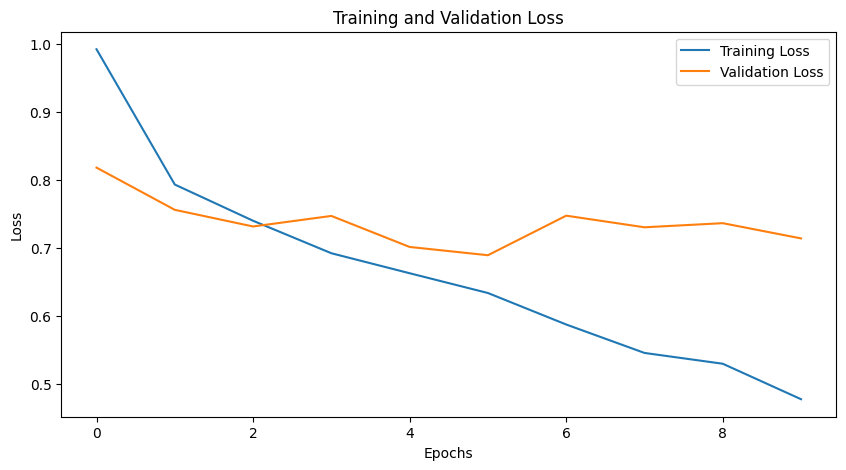

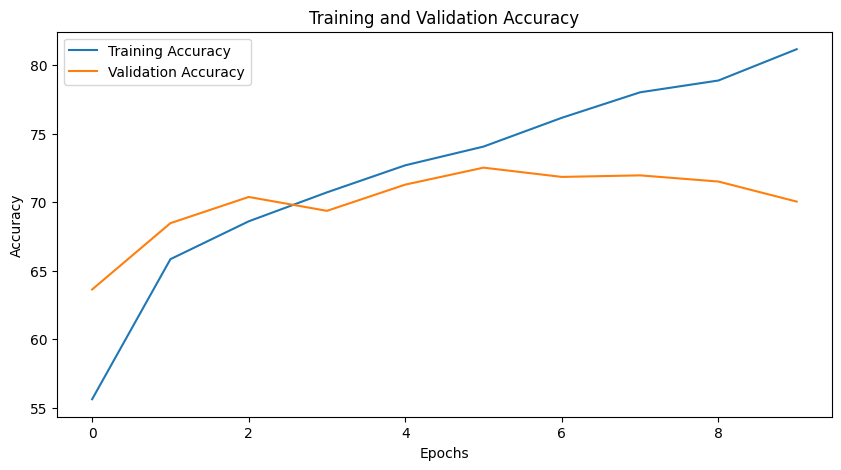


Test Loss: 0.6818, Test Accuracy: 71.92%


In [ ]:
learning_rate = 0.002

model3g_config = {
    'model_type': 'BiLSTMInteractiveAttnAddNor',
    'learning_rate': learning_rate,
}

experiment_name = 'BiLSTMInteractiveAttnAddNor'
config = create_experiment_config(base_config, model3g_config, experiment_name)

# Initialise model
model_3g = BiLSTMInteractiveAttn_AddNor(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product").to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3g.parameters(), lr=learning_rate)

# Train model and evaluate
train(model_3g, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_3g, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3g_metrics = get_training_stats(y_true, y_pred, print_stats=False)

##### 3h. No self-attention, cross-attention then residual connection

In [ ]:
class BiLSTMInteractiveAttn_NoSelf_ResConn(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, attn_method):
        super(BiLSTMInteractiveAttn_NoSelf_ResConn, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        # Bi-LSTM layers
        self.sent_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=0.2)
        self.asp_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True,num_layers=num_layers, dropout=0.2)
        # Attention
        self.attn = Attention(attn_method, hidden_dim)
        # Output layer
        self.linear = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, sentence, aspect):
        # Embed sentences and aspects
        sent_embedding = self.embedding(sentence)
        asp_embedding = self.embedding(aspect)
        asp_embedding = asp_embedding.unsqueeze(1) # Add sequence dimension -> [batch_size, 1, embedding_dim]

        # Pass sentences and aspects through different Bi-LSTM networks
        sent_lstm_output, _ = self.sent_lstm(sent_embedding)
        asp_lstm_output, _ = self.asp_lstm(asp_embedding)

        # Aspect to Sentence Attention
        a2s_attn_output, a2s_attn_weights = self.attn(asp_lstm_output, sent_lstm_output, sent_lstm_output)
        # Sentence to Aspect Attention
        s2a_attn_output, s2a_attn_weights = self.attn(sent_lstm_output, asp_lstm_output, asp_lstm_output)

        # Apply residual connection by adding original LSTM outputs
        a2s_attn_output = a2s_attn_output + asp_lstm_output
        s2a_attn_output = s2a_attn_output + sent_lstm_output

        # Apply mean pooling to match dimensions of attention outputs  -> [batch_size, hidden_dim * 2]
        a2s_attn_output = a2s_attn_output.mean(dim=1)
        s2a_attn_output = s2a_attn_output.mean(dim=1)

        # Combine attention outputs of sentence and aspect -> [batch_size, hidden_dim * 4]
        combined_output = torch.cat((a2s_attn_output, s2a_attn_output), dim=1)

        # Apply linear transformation to output layer
        output = self.linear(combined_output)

        return output, a2s_attn_weights

Epoch 1:
Training Loss: 0.9220, Training Accuracy: 57.93%
Validation Loss: 0.8394, Validation Accuracy: 61.82%
Epoch 2:
Training Loss: 0.8427, Training Accuracy: 62.83%
Validation Loss: 0.7809, Validation Accuracy: 65.43%
Epoch 3:
Training Loss: 0.8069, Training Accuracy: 64.92%
Validation Loss: 0.7678, Validation Accuracy: 64.86%
Epoch 4:
Training Loss: 0.7745, Training Accuracy: 66.57%
Validation Loss: 0.7428, Validation Accuracy: 67.12%
Epoch 5:
Training Loss: 0.7294, Training Accuracy: 68.29%
Validation Loss: 0.7006, Validation Accuracy: 70.83%
Epoch 6:
Training Loss: 0.6819, Training Accuracy: 70.75%
Validation Loss: 0.6911, Validation Accuracy: 70.38%
Epoch 7:
Training Loss: 0.6330, Training Accuracy: 73.34%
Validation Loss: 0.6621, Validation Accuracy: 72.75%
Epoch 8:
Training Loss: 0.5817, Training Accuracy: 75.63%
Validation Loss: 0.6627, Validation Accuracy: 74.66%
Epoch 9:
Training Loss: 0.5255, Training Accuracy: 77.56%
Validation Loss: 0.6936, Validation Accuracy: 72.30%
E

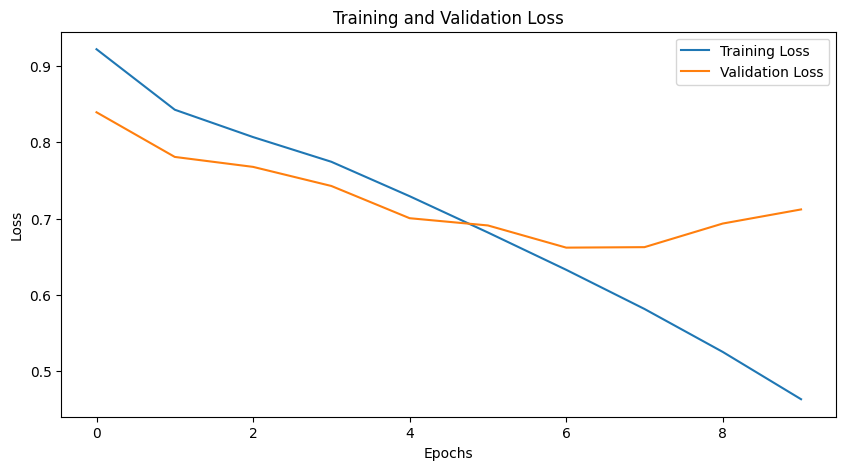

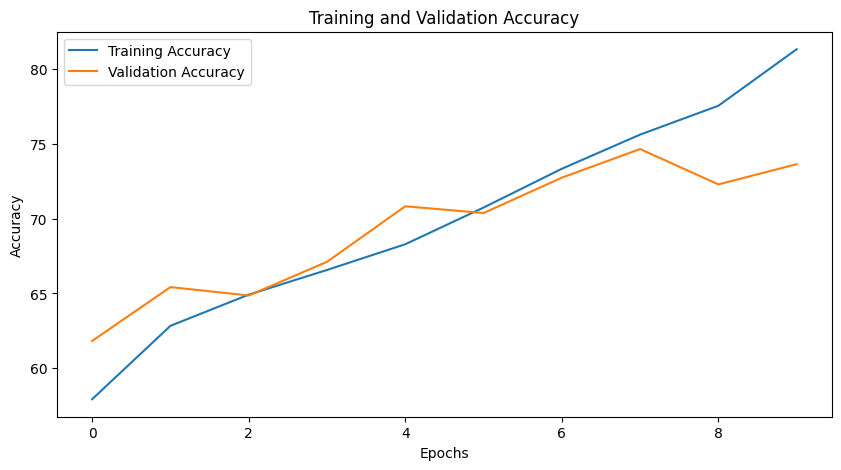


Test Loss: 0.7057, Test Accuracy: 72.48%


In [ ]:
learning_rate = 0.0015

model3h_config = {
    'model_type': 'BiLSTMInteractiveAttn_NoSelfAttnResConn',
    'learning_rate': learning_rate,
}

experiment_name = 'BiLSTMInteractiveAttn_NoSelfAttnResConn'
config = create_experiment_config(base_config, model3h_config, experiment_name)

# Initialise model
model_3h = BiLSTMInteractiveAttn_NoSelf_ResConn(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product").to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3h.parameters(), lr=learning_rate)

# Train model and evaluate
train(model_3h, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_3h, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3h_metrics = get_training_stats(y_true, y_pred, print_stats=False)

##### 3i. No self-attention, cross-attention then residual connection, layer-normalisation

In [ ]:
class BiLSTMInteractiveAttn_NoSelf_ResConnLayNorm(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, attn_method):
        super(BiLSTMInteractiveAttn_NoSelf_ResConnLayNorm, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        # Bi-LSTM layers
        self.sent_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=0.2)
        self.asp_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True,num_layers=num_layers, dropout=0.2)
        # Attention
        self.attn = Attention(attn_method, hidden_dim)
        # Residual Connection and Layer Normalisation
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        # Output layer
        self.linear = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, sentence, aspect):
        # Embed sentences and aspects
        sent_embedding = self.embedding(sentence)
        asp_embedding = self.embedding(aspect)
        asp_embedding = asp_embedding.unsqueeze(1) # Add sequence dimension -> [batch_size, 1, embedding_dim]

        # Pass sentences and aspects through different Bi-LSTM networks
        sent_lstm_output, _ = self.sent_lstm(sent_embedding)
        asp_lstm_output, _ = self.asp_lstm(asp_embedding)

        # Aspect to Sentence Attention
        a2s_attn_output, a2s_attn_weights = self.attn(asp_lstm_output, sent_lstm_output, sent_lstm_output)
        # Sentence to Aspect Attention
        s2a_attn_output, s2a_attn_weights = self.attn(sent_lstm_output, asp_lstm_output, asp_lstm_output)

        # Apply residual connection and layer normalisation
        a2s_attn_output = self.layer_norm(a2s_attn_output + asp_lstm_output)
        s2a_attn_output = self.layer_norm(s2a_attn_output + sent_lstm_output)

        # Apply mean pooling to match dimensions of attention outputs  -> [batch_size, hidden_dim * 2]
        a2s_attn_output = a2s_attn_output.mean(dim=1)
        s2a_attn_output = s2a_attn_output.mean(dim=1)

        # Combine attention outputs of sentence and aspect -> [batch_size, hidden_dim * 4]
        combined_output = torch.cat((a2s_attn_output, s2a_attn_output), dim=1)

        # Apply linear transformation to output layer
        output = self.linear(combined_output)

        return output, a2s_attn_weights

Epoch 1:
Training Loss: 0.9548, Training Accuracy: 57.67%
Validation Loss: 0.8617, Validation Accuracy: 61.60%
Epoch 2:
Training Loss: 0.8452, Training Accuracy: 63.88%
Validation Loss: 0.8068, Validation Accuracy: 62.73%
Epoch 3:
Training Loss: 0.8165, Training Accuracy: 64.54%
Validation Loss: 0.7988, Validation Accuracy: 64.86%
Epoch 4:
Training Loss: 0.7821, Training Accuracy: 66.78%
Validation Loss: 0.7489, Validation Accuracy: 67.91%
Epoch 5:
Training Loss: 0.7630, Training Accuracy: 67.60%
Validation Loss: 0.7327, Validation Accuracy: 69.37%
Epoch 6:
Training Loss: 0.7333, Training Accuracy: 68.66%
Validation Loss: 0.6904, Validation Accuracy: 70.83%
Epoch 7:
Training Loss: 0.6890, Training Accuracy: 70.35%
Validation Loss: 0.6753, Validation Accuracy: 71.96%
Epoch 8:
Training Loss: 0.6512, Training Accuracy: 72.21%
Validation Loss: 0.6743, Validation Accuracy: 71.28%
Epoch 9:
Training Loss: 0.6074, Training Accuracy: 74.65%
Validation Loss: 0.6672, Validation Accuracy: 72.41%
E

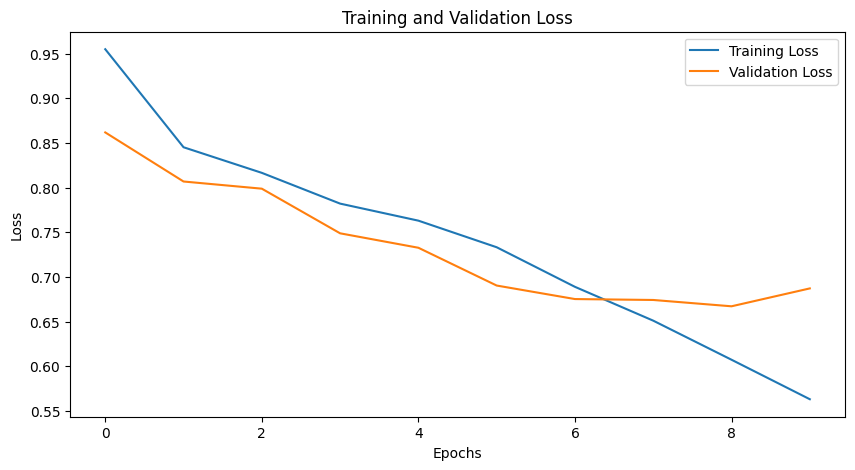

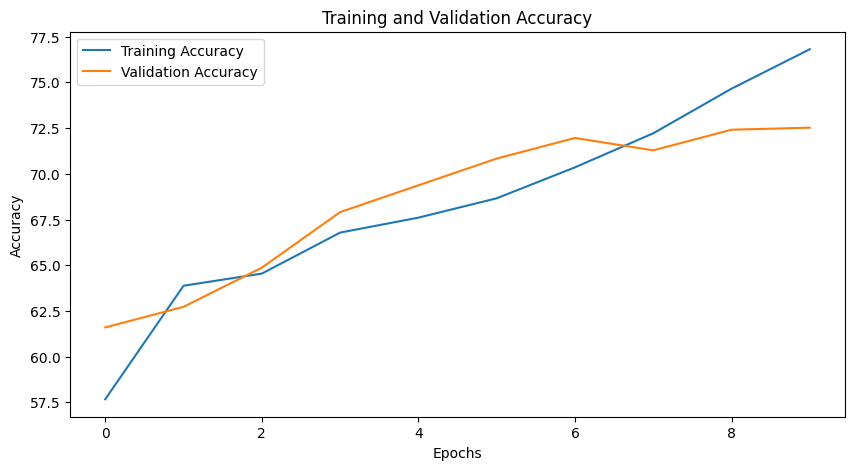


Test Loss: 0.6935, Test Accuracy: 72.25%


In [ ]:
learning_rate = 0.001

model3i_config = {
    'model_type': 'BiLSTMInteractiveAttn_NoSelfAttnResConnLayNorm',
    'learning_rate': learning_rate,
}

experiment_name = 'BiLSTMInteractiveAttn_NoSelfAttnResConnLayNorm'
config = create_experiment_config(base_config, model3i_config, experiment_name)

# Initialise model
model_3i = BiLSTMInteractiveAttn_NoSelf_ResConnLayNorm(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product").to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3i.parameters(), lr=learning_rate)

# Train model and evaluate
train(model_3i, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
test_loss, test_acc, y_true, y_pred = evaluate(model_3i, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3i_metrics = get_training_stats(y_true, y_pred, print_stats=False)

##### 3j. Self-attention only


In [ ]:
class BiLSTMInteractiveAttn_SelfAttn(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, attn_method, num_layers=1):
        super(BiLSTMInteractiveAttn_SelfAttn, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        # Bi-LSTM layers
        self.sent_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=0.2)
        self.asp_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True,num_layers=num_layers, dropout=0.2)
        # Self Attention
        self.self_attention = Attention(attn_method, hidden_dim, self_attn=True, input_dim=hidden_dim * 2)
        # Attention
        self.attn = Attention(attn_method, hidden_dim)
        # Output layer
        self.linear = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, sentence, aspect):
        # Embed sentences and aspects
        sent_embedding = self.embedding(sentence)
        asp_embedding = self.embedding(aspect)
        asp_embedding = asp_embedding.unsqueeze(1) # Add sequence dimension -> [batch_size, 1, embedding_dim]

        # Pass sentences and aspects through different Bi-LSTM networks
        sent_lstm_output, _ = self.sent_lstm(sent_embedding)
        asp_lstm_output, _ = self.asp_lstm(asp_embedding)

        # Apply self-attention on sentence
        sent_self_attn_output, _ = self.self_attention(sent_lstm_output, sent_lstm_output, sent_lstm_output)

        # Aspect to Sentence Attention
        a2s_attn_output, a2s_attn_weights = self.attn(asp_lstm_output, sent_self_attn_output, sent_self_attn_output)
        # Sentence to Aspect Attention
        s2a_attn_output, s2a_attn_weights = self.attn(sent_self_attn_output, asp_lstm_output, asp_lstm_output)

        # Apply mean pooling to match dimensions of attention outputs  -> [batch_size, hidden_dim * 2]
        a2s_attn_output = a2s_attn_output.mean(dim=1)
        s2a_attn_output = s2a_attn_output.mean(dim=1)

        # Combine attention outputs of sentence and aspect -> [batch_size, hidden_dim * 4]
        combined_output = torch.cat((a2s_attn_output, s2a_attn_output), dim=1)

        # Apply linear transformation to output layer
        output = self.linear(combined_output)

        return output, a2s_attn_weights

Epoch 1:
Training Loss: 0.9334, Training Accuracy: 56.97%
Validation Loss: 0.8646, Validation Accuracy: 60.70%
Epoch 2:
Training Loss: 0.8493, Training Accuracy: 62.21%
Validation Loss: 0.8447, Validation Accuracy: 62.16%
Epoch 3:
Training Loss: 0.8239, Training Accuracy: 64.06%
Validation Loss: 0.7858, Validation Accuracy: 64.53%
Epoch 4:
Training Loss: 0.7888, Training Accuracy: 65.99%
Validation Loss: 0.7650, Validation Accuracy: 65.99%
Epoch 5:
Training Loss: 0.7553, Training Accuracy: 67.39%
Validation Loss: 0.7601, Validation Accuracy: 67.12%
Epoch 6:
Training Loss: 0.7328, Training Accuracy: 68.79%
Validation Loss: 0.7412, Validation Accuracy: 68.58%
Epoch 7:
Training Loss: 0.7094, Training Accuracy: 69.83%
Validation Loss: 0.7419, Validation Accuracy: 68.36%
Epoch 8:
Training Loss: 0.6855, Training Accuracy: 70.35%
Validation Loss: 0.7546, Validation Accuracy: 68.81%
Epoch 9:
Training Loss: 0.6569, Training Accuracy: 72.31%
Validation Loss: 0.7353, Validation Accuracy: 68.58%
E

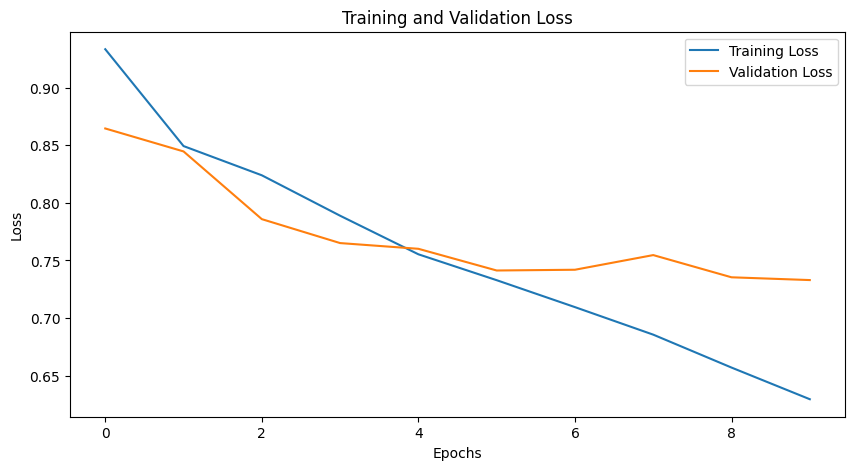

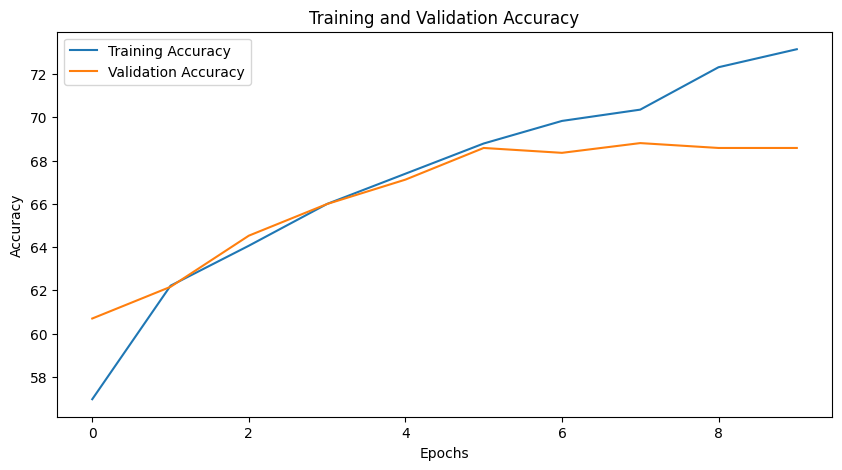


Test Loss: 0.7072, Test Accuracy: 70.14%


In [232]:
# Define hyperparameters
embedding_dim = emb_matrix.shape[-1]
hidden_dim = 256 # hidden dimension of Bi-LSTM layer
output_dim = 3 # 3 sentiment classes
vocab_size = len(vocab)
learning_rate = 0.001
num_epochs = 10  # To adjust

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# save hyperparameters to config
model3j_config = {
    'model_type': 'BiLSTMInteractiveAttn_SelfAttn',
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'vocab_size': len(vocab),
    'embedding_dim': embedding_dim,
    'hidden_dim': hidden_dim,
    'output_dim': output_dim,
    'preprocessing_config': config # save preprocessing config with trained model
}
experiment_name = 'BiLSTMInteractiveAttn_SelfAttn',
config = create_experiment_config(base_config, model3j_config, experiment_name)

# Initialise model
model_3j = BiLSTMInteractiveAttn_SelfAttn(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product").to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3j.parameters(), lr=learning_rate)

# Train model
train(model_3j, m2_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True)
print()
# Evaluate model 3
  # Using the same data from model 2
test_loss, test_acc, y_true, y_pred = evaluate(model_3j, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3j_metrics = get_training_stats(y_true, y_pred, print_stats=False)

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## 3.1 Testing and Evaluation Functions

In [ ]:
def get_attention_weights(model, input_text, vocab):
    """
    Pass the input text through the model and get the attention weights.
    """
    input_indices = torch.tensor([[vocab.get(word, vocab['<UNK>']) for word in input_text]]).to(device)
    with torch.no_grad():
        _, attention_weights = model(input_indices)
    return attention_weights

def visualize_attention_heatmap(sentence, attention_weights, mask=None):
    """
    Visualize the attention weights using a heatmap.
    Mask is used to exclude the padding tokens from the labels to clearly view the distribution of attention among actual words.

    The mask is applied to both rows and columns of the attention weights using mask[:, np.newaxis] * mask[np.newaxis, :].
    The padding tokens are filtered out from the sentence list based on the mask.
    The attention weights are filtered to match the non-padded parts of the sentence using np.ix_ to select the appropriate indices.
    """
    attention_weights = attention_weights.squeeze(0).cpu().numpy() # (seq_len, seq_len)
    if mask is not None:
        mask = mask.squeeze(0).cpu().numpy() # (seq_len,)
        # appy mask to attn weights to rows and columns
        masked_attention = attention_weights * mask[:, np.newaxis] * mask[np.newaxis, :]

        # Filter out padding tokens from the sentence
        filtered_sentence = [word for word, m in zip(sentence, mask) if m != 0]

        # Filter attention weights to match the filtered sentence
        non_padded_indices = np.where(mask != 0)[0]
        filtered_attention_weights = masked_attention[np.ix_(non_padded_indices, non_padded_indices)]

        sentence = filtered_sentence
        attention_weights = filtered_attention_weights

    sns.heatmap(attention_weights, xticklabels=sentence, yticklabels=sentence, cmap='viridis')
    plt.xlabel('Words')
    plt.ylabel('Attention Focus')
    plt.xticks(rotation=45)

    plt.show()

def get_sample_sentence_and_label(model_data_loader):
    for sentences, labels in model_data_loader:
        sample_sentences = sentences
        sample_labels = labels
        break

    return sample_sentences, sample_labels

def get_sample_sentence_aspect_and_label(model_data_loader):
    for sentences, aspects, labels in model_data_loader:
        return sentences, aspects, labels

# Function to decode sentences using the vocabulary
def decode_sentence(encoded_sentence, index_to_word):
    return [index_to_word.get(idx.item(), '[UNK]') for idx in encoded_sentence]

# Main function to visualize attention for a model
def visualize_model_attention(model, data_loader, vocab, pad_token="[PAD]", device="cpu", loader_size=2):
    index_to_word = {v: k for k, v in vocab.items()}

    # Get a sample sentence and label from the data loader
    if loader_size == 3:
        sample_sentences, sample_aspects, _ = get_sample_sentence_aspect_and_label(data_loader)
    else:
        sample_sentences, _ = get_sample_sentence_and_label(data_loader)

    # Decode the sample sentences
    decoded_sentences = [decode_sentence(sentence, index_to_word) for sentence in sample_sentences]
    print("Decoded Sentences:", decoded_sentences)

    # Process a single sentence for visualization
    sample_sentence = sample_sentences[0].unsqueeze(0).to(device)  # (1, seq_len)
    if loader_size == 3:
        sample_aspect = sample_aspects[0].unsqueeze(0).to(device)  # (1, seq_len)
    mask = (sample_sentence != vocab[pad_token]).to(device)  # (1, seq_len)

    # Get attention weights from the model
    model.eval()
    with torch.no_grad():
        if loader_size == 3:
            outputs, attention_weights = model(sample_sentence, sample_aspect)  # attention_weights: (1, seq_len, seq_len)
        else:
            outputs, attention_weights = model(sample_sentence)

    # Decode the sentence from indices to words
    decoded_sentence = decode_sentence(sample_sentence.squeeze(0), index_to_word)

    # Visualize without mask (including padding tokens for comparison)
    print("Attention without mask:")
    visualize_attention_heatmap(decoded_sentence, attention_weights)

    # Visualize with mask (excluding padding tokens)
    print("Attention with mask:")
    visualize_attention_heatmap(decoded_sentence, attention_weights, mask)

    # Print model output
    print("Model Output (logits):", outputs.cpu().numpy())

In [ ]:
def visualize_model_attention_and_output(model, data_loader, vocab, pad_token="[PAD]", device="cpu"):
    index_to_word = {v: k for k, v in vocab.items()}

    # Get a sample sentence and label from the data loader
    sample_sentences, _ = get_sample_sentence_aspect_and_label(data_loader)

    # Decode the sample sentences
    decoded_sentences = [decode_sentence(sentence, index_to_word) for sentence in sample_sentences]
    print("Decoded Sentences:", decoded_sentences)

    # Process a single sentence for visualization
    sample_sentence = sample_sentences[0].unsqueeze(0).to(device)  # (1, seq_len)
    mask = (sample_sentence != vocab[pad_token]).to(device)  # (1, seq_len)

    # Get attention weights from the model
    model.eval()
    with torch.no_grad():
        outputs, attention_weights = model(sample_sentence, sample_sentence)  # attention_weights: (1, seq_len, seq_len)

    # Decode the sentence from indices to words
    decoded_sentence = decode_sentence(sample_sentence.squeeze(0), index_to_word)

    # Visualize without mask (including padding tokens for comparison)
    print("Attention without mask:")
    visualize_attention_heatmap(decoded_sentence, attention_weights)

    # Visualize with mask (excluding padding tokens)
    print("Attention with mask:")
    visualize_attention_heatmap(decoded_sentence, attention_weights, mask)

    # Print model output
    print("Model Output (logits):", outputs.cpu().numpy())

## 3.2 Quantitative Metrics

1. Accuracy
2. Precision, Recall, F1-Score
3. Confusion Matrix

In [ ]:
model_1_metrics

(0.6415094339622641,
 0.6229363125377433,
 0.6067455134415921,
 0.6097909718646557,
 0.633360389840557,
 0.6415094339622641,
 0.6321145107416937,
 array([[141,  63,  59],
        [ 33, 325,  35],
        [ 46,  87, 112]]))

In [246]:
def convert_metrics_to_serializable(metrics):
    """
    Convert metrics to a JSON-serializable format.
    """
    return {
        'accuracy': metrics[0],
        'precision': metrics[1],
        'recall': metrics[2],
        'f1': metrics[3],
        'precision_weighted': metrics[4],
        'recall_weighted': metrics[5],
        'f1_weighted': metrics[6],
        'confusion_matrix': metrics[7].tolist()  # Convert NumPy array to list
    }

model_names = [
    'model_1',
    'model_1a',
    'model_1b',
    'model_1c',
    'model_1d',
    'model_2',
    'model_2a',
    'model_2b',
    'model_2c',
    'model_2d',
    'model_2e',
    'model_2f',
    'model_2g',
    'model_3 - dot product',
    'model_3_2lyr',
    'model_3_3lyr',
    'model_3a - scaled dot product',
    'model_3b - cosine similarity',
    'model_3c - general',
    'model_3d - location-based',
    'model_3f - self-attn, res conn',
    'model_3g - self-attn, res conn, layer norm',
    'model_3h - no self-attn, res conn',
    'model_3i - no self-attn, res conn, layer norm',
    'model_3j - self-attn only',
]

In [ ]:
# To create dictionary from metric variables, run this block

all_model_metrics = [
    model_1_metrics,
    model_1a_metrics,
    model_1b_metrics,
    model_1c_metrics,
    model_1d_metrics,
    model_2_metrics,
    model_2a_metrics,
    model_2b_metrics,
    model_2c_metrics,
    model_2d_metrics,
    model_2e_metrics,
    model_2f_metrics,
    model_2g_metrics,
    model_3_metrics,
    model_3_2lyr_metrics,
    model_3_3lyr_metrics,
    model_3a_metrics,
    model_3b_metrics,
    model_3c_metrics,
    model_3d_metrics,
    model_3f_metrics,
    model_3g_metrics,
    model_3h_metrics,
    model_3i_metrics,
    model_3j_metrics
]

# Create the dictionary with model names as keys and serialized metrics as values
model_metrics_dict = {name: convert_metrics_to_serializable(metrics)
                      for name, metrics in zip(model_names, all_model_metrics)}

metrics_file = os.path.join(drive_path, "all_model_metrics.json")
with open(metrics_file, 'w') as fp:
    json.dump(model_metrics_dict, fp, indent=4)

print(f"All model metrics saved to {metrics_file}")

All model metrics saved to /content/drive/My Drive/CITS4012_NLP/all_model_metrics.json


In [233]:
# To load back these metrics back into the environment
model_metrics_dict = load_data('all_model_metrics.json')

### 3.2.1 Results from Section 2 (separate training and validation dataset)

#### 3.2.1.1 Model variants performance

In [240]:
def create_metrics_dataframe(model_names, metrics_dict):
    """
    Create a DataFrame with specified metrics for given models.

    Parameters:
    - model_names: List of model names to include in the DataFrame.
    - metrics_dict: Dictionary containing model metrics.

    Returns:
    - DataFrame with columns: 'model name', 'accuracy', 'precision', 'recall', 'f1 score'.
    """
    # List to store rows for the DataFrame
    data = []

    # Iterate through the specified model names
    for model_name in model_names:
        # Check if the model name exists in the metrics dictionary
        if model_name in metrics_dict:
            # Extract the metrics for the model
            metrics = metrics_dict[model_name]
            # Create a row with the model name and specified metrics
            row = {
                'model name': model_name,
                'accuracy': metrics['accuracy'],
                'precision weighted': metrics['precision_weighted'],
                'recall weighted': metrics['recall_weighted'],
                'f1 score weighted': metrics['f1_weighted']
            }
            # Add the row to the data list
            data.append(row)

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)

    return df

In [242]:
models_df = create_metrics_dataframe(['model_1', 'model_2', 'model_3 - dot product'], model_metrics_dict)

baseline_metrics_serial = convert_metrics_to_serializable(baseline_metrics)
baseline_df = pd.DataFrame([{
    'model name': 'baseline',
    'accuracy': baseline_metrics_serial['accuracy'],
    'precision weighted': baseline_metrics_serial['precision_weighted'],
    'recall weighted': baseline_metrics_serial['recall_weighted'],
    'f1 score weighted': baseline_metrics_serial['f1_weighted']
}])

models_df = pd.concat([models_df, baseline_df], ignore_index=True)

models_df

model name  accuracy  precision weighted  recall weighted  \
0                model_1  0.641509            0.633360         0.641509   
1                model_2  0.682575            0.678809         0.682575   
2  model_3 - dot product  0.721421            0.719774         0.721421   
3               baseline  0.587125            0.542952         0.587125   

   f1 score weighted  
0           0.632115  
1           0.679783  
2           0.718012  
3           0.510939

#### 3.2.1.2 Attention computation methods performance in model 3


In [243]:
attn_comp_df = create_metrics_dataframe(['model_3 - dot product',
                                         'model_3a - scaled dot product',
                                         'model_3b - cosine similarity',
                                         'model_3c - general',
                                         'model_3d - location-based',],
                                        model_metrics_dict)

attn_comp_df

model name  accuracy  precision weighted  \
0          model_3 - dot product  0.721421            0.719774   
1  model_3a - scaled dot product  0.658158            0.654033   
2   model_3b - cosine similarity  0.664817            0.656768   
3             model_3c - general  0.706992            0.705570   
4      model_3d - location-based  0.587125            0.542952   

   recall weighted  f1 score weighted  
0         0.721421           0.718012  
1         0.658158           0.648150  
2         0.664817           0.651608  
3         0.706992           0.705974  
4         0.587125           0.510939

#### 3.2.1.3 Attention mechanism performance in model 3

In [244]:
attn_comp_df = create_metrics_dataframe(['model_3h - no self-attn, res conn',
                                         'model_3i - no self-attn, res conn, layer norm',
                                         'model_3j - self-attn only',
                                         'model_3f - self-attn, res conn',
                                         'model_3g - self-attn, res conn, layer norm',
                                         ],
                                        model_metrics_dict)

attn_comp_df

model name  accuracy  \
0              model_3h - no self-attn, res conn  0.724750   
1  model_3i - no self-attn, res conn, layer norm  0.722531   
2                      model_3j - self-attn only  0.701443   
3                 model_3f - self-attn, res conn  0.714761   
4     model_3g - self-attn, res conn, layer norm  0.719201   

   precision weighted  recall weighted  f1 score weighted  
0            0.722132         0.724750           0.720139  
1            0.722292         0.722531           0.722366  
2            0.702527         0.701443           0.699898  
3            0.714716         0.714761           0.714582  
4            0.716296         0.719201           0.716526

#### 3.2.1.4 All models

In [247]:
all_models_df = create_metrics_dataframe(model_names, model_metrics_dict)

all_models_df

model name  accuracy  \
0                                         model_1  0.641509   
1                                        model_1a  0.597114   
2                                        model_1b  0.691454   
3                                        model_1c  0.436182   
4                                        model_1d  0.688124   
5                                         model_2  0.682575   
6                                        model_2a  0.657048   
7                                        model_2b  0.618202   
8                                        model_2c  0.669256   
9                                        model_2d  0.465039   
10                                       model_2e  0.677026   
11                                       model_2f  0.682575   
12                                       model_2g  0.650388   
13                          model_3 - dot product  0.721421   
14                                   model_3_2lyr  0.650388   
15                                   model_3_3lyr  0.653718   
16                  model_3a - scaled dot product  0.658158   
17                   model_3b - cosine similarity  0.664817   
18                             model_3c - general  0.706992   
19                      model_3d - location-based  0.587125   
20                 model_3f - self-attn, res conn  0.714761   
21     model_3g - self-attn, res conn, layer norm  0.719201   
22              model_3h - no self-attn, res conn  0.724750   
23  model_3i - no self-attn, res conn, layer norm  0.722531   
24                      model_3j - self-attn only  0.701443   

    precision weighted  recall weighted  f1 score weighted  
0             0.633360         0.641509           0.632115  
1             0.591514         0.597114           0.588890  
2             0.687376         0.691454           0.688369  
3             0.281045         0.436182           0.267078  
4             0.687315         0.688124           0.684634  
5             0.678809         0.682575           0.679783  
6             0.651891         0.657048           0.653557  
7             0.602044         0.618202           0.585923  
8             0.667491         0.669256           0.668167  
9             0.438798         0.465039           0.421482  
10            0.672325         0.677026           0.672498  
11            0.681191         0.682575           0.673957  
12            0.648881         0.650388           0.633865  
13            0.719774         0.721421           0.718012  
14            0.642872         0.650388           0.644182  
15            0.651448         0.653718           0.652441  
16            0.654033         0.658158           0.648150  
17            0.656768         0.664817           0.651608  
18            0.705570         0.706992           0.705974  
19            0.542952         0.587125           0.510939  
20            0.714716         0.714761           0.714582  
21            0.716296         0.719201           0.716526  
22            0.722132         0.724750           0.720139  
23            0.722292         0.722531           0.722366  
24            0.702527         0.701443           0.699898

### 3.2.2 Retrain model 1, 2 and 3 with a combined traning set and validation set

In [ ]:
# Prepare data for model 1
all_train_sents_df = pd.concat([train_df['sentence'], val_df['sentence']], axis=0).reset_index(drop=True)
all_train_aspects_df = pd.concat([train_df['aspect'], val_df['aspect']], axis=0).reset_index(drop=True)
all_train_labels_df = pd.concat([train_df['polarity'], val_df['polarity']], axis=0).reset_index(drop=True)

# Pre-process sentences
all_train_sents = text_pre_processing(config, all_train_sents_df, "train", saving=False)

# Encode sentences
all_train_sents_enc, _ = encode_sentences(all_train_sents, vocab)

# Concatenate the sentence and aspect
all_train_concat = concat_aspect(all_train_sents_enc, list(all_train_aspects_df), vocab)

# Encode labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
all_train_labels = [label_map[label] for label in all_train_labels_df]

# Pad the sequences up to the maximum sequence length
all_train_padded = pad_sequences(all_train_concat, vocab["[PAD]"])

# Prepare DataLoader
m1_all_train_data = TensorDataset(all_train_padded, torch.tensor(all_train_labels, dtype=torch.long))
m1_all_train_loader = DataLoader(dataset=m1_all_train_data, batch_size=config['batch_size'], shuffle=True)

Epoch 1:
Training Loss: 1.1086, Training Accuracy: 43.41%
Epoch 2:
Training Loss: 1.0782, Training Accuracy: 43.46%
Epoch 3:
Training Loss: 1.0767, Training Accuracy: 43.49%
Epoch 4:
Training Loss: 1.0774, Training Accuracy: 43.22%
Epoch 5:
Training Loss: 1.0803, Training Accuracy: 43.17%
Epoch 6:
Training Loss: 1.0787, Training Accuracy: 43.42%
Epoch 7:
Training Loss: 1.0786, Training Accuracy: 43.23%
Epoch 8:
Training Loss: 1.0787, Training Accuracy: 43.47%
Epoch 9:
Training Loss: 1.0669, Training Accuracy: 43.82%
Epoch 10:
Training Loss: 0.9813, Training Accuracy: 55.20%
Epoch 11:
Training Loss: 0.9473, Training Accuracy: 57.50%
Epoch 12:
Training Loss: 0.9327, Training Accuracy: 57.58%
Epoch 13:
Training Loss: 0.9186, Training Accuracy: 59.14%
Epoch 14:
Training Loss: 0.8922, Training Accuracy: 60.57%
Epoch 15:
Training Loss: 0.8670, Training Accuracy: 62.28%
Epoch 16:
Training Loss: 0.8337, Training Accuracy: 63.55%
Epoch 17:
Training Loss: 0.8186, Training Accuracy: 64.75%
Epoch 

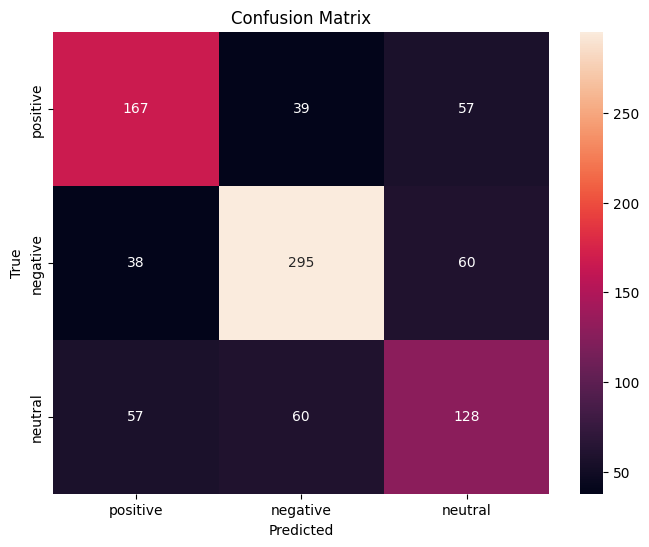

In [ ]:
# Train and evaluate model 1

# initialise model hyperparams
base_model_config = {
    'model_type': 'BiLSTM_concat_all',
    'vocab_size': len(vocab),
    'embedding_dim': emb_matrix.shape[-1],
    'hidden_dim': 256,              # hidden dimension of Bi-LSTM layer
    'output_dim': 3,                # 3 sentiment classes
    'batch_size': 128,              # batch size for training
    'learning_rate': 0.007,
    'num_epochs': 20,
    'experiment_log_details': '',   # experiment context (informal)
    'visualise_training': False,
}

# init config for models
config = create_experiment_config(config, base_model_config, base_model_config['model_type'])

# Initialise model
model_1_all = BiLSTMConcatAspect(config['vocab_size'], config['embedding_dim'], config['hidden_dim'], config['output_dim'], emb_matrix).to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_all.parameters(), lr=config['learning_rate'])

# Train model
train(model_1_all, m1_all_train_loader, m1_val_loader, optimizer, loss_function, config['num_epochs'], config, has_attention=False, validation=False)
print()
# Evaluate model
test_loss, test_acc, y_true, y_pred = evaluate(model_1_all, m1_test_loader, loss_function, val=False, return_output=True, has_attention=False)
model_1_all_metrics = get_training_stats(y_true, y_pred, print_stats=True)

In [ ]:
# Prepare data for model 2 and 3

# sents encoded
all_train_sents_indices = tokens_to_indices(all_train_sents, vocab)

# Pad sequences
all_train_sents_padded = pad_sequence(all_train_sents_indices, batch_first=True, padding_value=0)

# Encode aspects using the same vocab (word_to_ix)
all_train_aspects_enc = [vocab.get(asp, vocab["[UNK]"]) for asp in list(all_train_aspects_df)]

# encoded labels - renamed for clarity
all_train_labels_enc = all_train_labels

# Batch and shuffle data using DataLoader
m2_all_train_dataset = SentimentDataset(all_train_sents_padded, all_train_aspects_enc, all_train_labels_enc)
m2_all_train_loader = DataLoader(m2_all_train_dataset, batch_size=batch_size, shuffle=True)

Epoch 1:
Training Loss: 0.9413, Training Accuracy: 55.50%
Epoch 2:
Training Loss: 0.8365, Training Accuracy: 62.84%
Epoch 3:
Training Loss: 0.7685, Training Accuracy: 66.88%
Epoch 4:
Training Loss: 0.7231, Training Accuracy: 69.65%
Epoch 5:
Training Loss: 0.6917, Training Accuracy: 71.27%
Epoch 6:
Training Loss: 0.6544, Training Accuracy: 72.84%
Epoch 7:
Training Loss: 0.6316, Training Accuracy: 74.28%
Epoch 8:
Training Loss: 0.5987, Training Accuracy: 75.72%
Epoch 9:
Training Loss: 0.5647, Training Accuracy: 77.34%
Epoch 10:
Training Loss: 0.5346, Training Accuracy: 78.32%
Final model saved to /content/drive/My Drive/CITS4012_NLP/results/BiLSTM_separate_all/final_model_state.pth
Model config saved to /content/drive/My Drive/CITS4012_NLP/results/BiLSTM_separate_all/model_config.json

Test Loss: 0.7233, Test Accuracy: 69.48%
Accuracy: 0.6947835738068813
Precision (Macro): 0.6783035145031794
Recall (Macro): 0.6728919275021418
F1-Score (Macro): 0.6731346572873752
Precision (Weighted): 0.6

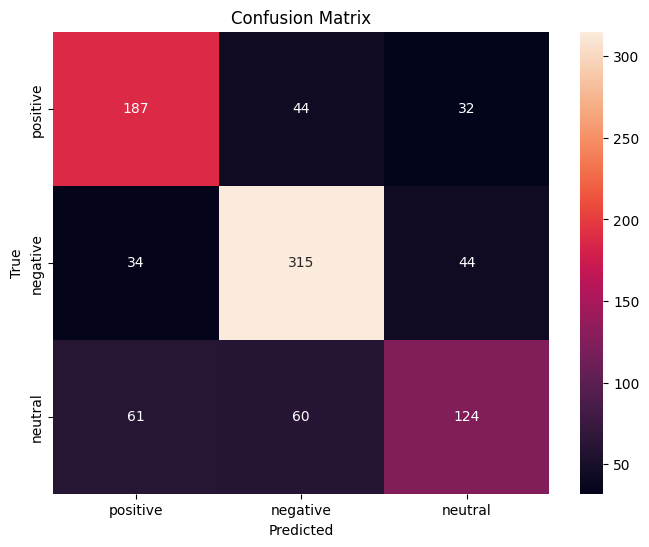

In [ ]:
# Train and evaluate model 2

# Define hyperparameters
embedding_dim = emb_matrix.shape[-1]
hidden_dim = 256 # hidden dimension of Bi-LSTM layer
output_dim = 3 # 3 sentiment classes
vocab_size = len(vocab)
learning_rate = 0.001
num_layers = 1
dropout = 0.2
num_epochs = 10

# Update config with experiment changes
model2_all_config = {
    'model_type': 'BiLSTM_separate_all',
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'vocab_size': len(vocab),
    'embedding_dim': emb_matrix.shape[-1],
    'hidden_dim': hidden_dim,
    'output_dim': output_dim,
    'visualise_training': False,
    'save_model': True
}

# Create experiment config
experiment_name = "BiLSTM_separate_all"
config = create_experiment_config(base_config, model2_all_config, experiment_name)

# Initialise model
model_2_all = BiLSTMSeparateAspect(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product", num_layers, dropout).to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2_all.parameters(), lr=learning_rate)

# Training
train(model_2_all, m2_all_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True, validation=False)
print()
# Evaluate
test_loss, test_acc, y_true, y_pred = evaluate(model_2_all, m2_test_loader, loss_function, val=False, return_output=True, has_attention=True)
model_2_all_metrics = get_training_stats(y_true, y_pred, print_stats=True)

Epoch 1:
Training Loss: 0.9038, Training Accuracy: 59.76%
Epoch 2:
Training Loss: 0.8194, Training Accuracy: 64.24%
Epoch 3:
Training Loss: 0.7371, Training Accuracy: 68.44%
Epoch 4:
Training Loss: 0.6564, Training Accuracy: 72.14%
Epoch 5:
Training Loss: 0.5683, Training Accuracy: 76.41%
Epoch 6:
Training Loss: 0.4823, Training Accuracy: 80.56%
Epoch 7:
Training Loss: 0.3660, Training Accuracy: 85.84%
Epoch 8:
Training Loss: 0.2507, Training Accuracy: 90.84%
Epoch 9:
Training Loss: 0.1924, Training Accuracy: 93.38%
Epoch 10:
Training Loss: 0.1530, Training Accuracy: 95.00%
Final model saved to /content/drive/My Drive/CITS4012_NLP/results/('BiLSTMInteractiveAttn_all',)/final_model_state.pth
Model config saved to /content/drive/My Drive/CITS4012_NLP/results/('BiLSTMInteractiveAttn_all',)/model_config.json

Test Loss: 1.0177, Test Accuracy: 73.14%
Accuracy: 0.7314095449500555
Precision (Macro): 0.7172939072324943
Recall (Macro): 0.71932743762856
F1-Score (Macro): 0.7177993502932484
Preci

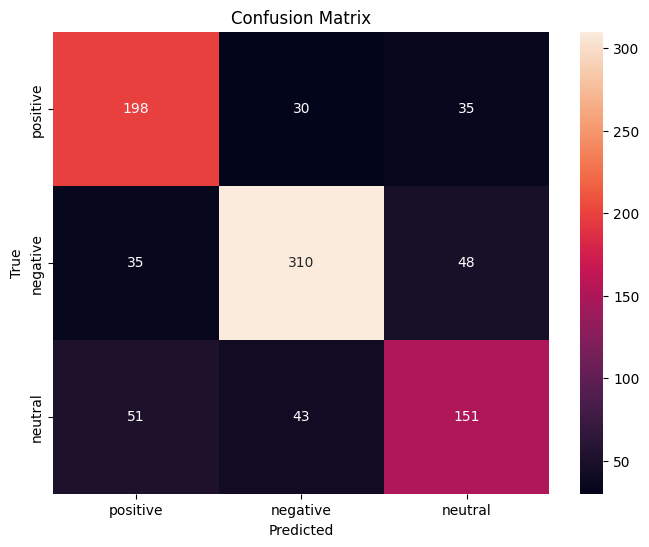

In [ ]:
# Train and evaluate model 3
# Define hyperparameters
embedding_dim = emb_matrix.shape[-1]
hidden_dim = 256 # hidden dimension of Bi-LSTM layer
output_dim = 3 # 3 sentiment classes
vocab_size = len(vocab)
learning_rate = 0.005
num_epochs = 10  # To adjust

# save hyperparameters to config
model3_all_config = {
    'model_type': 'BiLSTMInteractiveAttn_all',
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'vocab_size': len(vocab),
    'embedding_dim': embedding_dim,
    'hidden_dim': hidden_dim,
    'output_dim': output_dim,
    'visualise_training': False,
    'preprocessing_config': config # save preprocessing config with trained model
}
experiment_name = 'BiLSTMInteractiveAttn_all',
config = create_experiment_config(base_config, model3_all_config, experiment_name)

# Initialise model
model_3_all = BiLSTMInteractiveAttn(vocab_size, embedding_dim, hidden_dim, output_dim, emb_matrix, "dot_product").to(device)

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3_all.parameters(), lr=learning_rate)

# Train model
train(model_3_all, m2_all_train_loader, m2_val_loader, optimizer, loss_function, num_epochs, config, has_attention=True, validation=False)
print()
# Evaluate model 3
  # Using the same data from model 2
test_loss, test_acc, y_true, y_pred = evaluate(model_3_all, m2_test_loader, loss_function, return_output=True, has_attention=True)
model_3_all_metrics = get_training_stats(y_true, y_pred, print_stats=True)

#### 3.2.2.1 Summary of model variants performance

In [ ]:
# Create the dictionary with model names as keys and serialized metrics as values
all_train_model_names = ["Model 1 - all train", "Model 2 - all train", "Model 3 - all train"]
all_train_model_metrics = [model_1_all_metrics, model_2_all_metrics, model_3_all_metrics]

model_metrics_dict_all = {name: convert_metrics_to_serializable(metrics)
                      for name, metrics in zip(all_train_model_names, all_train_model_metrics)}

metrics_file = os.path.join(drive_path, "all_train_model_metrics.json")
with open(metrics_file, 'w') as fp:
    json.dump(model_metrics_dict_all, fp, indent=4)

print(f"All model metrics saved to {metrics_file}")

All model metrics saved to /content/drive/My Drive/CITS4012_NLP/all_train_model_metrics.json


In [ ]:
# To load back these metrics back into the environment
all_train_model_metrics_dict = load_data('all_train_model_metrics.json')

In [ ]:
all_models_df = create_metrics_dataframe(["Model 1 - all train", "Model 2 - all train", "Model 3 - all train"], all_train_model_metrics_dict)

all_models_df = pd.concat([all_models_df, baseline_df], ignore_index=True)

all_models_df

model name  accuracy  precision weighted  recall weighted  \
0  Model 1 - all train  0.654828            0.654704         0.654828   
1  Model 2 - all train  0.694784            0.690071         0.694784   
2  Model 3 - all train  0.731410            0.732022         0.731410   
3             baseline  0.587125            0.542952         0.587125   

   f1 score weighted  
0           0.654765  
1           0.690271  
2           0.731255  
3           0.510939

## 3.3 Qualitative Analysis


### 3.3.1 Attention Weights visualisations

Decoded Sentences: [['we', 'went', 'again', 'and', 'sat', 'at', 'the', 'bar', 'this', 'time', 'i', 'had', 'five', 'pints', 'of', '[UNK]', 'and', 'not', 'one', 'buy', 'back', 'i', 'ordered', 'a', 'basket', 'of', 'onion', '[UNK]', 'and', 'there', 'were', 'about', 'five', 'in', 'the', 'basket', 'the', 'rest', 'was', 'filled', 'with', '[UNK]', 'the', 'chili', 'was', 'not', 'even', '[UNK]', '[SEP]', 'place', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'], ['we', 'went', 'again', 'and', 'sat', 'at', 'the', 'bar', 'this', 'time', 'i', 'had', 'five', 'pints', 'of', '[UNK]', 'and', 'not', 'one', 'buy', 'back', 'i', 'ordered', 'a', 'basket', 'of', 'onion', '[UNK]', 'and', 'there', 'were', 'about', 'five', 'in', 'the', 'basket', 'the', 'rest', 'was', 'filled', 'with', '[UNK]', 'the', 'chili', 'was', 'not', 'even', '[UNK]', '[SEP]', 'food', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

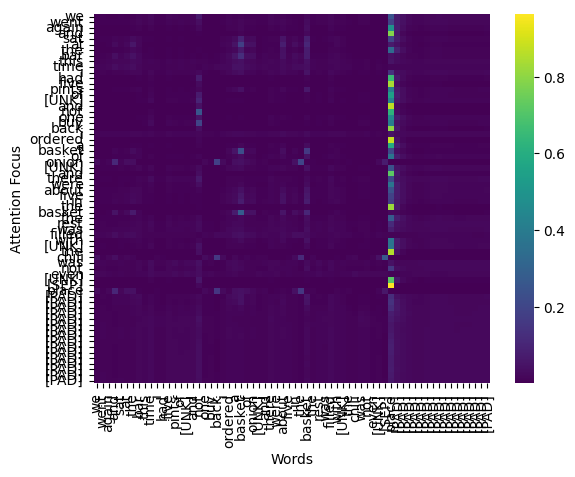

Attention with mask:


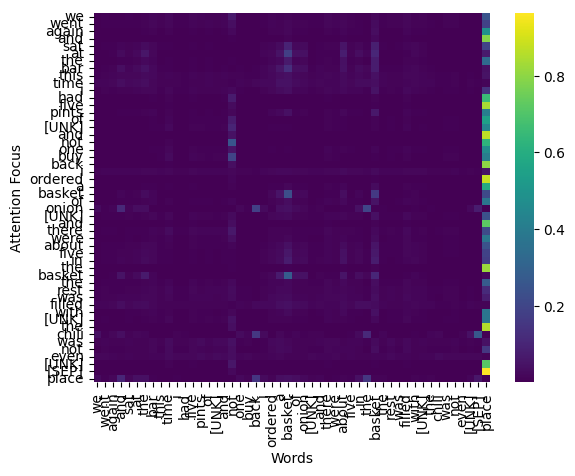

Model Output (logits): [[-1.5670971  1.5342559 -2.1210642]]


In [ ]:
model_1a.eval()
visualize_model_attention(model_1a, m1_test_loader, vocab, pad_token="[PAD]", device=device)

In [196]:
# Define functions for visualising attention weights
def get_tokens_from_indices(indices, vocab):
    """
    Convert list of indices to tokens using the vocabulary.
    """
    return [list(vocab.keys())[list(vocab.values()).index(idx)] if idx in vocab.values() else '[UNK]' for idx in indices]

def filter_padding_tokens(tokens, weights):
    """
    Remove padding tokens and their corresponding attention weights.
    """
    non_pad_indices = [i for i, token in enumerate(tokens) if token != '']
    filtered_tokens = [tokens[i] for i in non_pad_indices]
    filtered_weights = weights[:, non_pad_indices]
    return filtered_tokens, filtered_weights

def visualise_attention_weights(model, sample_idx, dataset, vocab, device, mask_padding=True, visualise_heads=False, plot_type="bar"):
    """
    Visualises attention weights for a specific sample in the dataset.

    Parameters:
    - model: Trained model
    - sample_idx: Index of the sample in the dataset
    - dataset: Dataset object
    - vocab: Vocabulary dictionary
    - device: Torch device (CPU or GPU)
    - mask_padding: Boolean flag to remove padding tokens from visualization
    - visualize_heads: Boolean flag to visualize each attention head separately or average them
    - plot_type: Type of plot to use ('bar' or 'heatmap')
    """
    # get same from test
    sentence, aspect, label = dataset[sample_idx]

    # convert sentence and aspect tensors to list
    sentence_indices = sentence.tolist()
    aspect_indices = [aspect.item()]
    sentence_tokens = get_tokens_from_indices(sentence_indices, vocab)
    aspect_tokens = get_tokens_from_indices(aspect_indices, vocab)

    if mask_padding:
        # mask padding tokens
        sentence_tokens = ['' if token == '[PAD]' else token for token in sentence_tokens]

    print("Sentence:", sentence_tokens)
    print("Aspect:", aspect_tokens)
    print("Label:", label.item())

    # move the model and inputs to same device
    model = model.to(device)
    sentence = sentence.unsqueeze(0).to(device)  ## adds the batch dim here
    aspect = aspect.unsqueeze(0).to(device)       ## adds the batch dim here

    # get model output and attn weights
    model.eval()
    with torch.no_grad():
        output, a2s_attn_weights = model(sentence, aspect)

    # get predicted & actual labels
    label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    _, predicted_label_idx = torch.max(output, 1)
    predicted_label = label_mapping[predicted_label_idx.item()]
    actual_label = label_mapping[label.item()]

    # were the predictions correct?
    correct_prediction = predicted_label == actual_label

    # convert attention weights to numpy array
    # squeeze to remove batch dimension
    a2s_attn_weights_np = a2s_attn_weights.squeeze(0).cpu().numpy()

    if mask_padding:
        # rm padding tokens and corresponding attention weights
        filtered_tokens, filtered_attn_weights = filter_padding_tokens(sentence_tokens, a2s_attn_weights_np)
    else:
        filtered_tokens = sentence_tokens
        filtered_attn_weights = a2s_attn_weights_np


    if plot_type == "heatmap":
        # heat map
        plt.figure(figsize=(12, 2))
        sns.heatmap(filtered_attn_weights, annot=True, xticklabels=filtered_tokens, cmap="coolwarm", cbar=False, annot_kws={"size": 10, "rotation": 90})
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel("Sentence Tokens", fontsize=14)
        plt.ylabel("Attention Weights", fontsize=14)
        plt.title(f"Aspect to Sentence Attention Weights \n For Aspect: {aspect_tokens[0]}", fontsize=16)
        plt.show()
    else:
        # bar chart with / without multiple heads
        if visualise_heads:
            # plot each head separately (if multi-head attention is used)
            num_heads = filtered_attn_weights.shape[0]
            fig, axes = plt.subplots(num_heads, 1, figsize=(12, 4 * num_heads), sharex=True)

            if num_heads == 1:
                axes = [axes]

            for i in range(num_heads):
                ax = axes[i]
                bars = ax.bar(filtered_tokens, filtered_attn_weights[i], color=plt.cm.viridis(filtered_attn_weights[i] / max(filtered_attn_weights[i])))
                ax.set_ylim(0, 1)
                ax.set_ylabel(f'Head {i+1} Attention Weights', fontsize=14)
                ax.set_xticks(range(len(filtered_tokens)))
                ax.set_xticklabels(filtered_tokens, rotation=45, ha='right', fontsize=12)

                # add attention weight values on top of the bars if greater than 0.01
                for bar, weight in zip(bars, filtered_attn_weights[i]):
                    if weight >= 0.01:
                        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{weight:.2f}', ha='center', va='bottom', fontsize=10, rotation=90)

            fig.suptitle(f"Aspect to Sentence Attention Weights \n For Aspect: {aspect_tokens[0]}", fontsize=16)

            # add predicted and actual labels in the corner of the last plot
            label_text = f"Predicted: {predicted_label}\nActual: {actual_label}"
            bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="green" if correct_prediction else "red", alpha=0.5)
            axes[-1].text(1, 1.03, label_text, horizontalalignment='right', verticalalignment='bottom', fontsize=10, bbox=bbox_props, transform=axes[-1].transAxes)

            plt.show()
        else:
            # use mean of attention weights if there are multiple heads
            mean_attn_weights = np.mean(filtered_attn_weights, axis=0)

            plt.figure(figsize=(12, 4))
            bars = plt.bar(filtered_tokens, mean_attn_weights, color=plt.cm.viridis(mean_attn_weights / max(mean_attn_weights)))
            plt.xlabel("Sentence Tokens", fontsize=14)
            plt.ylabel("Attention Weights", fontsize=14)
            plt.title(f"Aspect to Sentence Attention Weights \n For Aspect: {aspect_tokens[0]}", fontsize=16)
            plt.xticks(rotation=45, ha='right', fontsize=12)
            plt.ylim(0, 1.1)

            # add attention weight values on top of the bars if greater than 0.01
            for bar, weight in zip(bars, mean_attn_weights):
                if weight >= 0.01:
                    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{weight:.2f}', ha='center', va='bottom', fontsize=10, rotation=90)

            # add predicted and actual labels in corner of plot
            label_text = f"Predicted: {predicted_label}\nActual: {actual_label}"
            bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="green" if correct_prediction else "red", alpha=0.5)
            plt.text(1, 1.03, label_text, horizontalalignment='right', verticalalignment='bottom', fontsize=10, bbox=bbox_props, transform=plt.gca().transAxes)

            plt.show()

#### 3.3.1.2 Correct predictions

Sentence: ['we', 'went', 'again', 'and', 'sat', 'at', 'the', 'bar', 'this', 'time', 'i', 'had', 'five', 'pints', 'of', '', 'and', 'not', 'one', 'buy', 'back', 'i', 'ordered', 'a', 'basket', 'of', 'onion', '', 'and', 'there', 'were', 'about', 'five', 'in', 'the', 'basket', 'the', 'rest', 'was', 'filled', 'with', '', 'the', 'chili', 'was', 'not', 'even', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['place']
Label: 1


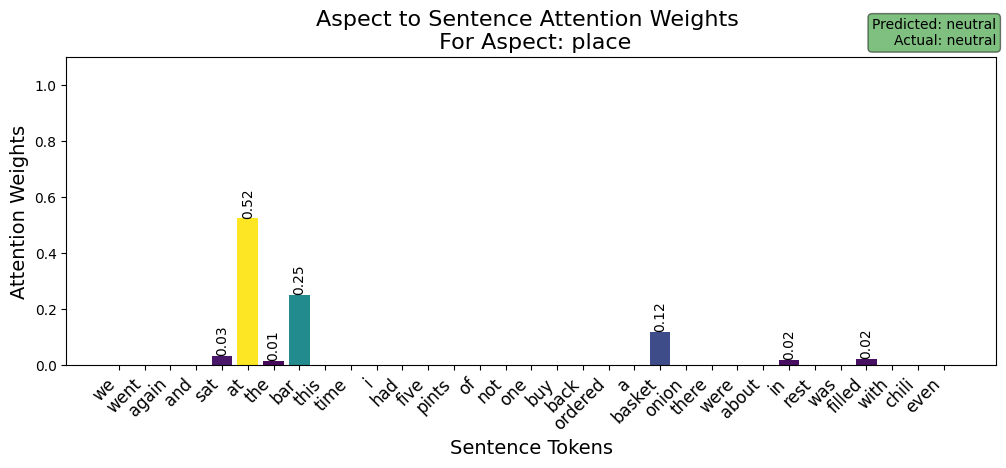

In [198]:
visualise_attention_weights(model_3_all, 0, m2_test_dataset, vocab, device, mask_padding=True)

Sentence: ['we', 'went', 'again', 'and', 'sat', 'at', 'the', 'bar', 'this', 'time', 'i', 'had', 'five', 'pints', 'of', '', 'and', 'not', 'one', 'buy', 'back', 'i', 'ordered', 'a', 'basket', 'of', 'onion', '', 'and', 'there', 'were', 'about', 'five', 'in', 'the', 'basket', 'the', 'rest', 'was', 'filled', 'with', '', 'the', 'chili', 'was', 'not', 'even', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['food']
Label: 0


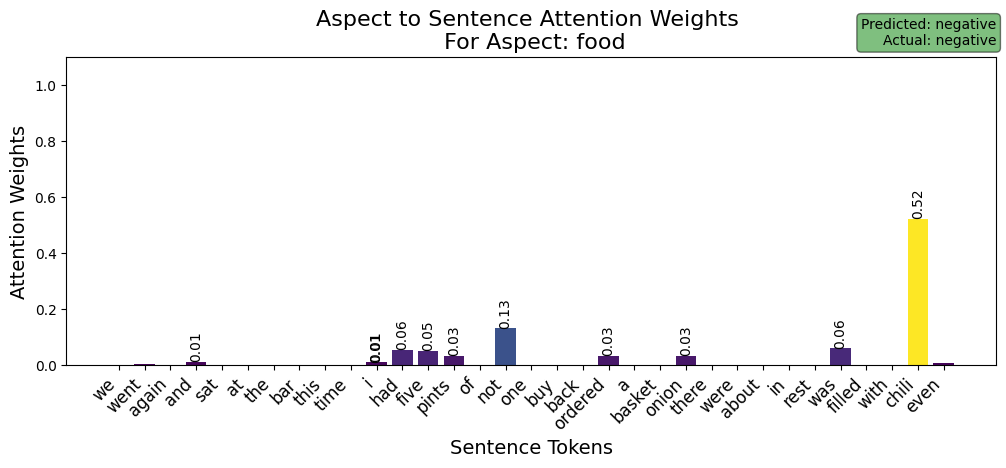

In [199]:
visualise_attention_weights(model_3_all, 1, m2_test_dataset, vocab, device, mask_padding=True)

Sentence: ['i', 'thought', 'it', 'was', 'great', 'best', 'service', 'i', 'have', 'ever', 'had', 'in', 'a', 'long', 'time', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['service']
Label: 2


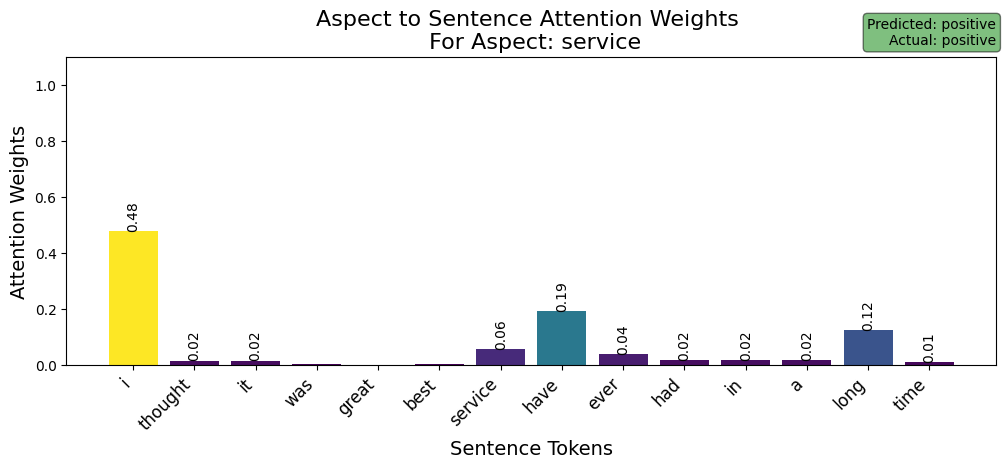

In [200]:
visualise_attention_weights(model_3_all, 92, m2_test_dataset, vocab, device, mask_padding=True)

Sentence: ['i', 'thought', 'it', 'was', 'great', 'best', 'service', 'i', 'have', 'ever', 'had', 'in', 'a', 'long', 'time', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['miscellaneous']
Label: 1


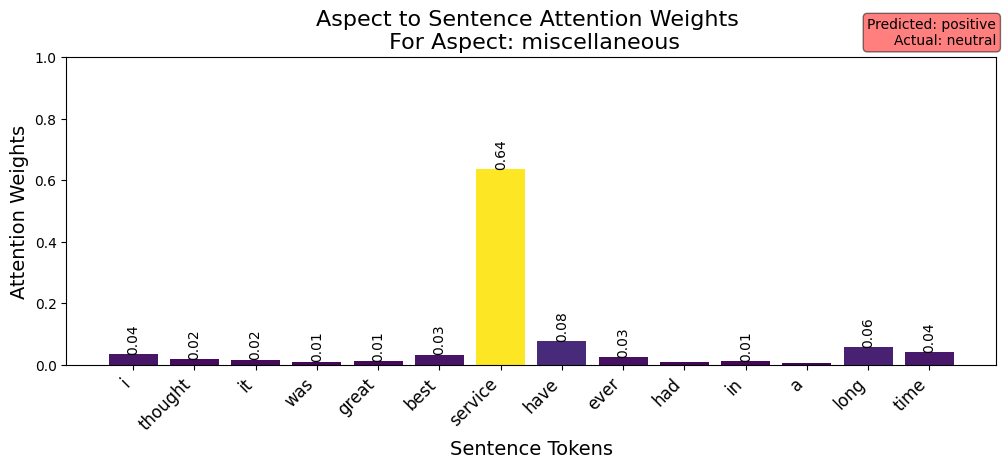

In [192]:
visualise_attention_weights(model_3_all, 93, m2_test_dataset, vocab, device, mask_padding=True)

Sentence: ['when', 'one', '', 'the', 'quality', 'of', 'the', 'food', 'to', 'some', 'of', 'the', '', 'other', 'italian', 'restaurants', 'and', 'then', 'particularly', 'when', 'one', '', 'in', 'the', 'very', 'reasonable', 'prices', 'here', 'i', 'feel', 'that', 'this', 'restaurant', 'comes', 'out', 'a', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['food']
Label: 1


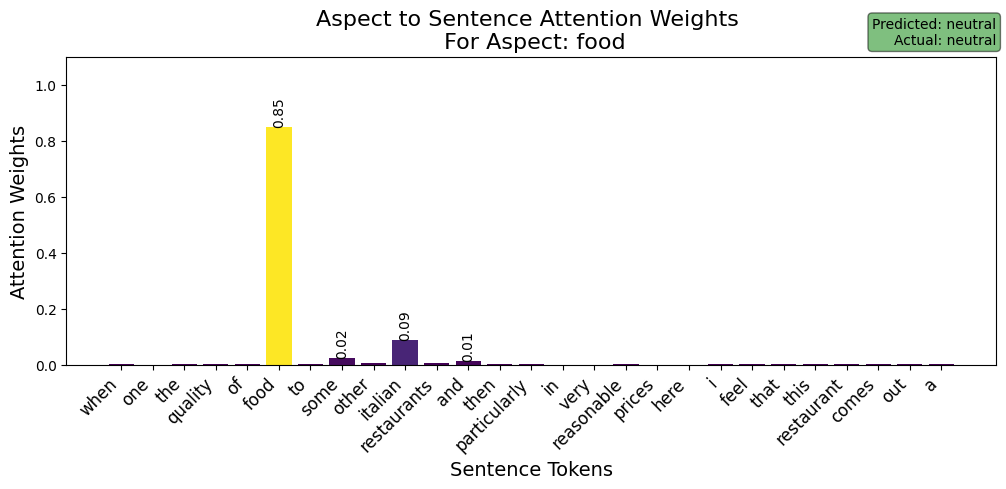

In [224]:
visualise_attention_weights(model_3_all, 408, m2_test_dataset, vocab, device, mask_padding=True)

Sentence: ['when', 'one', '', 'the', 'quality', 'of', 'the', 'food', 'to', 'some', 'of', 'the', '', 'other', 'italian', 'restaurants', 'and', 'then', 'particularly', 'when', 'one', '', 'in', 'the', 'very', 'reasonable', 'prices', 'here', 'i', 'feel', 'that', 'this', 'restaurant', 'comes', 'out', 'a', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['price']
Label: 2


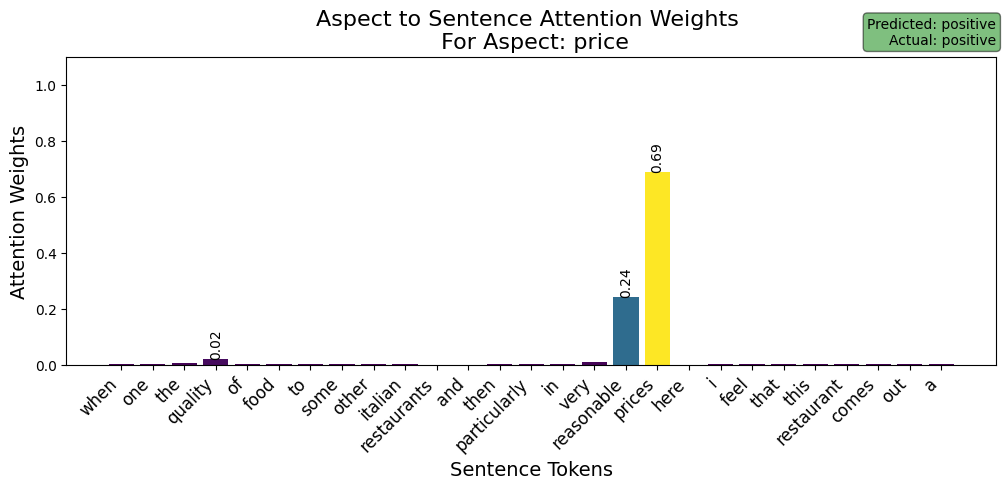

In [223]:
visualise_attention_weights(model_3_all, 409, m2_test_dataset, vocab, device, mask_padding=True)

Sentence: ['i', 'did', 'not', 'like', 'the', 'place', 'because', 'it', 'took', 'the', 'waiter', 'over', 'twenty', 'min', 'to', 'take', 'our', 'order', 'and', 'then', 'over', 'an', 'hour', 'until', 'we', 'got', 'our', 'food', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['staff']
Label: 0


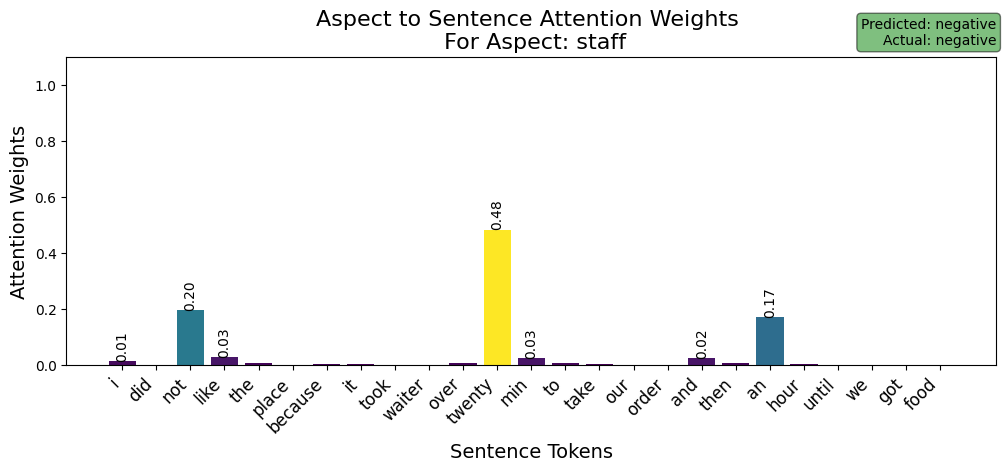

In [226]:
visualise_attention_weights(model_3_all, 410, m2_test_dataset, vocab, device, mask_padding=True)

Sentence: ['i', 'did', 'not', 'like', 'the', 'place', 'because', 'it', 'took', 'the', 'waiter', 'over', 'twenty', 'min', 'to', 'take', 'our', 'order', 'and', 'then', 'over', 'an', 'hour', 'until', 'we', 'got', 'our', 'food', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['food']
Label: 1


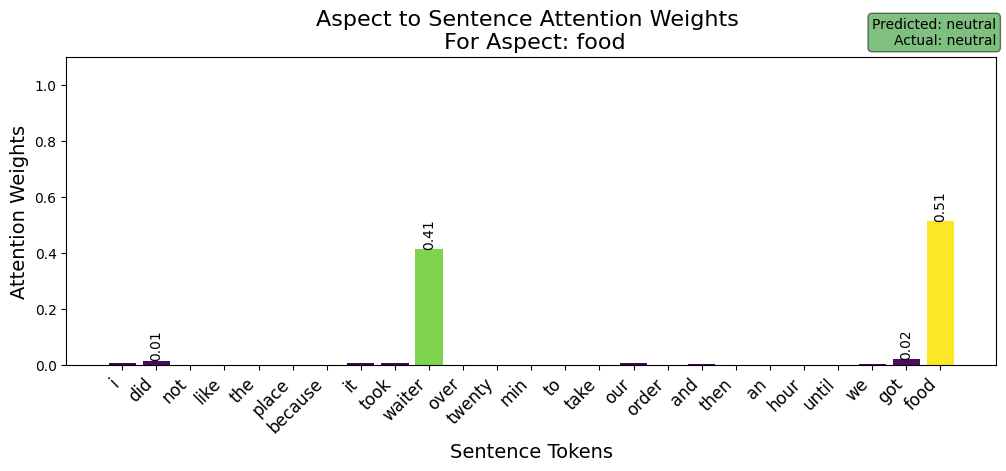

In [229]:
visualise_attention_weights(model_3_all, 411, m2_test_dataset, vocab, device, mask_padding=True)

### Error Analysis

Sentence: ['they', 'continue', 'to', 'expand', 'their', 'garden', 'space', 'wout', '', 'their', 'kitchen', 'and', 'can', 'not', 'provide', 'even', 'adequate', 'service', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['place']
Label: 2


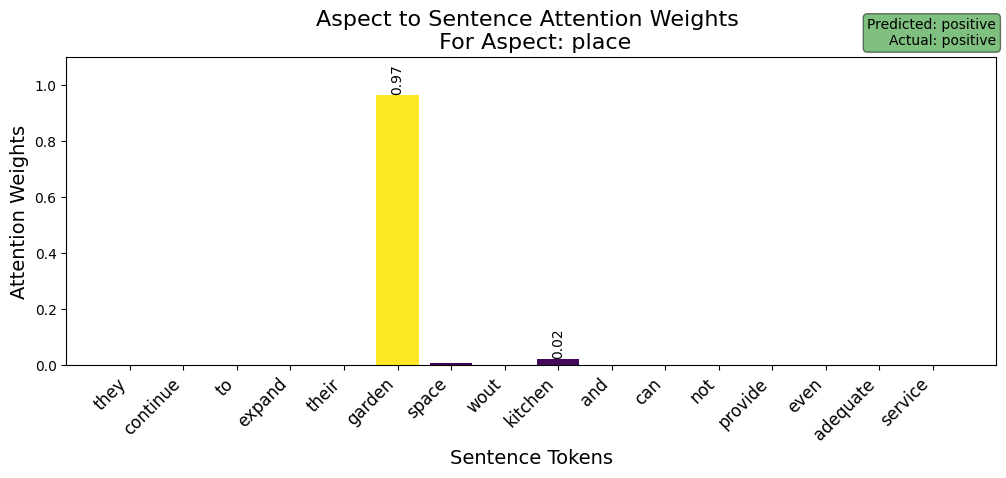

In [201]:
visualise_attention_weights(model_3_all, 14, m2_test_dataset, vocab, device, mask_padding=True)

Sentence: ['they', 'continue', 'to', 'expand', 'their', 'garden', 'space', 'wout', '', 'their', 'kitchen', 'and', 'can', 'not', 'provide', 'even', 'adequate', 'service', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['service']
Label: 0


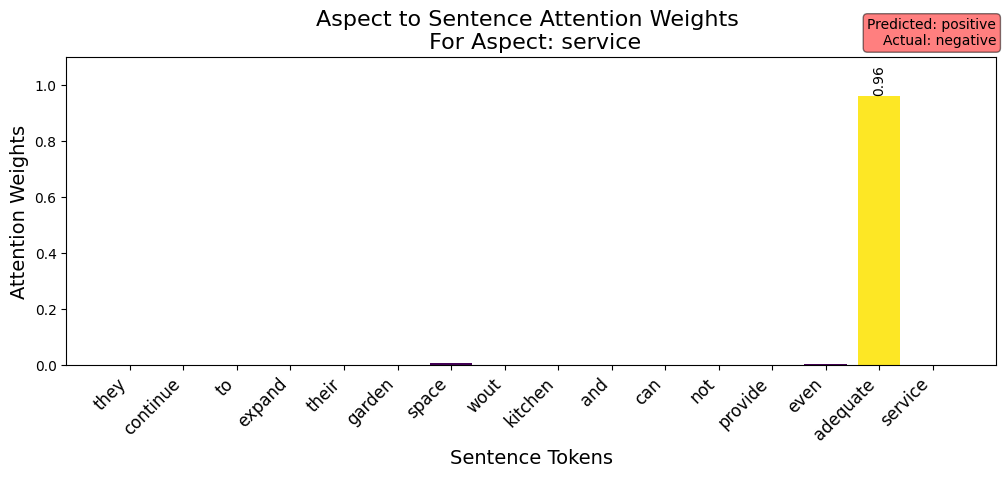

In [202]:
visualise_attention_weights(model_3_all, 15, m2_test_dataset, vocab, device, mask_padding=True)

Sentence: ['d', 'who', 'can', 'not', 'decide', 'on', 'a', 'single', 'dish', 'the', 'tapas', 'menu', 'allowed', 'me', 'to', '', 'my', 'true', 'culinary', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['food']
Label: 0


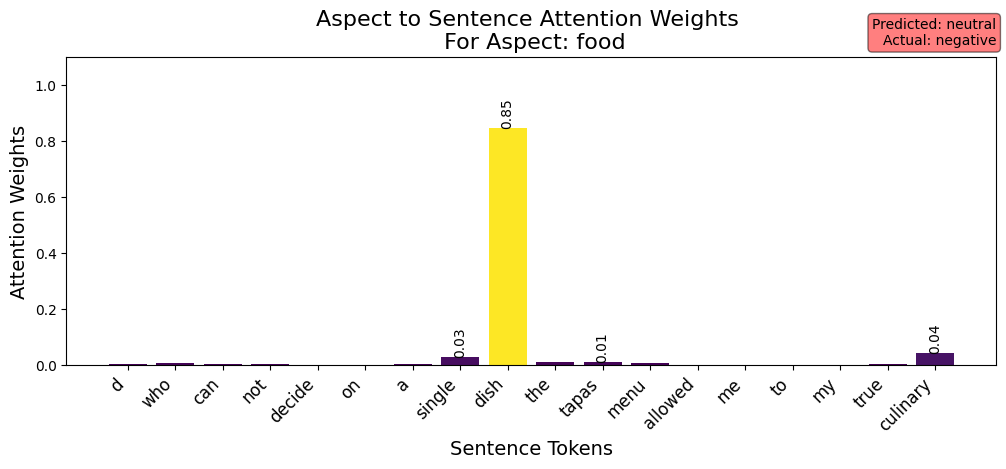

In [216]:
visualise_attention_weights(model_3_all, 205, m2_test_dataset, vocab, device, mask_padding=True)

Sentence: ['d', 'who', 'can', 'not', 'decide', 'on', 'a', 'single', 'dish', 'the', 'tapas', 'menu', 'allowed', 'me', 'to', '', 'my', 'true', 'culinary', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['menu']
Label: 2


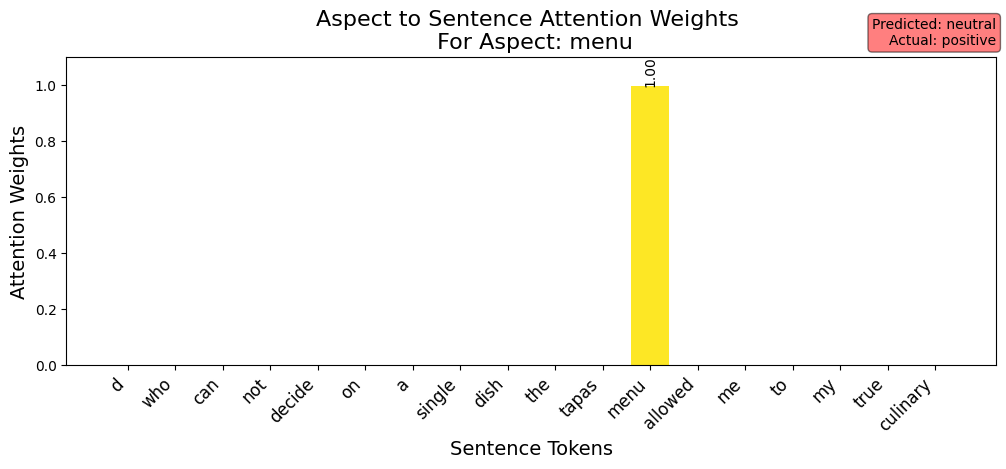

In [211]:
visualise_attention_weights(model_3_all, 206, m2_test_dataset, vocab, device, mask_padding=True)

Sentence: ['the', 'menu', 'is', 'short', 'and', 'sweet', '', '', 'and', 'double', '', 'with', 'all', 'beef', 'patties', '', 'grilled', 'on', 'a', 'pile', 'of', 'onions', 'and', 'served', 'on', 'square', 'white', '', 'with', 'pickles', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['menu']
Label: 2


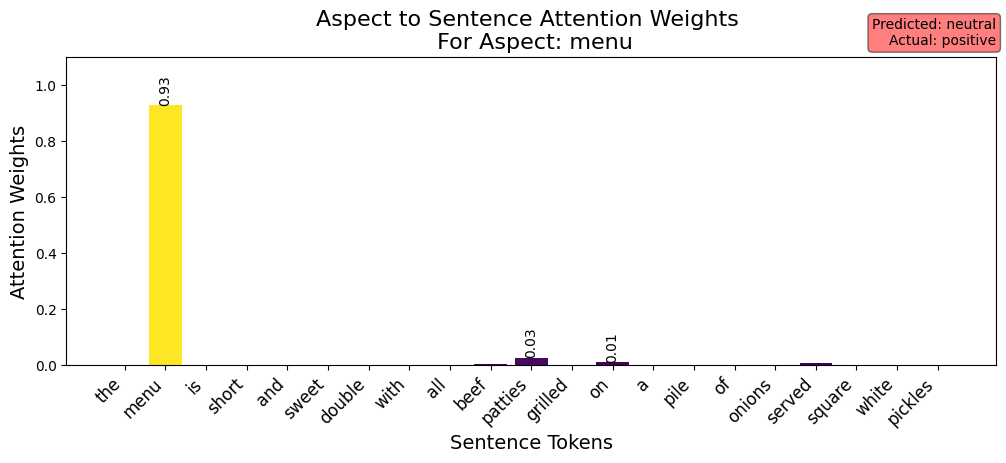

In [219]:
visualise_attention_weights(model_3_all, 350, m2_test_dataset, vocab, device, mask_padding=True)

Sentence: ['the', 'menu', 'is', 'short', 'and', 'sweet', '', '', 'and', 'double', '', 'with', 'all', 'beef', 'patties', '', 'grilled', 'on', 'a', 'pile', 'of', 'onions', 'and', 'served', 'on', 'square', 'white', '', 'with', 'pickles', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Aspect: ['food']
Label: 1


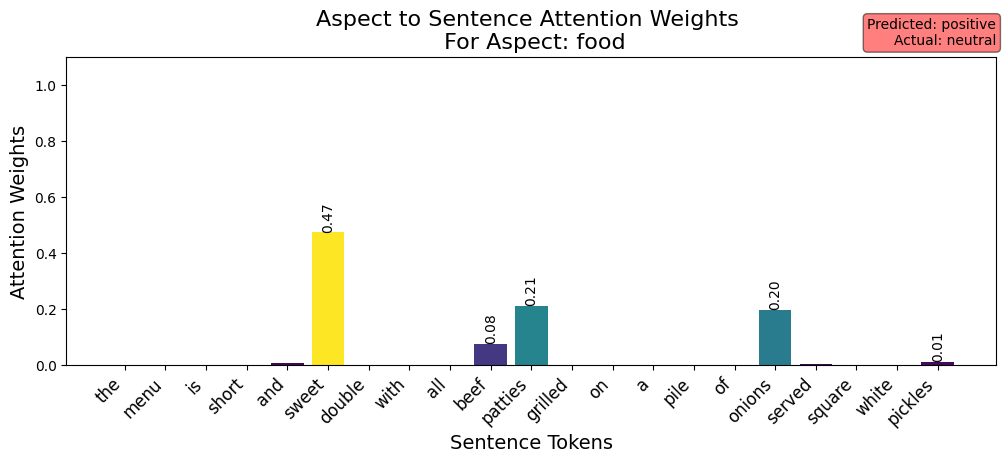

In [220]:
visualise_attention_weights(model_3_all, 351, m2_test_dataset, vocab, device, mask_padding=True)

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*